In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from dashboard.data_load import load_sorf_df_conformed

In [1]:
import matplotlib.pyplot as plt
from dashboard.data_load import load_sorf_df_conformed, load_jsonlines_table
from dashboard.etl import DATA_DIR, CACHE_DIR

import pandas as pd
import os

2023-11-20 16:41:04.398 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-20 16:42:10.478 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-20 16:42:10.501 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-20 16:42:10.512 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-20 16:42:10.514 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-20 16:42:10.516 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-20 16:42:10.518 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-20 16:42:10.520 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-

In [31]:
sorf_df = load_jsonlines_table('../cache/sorf_table.jsonlines')
# exist_on_transcript = sorf_df['transcripts_exact'].apply(len)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 788/788 [00:00<00:00, 11488.89it/s]


In [35]:
!wc -l etl/all_sorfs.txt

5605 etl/all_sorfs.txt


In [2]:
from dashboard.etl.sorf_query import *
# from transcript_features import *
# from amino_acid_features import *
from dashboard.app import load_mouse_blastp_results
from dashboard.etl.sorf_query import parse_sorf_phase
from dashboard.etl.transcript_features import load_xena_transcripts_with_metadata_from_s3, process_sums_dataframe_to_heatmap, create_comparison_groups_xena_tcga_vs_normal, read_tcga_de_from_s3, load_de_results
from dashboard.data_load import load_esmfold
import numpy as np

import pandas as pd
import sys
import multiprocessing as mp
import subprocess
import shlex
import json
import pickle
import os

from dashboard.etl import CACHE_DIR

In [4]:
OUTPUT_DIR = CACHE_DIR

In [16]:
rows = []
sorfs_overlapping = pd.read_csv(os.path.join(DATA_DIR, 'sorf_overlapping_orfs.csv'), index_col=1).drop('Unnamed: 0', axis=1)
vtx_groups = sorfs_overlapping.groupby(sorfs_overlapping.index)
for vtx_id, groupdf in vtx_groups:
    overlapping_in_frame = any(groupdf['frame_overlap'] & groupdf['cds_overlap'])
    
    rows.append({'vtx_id': vtx_id, 'isoform_in_frame': overlapping_in_frame})
    
    # break
isoforms = pd.DataFrame(rows)

In [19]:
isoforms[isoforms['vtx_id']=='VTX-0677620']

,vtx_id,isoform_in_frame
676,VTX-0677620,False


In [20]:
    sorf_df = load_jsonlines_table(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'), index_col='vtx_id')
    # Format table to conform to standardized entries

    session = base.Session()
    sorf_df['index_copy'] = sorf_df.index

    sorf_df['show_details'] = False
    sorf_df['orf_xrefs'] = sorf_df.apply(lambda x: tuple(x.orf_xrefs.split(';')), axis=1)
    sorf_df['source'] = sorf_df.apply(lambda x: tuple(x.source.split(';')), axis=1)

    cols = list(sorf_df.columns)
    cols.insert(0, cols.pop(cols.index('show_details')))

    phase_ids = []
    phase_entries = []
    protein_xrefs = []
    for row in tqdm(sorf_df.itertuples()):
        protein_xrefs.append(tuple([str(px.xref) for px in \
                                session.query(ProteinXref)\
                                        .join(Protein, Protein.id == ProteinXref.protein_id)\
                                        .filter(Protein.aa_seq == row.aa).all()]))


    phase_ids, phase_entries = parse_sorf_phase(sorf_df, session)
    sorf_df['screening_phase_id'] = phase_ids
    sorf_df['screening_phase'] = phase_entries
    sorf_df['protein_xrefs'] = protein_xrefs
    sorf_df['aa_length'] = sorf_df.apply(lambda x: len(x.aa), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5606/5606 [00:00<00:00, 95158.43it/s]
5606it [01:15, 74.30it/s]


In [25]:
!ls ../data

'Ph7 hit list.xlsx'
'Ph9 hit list final.xlsx'
 all_secreted_phase1to7.txt
 autoimmune_de.db
 autoimmune_expression_atlas_v1.db
 cancer_types.txt
 interim_phase1to6_all_phylocsf-vals_20230628.csv
 interim_phase1to6_secreted_hits_20230330.xlsx
 interim_phase1to7_all_20230717.csv
 interim_phase1to7_all_phylocsf-vals_20230628.csv
 phase1_standardized.xlsx
 phase1to7_all_esmfold.jsonlines.gz
 phase1to7_secreted_esmfold.jsonlines
 phase2_standardized.xlsx
 phase3_standardized.xlsx
 phase4_standardized.xlsx
 phase5_standardized.xlsx
 phase6_standardized.xlsx
 phase7_standardized.xlsx
 phase9_standardized.xlsx
 phase_7_secreted_hits.csv
 sorf_overlapping_orfs.csv
 uniprot_sprot.fasta


In [37]:

new_df = fix_missing_phase_ids(sorf_df)
new_df['screening_phase'].unique()

array(['Phase 7', 'Phase 2', 'Phase 5', 'Phase 3', 'Phase 1', 'Phase 6',
       'Phase 4'], dtype=object)

In [11]:
sorf_class = pd.read_csv(os.path.join(DATA_DIR, 'sorf_overlapping_orfs.csv'), index_col=0)
for vtx_id, subdf in sorf_class.groupby('VTX_ID'):
    if subdf.shape[0] == 1:
        
    break
subdf

,VTX_ID,Chromosome,Strand,transcript_id,gene_id,block_starts,block_lengths,nuc_seq,nuc_seqs,exon_overlap_opposite,aa_seq,aa_seqs,block_canonical_overlaps,uorf,iorf,dorf,overlap_intron,cds_overlap,cds_overlap_opposite,overlapping_bases_cds,%_overlapping_bases_cds,frame_overlap,overlapping_aa,%_overlapping_aa,splice_match
2298,VTX-0002499,17,+,ENST00000254072,ENSG00000187272,41238051;41238528,477;3,ATGACCCACTGTTGTTCCCCTTGCTGTCAGCCTACGTGCTGCAGGACCACCTGCTGGAAGCCCACCACTGTGACCACCTGCAGCAGCACACCCTGCTGCCAGCCCTCCTGCTGTGTGTCCAGCTGCTGCCAGCCTTGCTGCCGCCCAACTTGCTGTCAAAACACCTGCTGCCAGCCCATCTGTGTGACCAGCTGCT...,ATGACCCACTGTTGTTCCCCTTGCTGTCAGCCTACGTGCTGCAGGACCACCTGCTGGAAGCCCACCACTGTGACCACCTGCAGCAGCACACCCTGCTGCCAGCCCTCCTGCTGTGTGTCCAGCTGCTGCCAGCCTTGCTGCCGCCCAACTTGCTGTCAAAACACCTGCTGCCAGCCCATCTGTGTGACCAGCTGCT...,False,MTHCCSPCCQPTCCRTTCWKPTTVTTCSSTPCCQPSCCVSSCCQPCCRPTCCQNTCCQPICVTSCCQPSCCSTPCCQPTCCGQTSCGSSCGQSSSCAPVYCRRTCYHPTTVCLPGCLNQSCGSNCCQPCCRPACCETTCCRTTCFQPTCVSSCCQPSCC*,MTHCCSPCCQPTCCRTTCWKPTTVTTCSSTPCCQPSCCVSSCCQPCCRPTCCQNTCCQPICVTSCCQPSCCSTPCCQPTCCGQTSCGSSCGQSSSCAPVYCRRTCYHPTTVCLPGCLNQSCGSNCCQPCCRPACCETTCCRTTCFQPTCVSSCCQPSCC;*,True;False,True,True,True,False,True,False,477.0,1.0,True,159,1.0,True


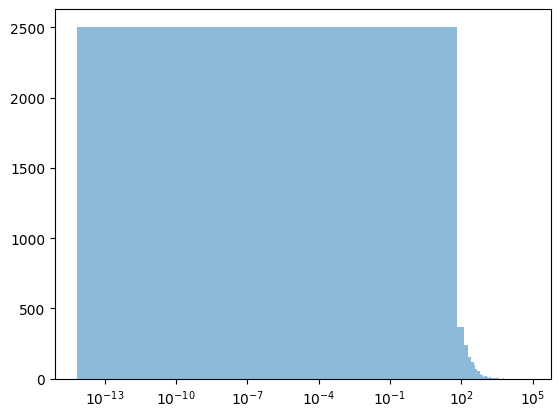

In [55]:
from dashboard.etl import DATA_DIR
from dashboard.tabs.riboseq_atlas import get_average_coverage

df = get_average_coverage()
plt.hist(df.sum(axis=1), bins=1000, alpha=0.5)
plt.xscale('log')

In [43]:
selected_transcripts_ai = ['ENST00000436782.5']


db_address = DATA_DIR / 'autoimmune_expression_atlas_v1.db'
query_de_transcripts(selected_transcript_ai, db_address).fillna(0.01)


,velia_study,contrast,transcript_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10_padj,gene_id,case_mean,control_mean


In [41]:
from dashboard.util import query_de_transcripts
import sqlite3
selected_transcripts = ['ENST00000436782.5']
formatted_ids = ', '.join(f"'{id_}'" for id_ in selected_transcripts)
sql_query = f"SELECT * FROM transcript_tpm WHERE transcript_tpm.transcript_id IN ({formatted_ids});"
selected_expression_ai = pd.read_sql(sql_query, sqlite3.connect('../data/autoimmune_expression_atlas_v1.db')).fillna(0.01)
selected_expression_ai_ave = selected_expression_ai.pivot_table(index='group',
                                                        columns='transcript_id',
                                                        values='tpm', 
                                                        aggfunc=np.nanmean).fillna(0.01).apply(lambda x: np.log2(x+1))
sample_sizes = selected_expression_ai['group'].value_counts()
selected_expression_ai_ave.index = [f"{x} n={sample_sizes[x]}" for x in selected_expression_ai_ave.index]
selected_expression_ai_ave

transcript_id,ENST00000436782.5
BLOOD--HEALTHY n=22,2.012541
BLOOD--RHEUMATOID_ARTHRITIS n=26,2.216979
BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS n=47,1.897759
BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS_DNA_ANTIGEN+ n=3,0.892003
BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS_DNA_ANTIGEN_NUCLEAR_ANTIGEN+ n=2,0.418490
COLON--CROHNS_DISEASE n=16,1.840814
COLON--HEALTHY n=34,2.401104
COLON--ULCERATIVE_COLITIS n=17,1.175831
DENDRITIC_CELLS--HEALTHY n=7,3.707993
DENDRITIC_CELLS--SYSTEMIC_LUPUS_ERYTHEMATOSUS n=7,3.624441


In [12]:
import smart_open
from io import StringIO
from Bio import SeqIO
# Function to parse the FASTA content
def parse_fasta(fasta_content):
    fasta_io = StringIO(fasta_content)
    records = list(SeqIO.parse(fasta_io, "fasta"))
    return records
with smart_open.open('s3://velia-annotation-dev/gencode/v42/gencode.v42.transcripts.fa.gz') as f:
    contents = f.read()
    records = parse_fasta(contents)

In [2]:
from dashboard.etl.transcript_features import *
from dashboard.data_load import load_esmfold
esm = load_esmfold()

2023-11-08 22:10:49.192 
  command:

    streamlit run /home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-11-08 22:10:49.193 No runtime found, using MemoryCacheStorageManager


In [19]:
    sorf_df = pd.read_parquet('../cache_update/sorf_df.parq')
    # esmfold = load_esmfold()
    sorf_df['ESMFold plddt 90th percentile'] = [np.percentile(esmfold[s.replace('*', '')]['plddt'], 90) if s.replace('*', '') in esmfold else -1 for s in sorf_df['aa'].values]


(array([138., 547., 950., 911., 767., 720., 591., 301.,  92.,  14.]),
 array([30.7092886 , 36.91964331, 43.12999802, 49.34035273, 55.55070744,
        61.76106215, 67.97141685, 74.18177156, 80.39212627, 86.60248098,
        92.81283569]),
 <BarContainer object of 10 artists>)

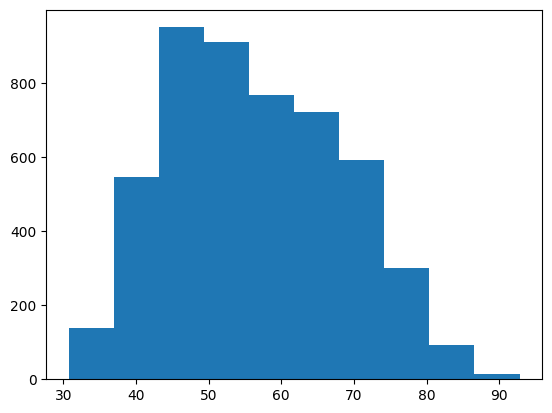

In [23]:
plt.hist(sorf_df['ESMFold plddt 90th percentile'])

In [25]:
df = pd.read_excel('../data/phase7_standardized.xlsx')
df[df['Order ID'] == 'U482HJGUG0-1254']

,Well Location,Order ID,name,trans1,trans2,trans3,sec1,sec2,sec3
626,C7,U482HJGUG0-1254,Phase_7_438_pcDNA3.1(+),279280,245130,NaN,4760,4760,NaN


In [42]:
transcripts_to_map = xena_expression.columns[50:]

In [71]:
xena, metadata, tissue_pairs = load_xena_transcripts_with_metadata_from_s3(transcripts_to_map)

In [78]:
    all_transcripts = [i for i in transcripts_to_map if i.startswith('ENST')]
    # de_tables_dict, de_metadata = load_de_results(all_transcripts)
    # de_tables_dict = {k.split('.')[0]:v for k, v in de_tables_dict.items()}
    # Sum expression over each VTX            
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(all_transcripts)]

In [79]:
xena_vtx_sums

,GTEX-S4Q7-0003-SM-3NM8M,TCGA-19-1787-01,TCGA-S9-A7J2-01,GTEX-QV31-1626-SM-2S1QC,TCGA-G3-A3CH-11,GTEX-13OVI-1026-SM-5L3EM,GTEX-13OW5-0626-SM-5J2N2,GTEX-XUZC-2026-SM-4BRW9,TCGA-EK-A2RE-01,TCGA-D5-5538-01,TCGA-VM-A8C8-01,GTEX-X88G-0426-SM-47JZ5,TCGA-ZN-A9VQ-01,TCGA-EE-A17X-06,GTEX-ZAKK-0326-SM-5EGHA,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,TCGA-05-4420-01,GTEX-13W3W-2626-SM-5SIA2,GTEX-WQUQ-2526-SM-4MVNO,TCGA-2G-AAFZ-01,GTEX-P44H-0526-SM-2XCF1,TCGA-DX-A3U8-01,TCGA-GL-8500-01,TCGA-E2-A153-11,GTEX-TSE9-0126-SM-3DB83,GTEX-R55F-0226-SM-48FCI,TCGA-EJ-7125-01,TCGA-IN-7808-01,TCGA-L5-A4OH-01,TCGA-RP-A695-06,TCGA-A4-7828-01,TARGET-20-PARXMP-09,GTEX-13QJC-0011-R8b-SM-5S2U6,GTEX-POMQ-0006-SM-5SI7D,TCGA-B9-A8YH-01,GTEX-Y9LG-0426-SM-4VBRT,TCGA-E1-A7YI-01,TCGA-PC-A5DM-01,TCGA-BR-A4QL-01,TCGA-CH-5751-01,TCGA-A2-A3XX-01,GTEX-QXCU-0626-SM-2TC69,TCGA-DQ-5624-01,TCGA-KK-A7B3-01,GTEX-1269C-2626-SM-5EQ5C,TCGA-HG-A2PA-01,TCGA-06-5412-01,GTEX-ZPCL-0126-SM-4WWC8,TCGA-BP-4989-01,...,TCGA-AN-A0XT-01,GTEX-13VXU-1126-SM-5LU3U,TCGA-62-8402-01,GTEX-131XF-0626-SM-5GIDS,TCGA-QR-A70C-01,TCGA-DU-A76O-01,TCGA-EE-A29L-06,TCGA-44-2659-01,TCGA-4X-A9F9-01,TCGA-C5-A1BJ-01,TCGA-G2-AA3C-01,TCGA-HU-8602-01,TCGA-CR-6470-01,TCGA-CH-5768-01,TCGA-2H-A9GM-01,TCGA-XH-A853-01,GTEX-1313W-1626-SM-5J1OE,GTEX-1122O-2126-SM-5EGIR,TCGA-CM-4751-01,GTEX-T6MN-0011-R6A-SM-5CHQD,TCGA-AO-A0J4-01,GTEX-12ZZY-1526-SM-5LZWF,GTEX-WI4N-2026-SM-4OOS7,TCGA-55-6985-11,TCGA-2Y-A9H2-01,GTEX-R55E-0008-SM-48FCG,TCGA-YL-A9WK-01,TCGA-77-6844-01,TCGA-B8-5549-01,TCGA-IN-AB1X-11,TCGA-CS-4944-01,TCGA-A2-A0YK-01,TCGA-AA-3660-01,TCGA-13-1481-01,GTEX-1399R-0426-SM-5IJE3,GTEX-YFCO-1626-SM-4W1Z3,TCGA-DJ-A2QC-01,TCGA-A8-A09K-01,TCGA-61-1907-01,GTEX-X3Y1-1226-SM-4PQZ8,TCGA-IB-7885-01,TCGA-B6-A0IA-01,GTEX-1117F-2826-SM-5GZXL,TCGA-VQ-AA6F-01,TCGA-BR-8588-01,GTEX-11ZTS-3326-SM-5LU9Y,TCGA-DD-A115-01,GTEX-ZA64-2126-SM-5Q5A8,TCGA-FV-A3I0-11,GTEX-XV7Q-0426-SM-4BRVN
ENST00000530455,6.760828,22.541319,31.010825,17.551227,3.681006,12.780745,26.280121,16.691017,5.211144,22.271086,22.761126,9.530818,16.180676,18.840953,5.030842,15.741488,6.931175,23.451365,8.101000,16.911116,26.071470,30.781679,14.960640,23.501811,15.880671,8.411132,14.590931,12.281373,7.400896,9.840966,11.971234,13.161025,7.801221,8.930866,0.590988,11.871250,20.470863,14.050991,9.011080,4.940990,33.801140,59.059613,18.320665,6.000988,14.741383,3.980915,10.290920,50.611734,25.061485,5.190955,...,19.970520,11.120887,19.291588,13.061059,7.700756,31.679991,22.951237,14.691400,9.770958,16.801289,8.111114,28.720322,16.111289,27.131558,6.241099,14.090980,13.621371,5.650976,30.320045,0.001,29.020491,14.541458,0.001000,11.450987,21.671093,11.920724,42.971255,27.811314,13.080992,4.950932,33.920840,12.651180,42.411982,11.431161,4.771027,13.941366,15.210546,42.929575,31.060303,13.841228,19.780404,19.160987,16.450961,5.931101,1.121011,13.011361,6.821079,24.340721,2.950992,16.630965
ENST00000510385,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
ENST00000238609,62.769856,123.058457,141.190577,35.270741,6.241099,41.542035,51.261365,14.511251,163.506026,38.891959,246.133974,50.992035,82.219005,133.333917,10.340973,72.519647,27.840

In [94]:
    xena_expression = xena[xena.columns[6:]]#pd.read_parquet(os.path.join('../cache', 'xena.parq'))
    xena_metadata = metadata#xena_expression[xena_expression.columns[:6]].copy()
    # xena_expression = xena_expression[xena_expression.columns[6:]].copy()

    all_transcripts = [i for i in transcripts_to_map if i.startswith('ENST')]
    # Sum expression over each VTX            
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(all_transcripts)]
    xena_exact_vtx_sums = {}
    # xena_overlapping_vtx_sums = {}
    transcripts_in_xena = xena_expression.columns
    for vtx_id, row in tqdm(sorf_df.iterrows()):
        transcripts_parsed = [i.split('.')[0] if i.startswith('ENST') else i for i in row['transcripts_exact']]
        intersection_transcripts = transcripts_in_xena.intersection(transcripts_parsed)
        if len(intersection_transcripts) > 0:
            xena_exact_vtx_sums[vtx_id] = xena_expression[intersection_transcripts].sum(axis=1)
    xena_exact_vtx_sums = pd.DataFrame(xena_exact_vtx_sums)

5031it [00:09, 505.82it/s]


In [92]:
transcripts_in_xena

Index(['ENST00000368682', 'ENST00000587459', 'ENST00000238714',
       'ENST00000571129', 'ENST00000390159', 'ENST00000466260',
       'ENST00000623756', 'ENST00000505793', 'ENST00000452659',
       'ENST00000504154',
       ...
       'ENST00000544855', 'ENST00000461966', 'ENST00000397575',
       'ENST00000340834', 'ENST00000419336', 'ENST00000266070',
       'ENST00000530781', 'ENST00000467994', 'ENST00000466189',
       'ENST00000412094'],
      dtype='object', length=6645)

In [60]:
xena_exact_vtx_sums

""


In [81]:
xena_exact_vtx_sums

""


In [95]:
groups = metadata.loc[xena_exact_vtx_sums.index][['_primary_site', '_study']].apply(lambda x: '-'.join(x), axis=1)
groups

GTEX-S4Q7-0003-SM-3NM8M            Blood-GTEX
TCGA-19-1787-01                    Brain-TCGA
TCGA-S9-A7J2-01                    Brain-TCGA
GTEX-QV31-1626-SM-2S1QC     Blood Vessel-GTEX
TCGA-G3-A3CH-11                    Liver-TCGA
                                  ...        
GTEX-11ZTS-3326-SM-5LU9Y       Pituitary-GTEX
TCGA-DD-A115-01                    Liver-TCGA
GTEX-ZA64-2126-SM-5Q5A8            Nerve-GTEX
TCGA-FV-A3I0-11                    Liver-TCGA
GTEX-XV7Q-0426-SM-4BRVN             Lung-GTEX
Length: 19126, dtype: object

In [47]:
sorf_table = sorf_df.copy()

In [28]:
xena_exact_heatmap_data = process_sums_dataframe_to_heatmap(xena_exact_vtx_sums, xena_metadata)

ValueError: Grouper for '<class 'pandas.core.frame.DataFrame'>' not 1-dimensional

In [15]:
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pickle
import json
from app import *
from data_load import *
from plotting import *

CACHE_DIR = '../cache_update'

sorf_df = pd.read_parquet('../cache/sorf_df.parq')
sorf_df.head(3)

,show_details,vtx_id,aa_length,screening_phase_id,screening_phase,ucsc_track,source,orf_xrefs,protein_xrefs,gene_xrefs,transcript_xrefs,transcripts_exact,transcripts_overlapping,aa,nucl,index_copy,genscript_id,chr,strand,start,end,chrom_starts,block_sizes,phases,blastp_score,blastp_query_coverage,blastp_align_length,blastp_gaps,blastp_align_identity,blastp_subject,blastp_hit_description,Deepsig_score,SignalP 6slow_score,SignalP 5b_score,SignalP 4.1_score,Deepsig_cut,SignalP 6slow_cut,SignalP 5b_cut,SignalP 4.1_cut,Phobius,DeepTMHMM,trans1,trans2,trans3,sec1,sec2,sec3,translated_mean,secreted_mean,secreted,translated,swissprot_isoform,ensembl_isoform,refseq_isoform,phylocsf_58m_avg,phylocsf_58m_max,phylocsf_58m_min,phylocsf_vals
vtx_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VTX-0333562,False,VTX-0333562,44,Phase_7_3,Phase 7,chr1:206557668-206583374,"[velia_phase7_Ribo-seq_PBMC_LPS_R848, openprot]","[IP_076823, Phase_7_3, Phase_7_3_pcDNA3.1(+), U482HJGUG0-6]","[Phase_7_3, Phase7_3, Phase_7_3_pcDNA3.1(+)]",17609;83593;ENSG00000266094.8;gene-RASSF5;HGNC:17609;RASSF5;RASSF5,ENSE00002741341.1;exon:ENST00000586344.5:12;ENSE00003475713.1;ENSE00003584726.1;exon-CHS.25457.7;exon-CHS.25457.7;exon-CHS.25457.7;exon:ENST00000586696.5:10;exon:ENST00000588304.5:10;exon:ENST0000...,"[ENST00000577571.5, ENST00000605120.1]","[ENST00000577571, ENST00000580449, ENST00000581503, ENST00000605120, ENST00000579436, CHS, rna-NM_182664, ENST00000636182, rna-NM_182665]",MRRANIFQRMSVNLWRRHSARPHCRRSSRRSTATTRERRTAWA*,ATGCGCAGAGCAAACATCTTTCAAAGAATGTCTGTAAACCTGTGGAGGAGACACAGCGCCCGCCCACACTGCAGGAGATCAAGCAGAAGATCGACAGCTACAACACGCGAGAGAAGAACTGCCTGGGCATGA,VTX-0333562,U482HJGUG0-6,chr1,+,206557668,206583374,206557668;206583269,25;105,0;1,NaN,NaN,NaN,NaN,NaN,None,None,0.0,0.0,0.013147,0.121,-1,-1,-1,-1,-1,-1,200.0,670.0,770.0,0.0,0,0.0,546.666667,0.0,False,False,None,None,None,-8.441636,-4.863,-15.000,"[-9.486000061035156, -9.486000061035156, -9.486000061035156, -7.605999946594238, -7.605999946594238, -7.605999946594238, -5.49399995803833, -5.49399995803833, -5.49399995803833, -6.14300012588501,..."
VTX-0391857,False,VTX-0391857,49,Phase_7_18,Phase 7,chr11:118304942-118312650,"[velia_phase7_Ribo-seq_PBMC_LPS_R848, openprot]","[IP_202416, Phase_7_18, Phase_7_18_pcDNA3.1(+), U482HJGUG0-36]","[Phase_7_18, Phase7_18, Phase_7_18_pcDNA3.1(+)]",CD3E;ENSG00000198851.10;HGNC:1674;1674;916;CD3E;gene-CD3E,ENSG00000263725.1;FTLP13;HGNC:37963;ENSE00003866209.1;exon:ENST00000665101.1:2;ENSE00001852417.1;exon:ENST00000464084.5:10;ENSE00003643563.1;ENSE00003817311.1;ENSE00003817311.1;ENSE00003825037.1;e...,"[ENST00000529713.5, ENST00000361763.9]","[ENST00000526146, ENST00000528435, ENST00000528600, ENST00000529713, ENST00000361763]",MKQRCSRALTGEFWASASYQLAFGGKMVMKKWVVLHRHHIKSPSLEPQ*,ATGAAACAAAGATGCAGTCGGGCACTCACTGGAGAGTTCTGGGCCTCTGCCTCTTATCAGTTGGCGTTTGGGGGCAAGATGGTAATGAAGAAATGGGTGGTATTACACAGACACCATATAAAGTCTCCATCTCTGGAACCACAGTAA,VTX-0391857,U482HJGUG0-36,chr11,+,118304942,118312650,118304942;118307288;118308427;118312153;118312618,59;20;14;17;32,0;0;0;0;0,NaN,NaN,NaN,NaN,NaN,None,None,0.0,0.0,0.004978,0.177,-1,-1,-1,-1,-1,-1,10.0,10.0,10.0,10.0,0,0.0,10.000000,10.0,False,False,None,None,None,-9.262898,-2.806,-15.000,"[-11.847999572753906, -11.847999572753906, -11.847999572753906, -6.6579999923706055, -6.6579999923706055, -6.6579999923706055, -9.097999572753906, -9.097999572753906, -9.097999572753906, -14.69600..."
VTX-0402630,False,VTX-0402630,43,Phase_7_20,Phase 7,chr12:25062830-25063780,"[velia_phase7_Ribo-seq_PBMC_LPS_R848, openprot]","[IP_207916, Phase_7_20, Phase_7_20_pcDNA3.1(+), U482HJGUG0-40]","[Phase_7_20, Phase7_20, Phase_7_20_pcDNA3.1(+)]",ENSG00000118308.16;HGNC:6690;IRAG2;4033;6690;gene-IRAG2;IRAG2,ENSG00000260242;ENSG00000260242.1;ENSG00000269504;ENSG00000269504.3;ENSE00001485571.1;exon-CHS.32768.2;exon:ENST00000380589.4:1;exon-NM_080739.2-1;ENSE00003983568.1;exon:ENST00000701705.1:4;ENSE00...,"[ENST00000636465.1, ENST00000557489.6, ENST00000548766.5, 

In [3]:
from veliadb import base
with base.Session() as session:
    i = session.query(base.Orf).first()
    print(i)

ORF: 286647, VTX-0286647, ,(+)chr1:1308644-1310921


In [20]:
xena_overlap = ['ENST00000577571', 'ENST00000605120']
xena_metadata, xena_transcript_ids = load_xena_metadata()
selected_expression_tcga = pd.read_parquet('../cache/xena_app.parq', columns=xena_overlap)
selected_expression_tcga_ave = selected_expression_tcga.groupby(xena_metadata['dashboard_group']).mean()

In [22]:
                vtx_id = 'VTX-0333562'
                title = f'TCGA/GTEx Transcript Specific Expression - {vtx_id}'
                selected_expression_tcga = pd.read_parquet('../cache/xena_app.parq', columns=xena_overlap)
                selected_expression_tcga_ave = selected_expression_tcga.groupby(xena_metadata['dashboard_group']).mean()
                echart_option_tcga, events_tcga = plotting.expression_heatmap_plot(title, 
                                                                                   selected_expression_tcga_ave,
                                                                                   list(xena_overlap))

{'click': 'function(params) { console.log(params.name); return params.name }',
 'dblclick': 'function(params) { return [params.type, params.name, params.value] }'}

In [25]:
selected_transcripts = ['ENST00000577571.5', 'ENST00000605120.1']
formatted_ids = ', '.join(f"'{id_}'" for id_ in selected_transcripts)
sql_query = f"SELECT * FROM transcript_tpm WHERE transcript_tpm.transcript_id IN ({formatted_ids});"
selected_expression_ai = pd.read_sql(sql_query, sqlite3.connect('../data/autoimmune_expression_atlas_v1.db'))
selected_expression_ai_ave = selected_expression_ai.pivot_table(index='group',
                                                        columns='transcript_id',
                                                        values='tpm', 
                                                        aggfunc=np.nanmean).fillna(0.01)
echart_option_ai, events_ai = plotting.expression_heatmap_plot(title,
                                                               selected_expression_ai_ave,
                                                               median_groups=False)

In [26]:
echart_option_ai

{'title': {'text': 'TCGA/GTEx Transcript Specific Expression - VTX-0333562'},
 'tooltip': {'formatter': "--x_x--0_0--function (params) {var cols = ['NEUTROPHIL--BEHCETS_DISEASE','DENDRITIC_CELLS--SYSTEMIC_LUPUS_ERYTHEMATOSUS','MONOCYTE--HEALTHY','COLON--CROHNS_DISEASE','MONOCYTE--TYPE_2_DIABETES','DENDRITIC_CELLS--HEALTHY','THYROID--GRAVES_DISEASE','COLON--ULCERATIVE_COLITIS','COLON--HEALTHY','SYNOVIAL_TISSUE--RHEUMATOID_ARTHRITIS','SALIVARY_GLAND--HEALTHY','SYNOVIAL_TISSUE--ARTHRALGIA','SYNOVIAL_TISSUE--RHEUMATOID_ARTHRITIS_TRIPLE_DMARD','THYROID--HEALTHY','PANCREATIC_ISLET--TYPE_1_DIABETES','SALIVARY_GLAND--SJOGRENS_SYNDROME','SYNOVIAL_TISSUE--UNKNOWN_ARTHRITIS','SYNOVIAL_TISSUE--HEALTHY','SYNOVIAL_TISSUE--OSTEOARTHRITIS','THYROID--HASHIMOTOS_THYROIDITIS','BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS','PANCREATIC_ISLET--HEALTHY','BLOOD--HEALTHY','SYNOVIAL_FLUID--CALCIUM_PYROPHOSPHATE_DEPOSITION_DISEASE','DENDRITIC_CELLS--SYSTEMIC_SCLEROSIS','BLOOD--RHEUMATOID_ARTHRITIS','SYNOVIAL_FLUID--RHEUM

In [122]:
selected_transcripts = transcripts
selected_transcripts = ['ENST00000519868.1', 'ENST00000229239.10', 'ENST00000520450.1']
formatted_ids = ', '.join(f"'{id_}'" for id_ in selected_transcripts)
sql_query = f"SELECT * FROM transcript_tpm WHERE transcript_tpm.transcript_id IN ({formatted_ids});"
selected_expression = pd.read_sql(sql_query, sqlite3.connect('../data/autoimmune_expression_atlas_v1.db'))
# selected_expression.groupby('transcript_id')

In [33]:
selected_transcript = selected_transcripts[0]
db_address = '/home/ec2-user/repos/dashboard/data/autoimmune_expression_atlas_v1.db'
# option_ai_de = plotting.bar_plot_expression_group_autoimmune(selected_transcript[0], 'DE', db_address)
# st_echarts(options=option_ai_de, key='c', height='900px', width = '650px', renderer='svg')

fig_ai = px.box(data_frame = selected_expression_ai[selected_expression_ai['transcript_id']==value].sort_values('group'),
    x='group', points = 'all',
    y='tpm', height=500,
    width=800
)
option_ai_de

{'title': {'text': 'DE'},
 'tooltip': {'trigger': 'axis',
  'formatter': "--x_x--0_0--function (params) {var cols = {}; console.log(params); return params[0].name + ' - ' + cols[params[0].name] + '<br>' + params[0].seriesName + ': ' + params[0].value  + '<br>' + params[1].seriesName + ': ' + params[1].value;}--x_x--0_0--"},
 'legend': {'data': ['control_mean', 'case_mean'],
  'orient': 'vertical',
  'right': -5,
  'top': 'center'},
 'toolbox': {'show': True,
  'feature': {'dataView': {'show': True, 'readOnly': False},
   'restore': {'show': True},
   'saveAsImage': {'show': True}}},
 'calculable': True,
 'yAxis': [{'name': 'Study',
   'nameLocation': 'middle',
   'nameGap': 50,
   'type': 'category',
   'data': [],
   'axisLabel': {'interval': 0}}],
 'xAxis': [{'name': 'Approximate TPM \n (Transcripts in bold are DE with FDR < 1e-5 and abs(LFC) > 1)',
   'nameLocation': 'middle',
   'nameGap': 30,
   'type': 'value'}],
 'color': ['#237c94', '#d62418'],
 'series': [{'name': 'control_mea

In [ ]:
                xena_vtx_exp_df = xena_metadata.merge(selected_expression_tcga, left_index=True, right_index=True)
                fig = plotting.expression_vtx_boxplot(value.split('.')[0], xena_vtx_exp_df)
                st.plotly_chart(fig, use_container_width=True)

In [ ]:
from veliadb import base


vtx_id = 'VTX-0333562'
vtx_id = int(vtx_id.replace('VTX-', ''))

session = base.Session() # connect to db
orfs = session.query(base.Orf).filter(base.Orf.id == vtx_id).all()
if len(orfs) == 0:
    print(f"{vtx_id} not found in veliadb")
    session.close()
    # return {}
elif len(orfs) > 1:
    print(f"{vtx_id} had multiple entries found in veliadb")
    session.close()
    # return {}
else:
    current_orf = orfs[0]

NameError: name 'selected_expression_tcga' is not defined

In [141]:
selected_expression_ai[selected_expression_ai['transcript_id']=='ENST00000425838.5'].shape

(31, 4)

In [137]:
selected_expression_ai[selected_expression_ai['transcript_id']=='ENST00000425838.5']

,transcript_id,tpm,group,study
0,ENST00000425838.5,0.116956,COLON--HEALTHY,ERP106487
1,ENST00000425838.5,0.197509,COLON--CROHNS_DISEASE,ERP106487
2,ENST00000425838.5,0.201686,COLON--HEALTHY,ERP106487
3,ENST00000425838.5,0.530314,COLON--CROHNS_DISEASE,ERP106487
4,ENST00000425838.5,0.053020,BLOOD--RHEUMATOID_ARTHRITIS,GSE120178
5,ENST00000425838.5,0.132803,PBMC--SYSTEMIC_LUPUS_ERYTHEMATOSUS,GSE122459
6,ENST00000425838.5,0.421640,NEUTROPHIL--SYSTEMIC_LUPUS_ERYTHEMATOSUS,GSE139358
7,ENST00000425838.5,0.085646,NEUTROPHIL--SYSTEMIC_LUPUS_ERYTHEMATOSUS,GSE139358
8,ENST00000425838.5,0.249370,NEUTROPHIL--SYSTEMIC_LUPUS_ERYTHEMATOSUS,GSE139358
9,ENST00000425838.5,0.344245,NEUTROPHIL--SYSTEMIC_LUPUS_ERYTHEMATOSUS,GSE139358


In [126]:
                selected_transcripts = sorf_df.loc['VTX-0033912', 'transcripts_exact']
                formatted_ids = ', '.join(f"'{id_}'" for id_ in selected_transcripts)
                sql_query = f"SELECT * FROM transcript_tpm WHERE transcript_tpm.transcript_id IN ({formatted_ids});"
                selected_expression_ai = pd.read_sql(sql_query, sqlite3.connect('../data/autoimmune_expression_atlas_v1.db'))
                selected_expression_ai_ave = selected_expression_ai.pivot_table(index='group',
                                                                        columns='transcript_id',
                                                                        values='tpm', 
                                                                        aggfunc=np.mean).fillna(0.01)
                selected_expression_ai_ave

transcript_id,ENST00000425838.5,ENST00000498375.2
group,,
BLOOD--HEALTHY,0.095155,0.135946
BLOOD--RHEUMATOID_ARTHRITIS,0.053020,0.044144
BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS,0.024451,0.013805
BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS_DNA_ANTIGEN+,0.043961,0.010000
BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS_NUCLEAR_ANTIGEN+,0.108710,0.010000
COLON--CROHNS_DISEASE,0.214136,0.100882
COLON--HEALTHY,0.143382,0.026093
COLON--ULCERATIVE_COLITIS,0.113511,0.022197
NEUTROPHIL--HEALTHY,0.010000,0.099391


In [99]:
xena_overlap = transcripts
selected_expression = pd.read_parquet('../cache/xena_app.parq', columns=xena_overlap)
selected_expression

,ENST00000519868,ENST00000520450
GTEX-S4Q7-0003-SM-3NM8M,1.580959,11.001284
TCGA-19-1787-01,0.141003,1.100989
TCGA-S9-A7J2-01,0.021000,0.150998
GTEX-QV31-1626-SM-2S1QC,0.100998,0.231006
TCGA-G3-A3CH-11,0.050999,0.231006
...,...,...
GTEX-11ZTS-3326-SM-5LU9Y,0.171004,1.641028
TCGA-DD-A115-01,0.001000,0.001000
GTEX-ZA64-2126-SM-5Q5A8,0.090999,0.600985
TCGA-FV-A3I0-11,0.001000,0.201005


In [97]:
import sqlite3

# Replace this with your SQLite database file path
db_file = '../data/autoimmune_expression_atlas_v1.db'

# Connect to the SQLite database
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Query to find all table names in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(query)

# Fetching all table names
tables = cursor.fetchall()

# Print table names
for table in tables:
    print(table[0])
df = pd.read_sql("SELECT * FROM transcript_de", conn)
# Close the connection
conn.close()
df

transcript_de
transcript_tpm
transcript_tpm_minimum_expression_skipped_transcript_ids


,velia_study,contrast,transcript_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10_padj,gene_id,case_mean,control_mean
0,ERP106487,CROHNSDISEASE_VS_CONTROL,ENST00000488147.1,29.468750,-0.021288,0.222218,-0.102614,0.918269,0.996522,-0.001513,ENSG00000227232.5,3.798333,3.703262
1,ERP106487,CROHNSDISEASE_VS_CONTROL,ENST00000466430.5,1.855763,0.617747,0.643210,1.433256,0.151785,NaN,0.000000,ENSG00000238009.6,0.280791,0.245071
2,ERP106487,CROHNSDISEASE_VS_CONTROL,rna-XR_952254.3,11.750264,0.278664,0.213170,1.386603,0.165563,0.670928,-0.173324,105373279,1.687640,1.415336
3,ERP106487,CROHNSDISEASE_VS_CONTROL,rna-XR_951617.3,5.756952,0.305724,0.358453,0.974066,0.330024,0.846886,-0.072175,105373279,0.858151,0.754685
4,ERP106487,CROHNSDISEASE_VS_CONTROL,rna-NM_020699.4-2,12.543118,0.370979,0.232892,1.687406,0.091525,0.523281,-0.281265,57459,1.829878,1.417359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5822714,SRP379573,BEHCETS_DISEASE_vs_CONTROL,ENST00000361335.1,298.473448,0.001319,0.127671,0.316368,0.751723,0.999996,-0.000002,ENSG00000212907.2,43.479360,29.473344
5822715,SRP379573,BEHCETS_DISEASE_vs_CONTROL,ENST00000361381.2,5922.150594,0.001812,0.131872,0.420049,0.674450,0.999996,-0.000002,ENSG00000198886.2,903.727181,547.864661
5822716,SRP379573,BEHCETS_DISEASE_vs_CONTROL,ENST00000361567.2,1844.197280,0.002643,0.142837,0.650910,0.515105,0.999996,-0.000002,ENSG00000198786.2,309.515030,145.329207
5822717,SRP379573,BEHCETS_DISEASE_vs_CONTROL,ENST00000361681.2,630.951448,0.002054,0.138006,0.509570,0.610352,0.999996,-0.000002,ENSG00000198695.2,101.885756,53.328375


In [48]:
import os
import pandas as pd
transcripts = ['ENST00000519868', 'ENST00000520450']
    
def make_db_for_xena(vtx_id_to_transcripts):
    cache_filez = os.listdir(CACHE_DIR)
    temp_dict = {}
    for f in cache_filez:
        if f.endswith('_de.parq') and not (f=='expression_de.parq'):
            df = pd.read_parquet(os.path.join(CACHE_DIR, f))
            df['transcript'] = df.apply(lambda x: x.name.split('.')[0], axis=1)
            cancer_type = f.split('_')[0]
            temp_dict[cancer_type] = df
            df['TCGA Cancer Type'] = cancer_type
    df = pd.concat(temp_dict.values(), ignore_index=True)
    df['Cancer Mean'] = df['Cancer Mean']/TPM_DESEQ2_FACTOR
    df['GTEx Mean'] = df['GTEx Mean']/TPM_DESEQ2_FACTOR
    df = df.rename({'transcript': 'transcript_id'}, axis=1, inplace=False).drop('baseMean', axis=1)

    tcga_gtex_tissue_metadata = pd.read_parquet(os.path.join(CACHE_DIR, 'gtex_tcga_pairs.parq'))
    tcga_gtex_tissue_metadata = tcga_gtex_tissue_metadata.drop_duplicates(['TCGA Cancer Type', 'GTEx Tissue Type']).copy()
    tcga_gtex_tissue_metadata.index = tcga_gtex_tissue_metadata['TCGA Cancer Type']

    xena_metadata = pd.read_parquet(os.path.join(CACHE_DIR, 'xena_metadata.parq'))
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena_app.parq'))
    xena_exact_heatmap_data = pickle.load(open(os.path.join(CACHE_DIR, 'xena_exact_heatmap.pkl'), 'rb'))
    # xena_overlapping_heatmap_data = pickle.load(open(os.path.join(CACHE_DIR, 'xena_overlapping_heatmap.pkl'), 'rb'))
    xena_metadata['dashboard_group'] = list(map(lambda x: '-'.join(map(str, x)), xena_metadata[['_primary_site', '_study']].values))

    
    engine = create_engine('sqlite:////home/ec2-user/repos/dashboard/cache/xena.db', future=True)
    with engine.connect() as conn:
        df.to_sql('transcript_de', conn, index=False, if_exists='replace')
        tcga_gtex_tissue_metadata.to_sql('sample_metadata_de', conn, index=False, if_exists='replace')
        conn.execute(text("CREATE INDEX idx_transcript_id_de ON transcript_de (transcript_id);"))
        # xena_expression.to_sql('xena_transcript_tpm', conn, index=False, if_exists='replace')
        # xena_metadata.to_sql('xena_metadata', conn, index=False, if_exists='replace')
        # xena_exact_heatmap_data.to_sql('xena_exact_heatmap_data', conn, index=False, if_exists='replace')
        conn.execute(text("CREATE INDEX idx_transcript_id_tpm ON xena_transcript_tpm (transcript_id);"))
        conn.commit()

make_db_for_xena(sorf_df)

In [94]:
%timeit 


653 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
print('done')

In [38]:
from dashboard.util import query_transcripts
query_transcripts('ENST00000519868.1', session)

,id,transcript_id,reference_mean,group_mean,log2fc,log10padj,log10pval,contrast,study
0,1237963,ENST00000519868.1,9.907421,16.580515,0.707377,-2.713433,-4.065098,SYSTEMIC_LUPUS_ERYTHEMATOSUS_vs_CONTROL,GSE162828
1,1299125,ENST00000519868.1,0.781651,4.387905,2.102307,-7.161953,-8.738534,RHEUMATOID_ARTHRITIS_vs_CONTROL,GSE194263


In [30]:
# @st.cache_data()
def load_de_results(transcripts):
    cache_filez = os.listdir(CACHE_DIR)
    temp_dict = {}
    for f in cache_filez:
        if f.endswith('_de.parq') and not (f=='expression_de.parq'):
            df = pd.read_parquet(os.path.join(CACHE_DIR, f))
            df['transcript'] = df.apply(lambda x: x.name.split('.')[0], axis=1)
            df = df[df['transcript'].isin(transcripts)].copy()
            temp_dict[f.split('_')[0]] = df
            
    de_tables_dict = defaultdict(dict)
    for c, df in tqdm(temp_dict.items()):
        for row in df.itertuples():
            de_tables_dict[row[0]][c] = {'Cancer Average': row._7/TPM_DESEQ2_FACTOR, 'GTEx Average': row._8/TPM_DESEQ2_FACTOR, 
                                         'log2FC': row.log2FoldChange, 'padj': row.padj}
    for t, d in de_tables_dict.items():
        de_tables_dict[t] = pd.DataFrame(d).T
    tcga_gtex_tissue_metadata = pd.read_parquet(os.path.join(CACHE_DIR, 'gtex_tcga_pairs.parq'))
    tcga_gtex_tissue_metadata = tcga_gtex_tissue_metadata.drop_duplicates(['TCGA Cancer Type', 'GTEx Tissue Type']).copy()
    tcga_gtex_tissue_metadata.index = tcga_gtex_tissue_metadata['TCGA Cancer Type']
    return de_tables_dict, tcga_gtex_tissue_metadata
old_de_tables_dict, metadata = load_de_results(transcripts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 2262.10it/s]


In [32]:
engine = create_engine('sqlite:////home/ec2-user/repos/dashboard/cache/xena.db', future=True)
with engine.connect() as conn:
    new_metadata = pd.read_sql("SELECT * FROM sample_metadata", conn)

In [72]:
de_table

,log2FoldChange,lfcSE,stat,pvalue,padj,Cancer Mean,GTEx Mean,transcript_id,TCGA Cancer Type
0,2.425863,0.174072,13.935975,3.829347e-44,9.222898e-43,0.070977,0.379760,ENST00000519868,ACC
1,2.485077,0.612304,4.058566,4.937500e-05,3.973964e-04,0.137037,0.765241,ENST00000519868,BLCA
2,2.036660,0.111996,18.185066,6.777410e-74,6.128474e-73,0.201651,0.825614,ENST00000519868,BRCA
3,1.282998,0.471132,2.723226,6.464782e-03,2.089127e-02,0.161632,0.393487,ENST00000519868,CESC
4,1.601815,0.180841,8.857583,8.176801e-19,7.246568e-18,0.169688,0.299255,ENST00000519868,CHOL
5,2.710585,0.109272,24.805871,7.748135e-136,1.381817e-134,0.087808,0.573222,ENST00000519868,COAD
6,3.332225,0.105668,31.534990,2.880226e-218,6.777202e-216,0.420036,4.276559,ENST00000519868,DLBC
7,1.150333,0.096826,11.880430,1.495966e-32,8.028681e-32,0.149146,0.329883,ENST00000519868,ESCA
8,0.156678,0.140991,1.111262,2.664554e-01,3.185605e-01,0.116315,0.130450,ENST00000519868,GBM
9,2.299640,0.075884,30.304613,9.966605e-202,1.260835e-200,0.074928,0.367660,ENST00000519868,HNSC


In [85]:
2**-2

0.25

In [86]:
de_threshold = 

0     False
1     False
2     False
3     False
4     False
5     False
6      True
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23     True
24    False
25    False
26    False
27    False
28    False
29    False
30    False
dtype: bool

In [89]:
de_table['DE'] = (de_table['padj']<0.0001) & (np.abs(de_table['log2FoldChange'])>=2) & (de_table['Cancer Mean'].gt(4) | de_table['GTEx Mean'].gt(4)) 
de_table

,log2FoldChange,lfcSE,stat,pvalue,padj,Cancer Mean,GTEx Mean,transcript_id,TCGA Cancer Type,DE
0,2.425863,0.174072,13.935975,3.829347e-44,9.222898e-43,0.070977,0.379760,ENST00000519868,ACC,False
1,2.485077,0.612304,4.058566,4.937500e-05,3.973964e-04,0.137037,0.765241,ENST00000519868,BLCA,False
2,2.036660,0.111996,18.185066,6.777410e-74,6.128474e-73,0.201651,0.825614,ENST00000519868,BRCA,False
3,1.282998,0.471132,2.723226,6.464782e-03,2.089127e-02,0.161632,0.393487,ENST00000519868,CESC,False
4,1.601815,0.180841,8.857583,8.176801e-19,7.246568e-18,0.169688,0.299255,ENST00000519868,CHOL,False
5,2.710585,0.109272,24.805871,7.748135e-136,1.381817e-134,0.087808,0.573222,ENST00000519868,COAD,False
6,3.332225,0.105668,31.534990,2.880226e-218,6.777202e-216,0.420036,4.276559,ENST00000519868,DLBC,True
7,1.150333,0.096826,11.880430,1.495966e-32,8.028681e-32,0.149146,0.329883,ENST00000519868,ESCA,False
8,0.156678,0.140991,1.111262,2.664554e-01,3.185605e-01,0.116315,0.130450,ENST00000519868,GBM,False
9,2.299640,0.075884,30.304613,9.966605e-202,1.260835e-200,0.074928,0.367660,ENST00000519868,HNSC,False


In [81]:
transcript_id = 'ENST00000519868.1'

import sqlite3

de_table = pd.read_sql("SELECT * FROM transcript_de WHERE transcript_de.transcript_id = '{0}'".format(transcript_id.split('.')[0]),
                       sqlite3.connect('/home/ec2-user/repos/dashboard/cache/xena.db'))
df_cancer = pd.DataFrame({'TCGA': de_table['TCGA Cancer Type'], 'Mean': de_table['Cancer Mean'], 'condition': 'Cancer'})
df_gtex = pd.DataFrame({'TCGA': de_table['TCGA Cancer Type'], 'Mean': de_table['GTEx Mean'], 'condition': 'GTEx'})

result = pd.concat((df_cancer, df_gtex), axis=0)
result
# pd.concat((de_table[['Cancer Mean', 'TCGA Cancer Type']], de_table[['GTEx Mean', 'TCGA Cancer Type']]), axis=0)

,TCGA,Mean,condition
0,ACC,0.070977,Cancer
1,BLCA,0.137037,Cancer
2,BRCA,0.201651,Cancer
3,CESC,0.161632,Cancer
4,CHOL,0.169688,Cancer
5,COAD,0.087808,Cancer
6,DLBC,0.420036,Cancer
7,ESCA,0.149146,Cancer
8,GBM,0.116315,Cancer
9,HNSC,0.074928,Cancer


In [46]:
engine = create_engine('sqlite:////home/ec2-user/repos/dashboard/cache/xena.db', future=True)
with engine.connect() as conn:
    t = pd.read_sql("SELECT * from xena_exact_heatmap_data", conn)
t

,log2FoldChange,lfcSE,stat,pvalue,padj,Cancer Mean,GTEx Mean,transcript_id,TCGA Cancer Type
0,-0.491098,0.329051,-1.492471,1.355757e-01,1.854216e-01,0.031296,0.022201,ENST00000548312,ACC
1,1.713394,0.525082,3.263096,1.102021e-03,2.232559e-03,0.008879,0.027922,ENST00000483781,ACC
2,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,ENST00000535093,ACC
3,1.612421,0.143864,11.207924,3.728342e-29,4.426477e-28,1.789211,5.476891,ENST00000338863,ACC
4,0.292934,0.360288,0.813054,4.161871e-01,4.896118e-01,0.021257,0.026657,ENST00000570899,ACC
...,...,...,...,...,...,...,...,...,...
6157184,0.439799,4.389058,0.100203,9.201828e-01,NaN,0.000000,0.000137,ENST00000402231,UVM
6157185,0.100921,0.767381,0.131514,8.953690e-01,9.141527e-01,0.002983,0.003166,ENST00000463473,UVM
6157186,2.483215,0.599002,4.145588,3.389435e-05,6.134938e-05,0.000871,0.011371,ENST00000380293,UVM
6157187,-0.645861,0.212631,-3.037470,2.385728e-03,3.801004e-03,0.035757,0.021251,ENST00000288710,UVM


In [69]:
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the path to your Parquet file
parquet_file = '../cache/xena_app.parq'

# Read the Parquet file's metadata
metadata = pq.read_metadata(parquet_file)

# Extract column names
# column_names = metadata.schema.names

column_names[:5]

['ENST00000530455',
 'ENST00000510385',
 'ENST00000238609',
 'ENST00000631189',
 'ENST00000313064']

In [59]:
log10padj_threshold = -2
minimum_expression = 2

In [66]:
import sqlite3

,velia_study,contrast,transcript_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10_padj,gene_id,case_mean,control_mean
0,SRP277091,TYPE_2_DIABETES_vs_CONTROL,ENST00000392514.9,10481.664106,1.007865,0.189574,5.686947,1.293303e-08,0.000002,-5.730665,ENSG00000089157.16,541.512081,256.119834
1,SRP379573,BEHCETS_DISEASE_vs_CONTROL,ENST00000392514.9,1058.193971,1.857902,0.337362,5.932530,2.983020e-09,0.000048,-4.315923,ENSG00000089157.16,210.606037,53.682740


In [55]:
transcript_id = 'ENST00000519868'
log10padj_threshold = -2
minimum_expression=2
s = session.query(TranscriptDE).filter(and_(TranscriptDE.log10padj <= log10padj_threshold, 
                                                        or_(TranscriptDE.group_mean>minimum_expression, TranscriptDE.reference_mean>minimum_expression), 
                                                        TranscriptDE.transcript_id.startswith(transcript_id)
                                                    )).statement
print(str(s))

SELECT transcript_differential_expression.id, transcript_differential_expression.transcript_id, transcript_differential_expression.reference_mean, transcript_differential_expression.group_mean, transcript_differential_expression.log2fc, transcript_differential_expression.log10padj, transcript_differential_expression.log10pval, transcript_differential_expression.contrast, transcript_differential_expression.study 
FROM transcript_differential_expression 
WHERE transcript_differential_expression.log10padj <= :log10padj_1 AND (transcript_differential_expression.group_mean > :group_mean_1 OR transcript_differential_expression.reference_mean > :reference_mean_1) AND (transcript_differential_expression.transcript_id LIKE :transcript_id_1 || '%')


{'GSE162828': 'SYSTEMIC_LUPUS_ERYTHEMATOSUS_vs_CONTROL',
 'GSE194263': 'RHEUMATOID_ARTHRITIS_vs_CONTROL'}

In [61]:
metadata = df[['study', 'contrast']].apply(lambda x: f"x[0] <br> x[1]", axis=1).to_dict()

"formatter": JsCode("function (params) {var cols = " + json.dumps(metadata) + "; console.log(params); return params[0].name + ' - ' + cols[params[0].name] + '<br>' + params[0].seriesName + ': ' + params[0].value  + '<br>' + params[1].seriesName + ': ' + params[1].value;}").js_code,




SyntaxError: illegal target for annotation (1998595722.py, line 3)

In [ ]:
def expression_de_to_echarts_data(expression_values, de_values, color):
    """
    """
    data = []
    color_map = {'red_de': '#d62418',
                 'red_null': '#d1918c',
                 'blue_de': '#237c94',
                 'blue_null': '#70aaba'
                }
    # colors = ['black', 'red']
    for e, d in zip(expression_values, de_values):
        if d:
            c = color_map[f"{color}_de"]
        else:
            c = color_map[f"{color}_null"]
        data.append({'value': e, 'itemStyle': {'color': c}})
    return data

In [41]:
query_transcripts('ENST00000519868.1', session)

,id,transcript_id,reference_mean,group_mean,log2fc,log10padj,log10pval,contrast,study
0,1237963,ENST00000519868.1,9.907421,16.580515,0.707377,-2.713433,-4.065098,SYSTEMIC_LUPUS_ERYTHEMATOSUS_vs_CONTROL,GSE162828
1,1299125,ENST00000519868.1,0.781651,4.387905,2.102307,-7.161953,-8.738534,RHEUMATOID_ARTHRITIS_vs_CONTROL,GSE194263


In [31]:
def bar_plot_expression_group_autoimmune(transcript_id, title):
    """
    """
    df = query_transcripts([transcript_id], session)
    group_members = ['reference_mean', 'group_mean']
    # tcga_code_to_description = de_metadata[['Description', 'GTEx Tissue Type']].apply(lambda x: f"{x[0]}<br>GTEx Normal {x[1]}", axis=1).to_dict()
    option = {
      'title': {'text': title},
      'tooltip': {
          "trigger": 'axis',
          #"formatter": JsCode("function (params) {console.log(params)}").js_code,
          # "formatter": JsCode("function (params) {var cols = " + json.dumps(tcga_code_to_description) + "; console.log(params); return params[0].name + ' - ' + cols[params[0].name] + '<br>' + params[0].seriesName + ': ' + params[0].value  + '<br>' + params[1].seriesName + ': ' + params[1].value;}").js_code,
      },
      'legend': {
          'data': group_members,
          'orient': 'vertical',
          'right': -5,
          'top': 'center'
          },
      'toolbox': {
        'show': True,
        'feature': {
          'dataView': { 'show': True, 'readOnly': False },
          'restore': { 'show': True },
          'saveAsImage': { 'show': True }
        }
      },
      'calculable': True,
      'yAxis': [
        {
          'name': 'Cancer Types',
          'nameLocation': 'middle',
          'nameGap': 50,
          'type': 'category',
          'data': list(df['contrast'].values),
          'axisLabel': { 'interval': 0}#, 'rotate': 90}
        }
      ],
      'xAxis': [
        {'name': 'Approximate TPM \n (Transcripts in bold are DE with FDR < 1e-5 and abs(LFC) > 1)',
         'nameLocation': 'middle',
         'nameGap': 30,
         'type': 'value'}
      ],
        'color': ['#237c94', '#d62418'],
      'series': [
        {
          'name': group_members[0],
          'type': 'bar',
          'data': list(df[group_members[0]].values)
        },
        {
          'name': group_members[1],
          'type': 'bar',
          'data': list(df[group_members[1]].values)
        },
      ],
    'grid': {
          'left': 70,
          'top': 50,
          'right': 120,
          'bottom': 80
        }
    }

    return option

In [32]:
import echarts
chart = echarts.Echart('GDP', 'This is a fake chart')
chart.use(echarts.Bar(options = bar_plot_expression_group_autoimmune('ENST00000361789.2', 'DE')))


In [36]:
bar_plot_expression_group_autoimmune('ENST00000361789.2', 'DE')

{'title': {'text': 'DE'},
 'tooltip': {'trigger': 'axis'},
 'legend': {'data': ['reference_mean', 'group_mean'],
  'orient': 'vertical',
  'right': -5,
  'top': 'center'},
 'toolbox': {'show': True,
  'feature': {'dataView': {'show': True, 'readOnly': False},
   'restore': {'show': True},
   'saveAsImage': {'show': True}}},
 'calculable': True,
 'yAxis': [{'name': 'Cancer Types',
   'nameLocation': 'middle',
   'nameGap': 50,
   'type': 'category',
   'data': ['SYSTEMIC_LUPUS_ERYTHEMATOSUS_vs_CONTROL',
    'RHEUMATOID_ARTHRITIS_vs_CONTROL',
    'SYSTEMIC_LUPUS_ERYTHEMATOSUS_vs_CONTROL'],
   'axisLabel': {'interval': 0}}],
 'xAxis': [{'name': 'Approximate TPM \n (Transcripts in bold are DE with FDR < 1e-5 and abs(LFC) > 1)',
   'nameLocation': 'middle',
   'nameGap': 30,
   'type': 'value'}],
 'color': ['#237c94', '#d62418'],
 'series': [{'name': 'reference_mean',
   'type': 'bar',
   'data': [12.610089080135744, 22.17995289492312, 2392.059554863209]},
  {'name': 'group_mean',
   'type'

In [9]:
from dashboard.util import query_transcripts


2023-10-30 20:14:03.282 No runtime found, using MemoryCacheStorageManager
2023-10-30 20:14:03.284 No runtime found, using MemoryCacheStorageManager


In [3]:

from sqlalchemy import create_engine, Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import boto3
import fnmatch

Base = declarative_base()



class TranscriptDE(Base):
    __tablename__ = 'transcript_differential_expression'
    id = Column(Integer, autoincrement = True, primary_key = True)
    transcript_id = Column(String, primary_key=False)
    reference_mean = Column(Float)
    group_mean = Column(Float)
    log2fc = Column(Float)
    log10padj = Column(Float)
    log10pval = Column(Float)
    contrast = Column(String)
    study = Column(String)
    
    
def load_autoimmune_de_tables_from_s3(bucket = 'velia-piperuns-dev', root_path = 'expression_atlas/v1/'):
    s3 = boto3.client('s3') 
    # List the objects in the specified bucket and prefix, without descending into subdirectories
    response = s3.list_objects_v2(
        Bucket=bucket,
        Prefix=root_path, 
        Delimiter = '/',
        MaxKeys = 21474837)

    # Pattern to match
    pattern = '*_transcript_*.csv'

    de_results = {}
    for p in tqdm(response['CommonPrefixes']):
        p = p['Prefix']
        files = s3.list_objects_v2(
                        Bucket='velia-piperuns-dev',
                        Prefix=f"{p}de_results/{p.split('/')[-2]}_transcript_", 
                        MaxKeys = 21474837)
        # if len(files) == 1:
        for f in files.get('Contents', []):
            pth = f"s3://velia-piperuns-dev/{f['Key']}"
            de_results[pth.split('/')[-1]] = pd.read_csv(pth, index_col=0)
        
    return de_results
    
def create_de_database(db_address, de_results):
    engine = create_engine(db_address)
    Base.metadata.create_all(engine)

    session = sessionmaker(bind=engine)()
    transcripts_to_add = []
    atlas_sample_expression_tables = []
    for n, df in load_autoimmune_de_tables_from_s3().items():
        contrast = n.replace('.csv', '').replace('_transcript_', '-')
        study = contrast.split('-')[0]
        contrast = contrast.replace(study+'-', '')
        for row in tqdm(df.itertuples()):
            t = TranscriptDE(transcript_id = row.Index, 
                        reference_mean = row._10, 
                        group_mean = row._9,
                        log2fc = row.log2FoldChange, 
                        log10padj = np.log10(row.padj), 
                        log10pval = np.log10(row.pvalue),
                        contrast = contrast,
                        study = study
                        )
            session.add(t)
        sample_value_column_names = df.columns[10:]
        sample_names = [i.split('_')[-1] for i in sample_value_column_names]
        group = ['CONTROL' if '_CONTROL' in i else 'DISEASE' for i in sample_value_column_names]
        multi_index = pd.MultiIndex.from_arrays([[study]*len(sample_value_column_names), sample_names, [contrast]*len(sample_value_column_names), group],
                                                names=('study', 'sample', 'contrast', 'group'))
        sample_expression = pd.DataFrame(df[sample_value_column_names].values, columns = multi_index, index = df.index)
        atlas_sample_expression_tables.append(sample_expression)
    atlas_sample_expression_tables = pd.concat(atlas_sample_expression_tables, axis=1, join='outer')
    session.commit()
    return session, atlas_sample_expression_tables

# atlas_sample_expression_tables.to_parquet('../data/autoimmune_sample_expression_de.parq')



In [74]:
de_filter = session.query(TranscriptDE).filter(TranscriptDE.log10padj >= -2.).statement
qreturn = pd.read_sql(de_filter, session.bind)

ENST00000488147.1  \
study     sample      contrast                   group                        
ERP106487 ERX2322670  CROHNSDISEASE_VS_CONTROL   DISEASE           1.632116   
          ERX2322671  CROHNSDISEASE_VS_CONTROL   DISEASE           2.416497   
          ERX2322672  CROHNSDISEASE_VS_CONTROL   DISEASE           1.718190   
          ERX2322680  CROHNSDISEASE_VS_CONTROL   DISEASE           2.570623   
          ERX2322681  CROHNSDISEASE_VS_CONTROL   DISEASE           0.831949   
...                                                                     ...   
SRP379573 SRX15671957 BEHCETS_DISEASE_vs_CONTROL CONTROL          19.155824   
          SRX15671958 BEHCETS_DISEASE_vs_CONTROL CONTROL           8.948152   
          SRX15671959 BEHCETS_DISEASE_vs_CONTROL CONTROL          12.672213   
          SRX15671960 BEHCETS_DISEASE_vs_CONTROL CONTROL          33.402096   
          SRX15671961 BEHCETS_DISEASE_vs_CONTROL CONTROL          12.880865   

                                                          ENST00000466430.5  \
study     sample      contrast                   group                        
ERP106487 ERX2322670  CROHNSDISEASE_VS_CONTROL   DISEASE           0.960069   
          ERX2322671  CROHNSDISEASE_VS_CONTROL   DISEASE           0.105065   
          ERX2322672  CROHNSDISEASE_VS_CONTROL   DISEASE           0.081819   
          ERX2322680  CROHNSDISEASE_VS_CONTROL   DISEASE           1.468928   
          ERX2322681  CROHNSDISEASE_VS_CONTROL   DISEASE           0.000000   
...                                                                     ...   
SRP379573 SRX15671957 BEHCETS_DISEASE_vs_CONTROL CONTROL                NaN   
          SRX15671958 BEHCETS_DISEASE_vs_CONTROL CONTROL                NaN   
          SRX15671959 BEHCETS_DISEASE_vs_CONTROL CONTROL                NaN   
          SRX15671960 BEHCETS_DISEASE_vs_CONTROL CONTROL                NaN   
          SRX15671961 BEHCETS_DISEASE_vs_CONTROL CONTROL                NaN   

                                                          rna-XR_952254.3  \
study     sample      contrast                   group                      
ERP106487 ERX2322670  CROHNSDISEASE_VS_CONTROL   DISEASE         0.864062   
          ERX2322671  CROHNSDISEASE_VS_CONTROL   DISEASE         1.681041   
          ERX2322672  CROHNSDISEASE_VS_CONTROL   DISEASE         0.654549   
          ERX2322680  CROHNSDISEASE_VS_CONTROL   DISEASE         0.642656   
          ERX2322681  CROHNSDISEASE_VS_CONTROL   DISEASE         0.831949   
...                                                                   ...   
SRP379573 SRX15671957 BEHCETS_DISEASE_vs_CONTROL CONTROL         3.724743   
          SRX15671958 BEHCETS_DISEASE_vs_CONTROL CONTROL         8.649881   
          SRX15671959 BEHCETS_DISEASE_vs_CONTROL CONTROL         1.141641   
          SRX15671960 BEHCETS_DISEASE_vs_CONTROL CONTROL         1.396603   
          SRX15671961 BEHCETS_DISEASE_vs_CONTROL CONTROL         1.444583   

                                                          rna-XR_951617.3  \
study     sample      contrast                   group                      
ERP106487 ERX2322670  CROHNSDISEASE_VS_CONTROL   DISEASE         0.768055   
          ERX2322671  CROHNSDISEASE_VS_CONTROL   DISEASE         1.891171   
          ERX2322672  CROHNSDISEASE_VS_CONTROL   DISEASE         0.818186   
          ERX2322680  CROHNSDISEASE_VS_CONTROL   DISEASE         0.734464   
          ERX2322681  CROHNSDISEASE_VS_CONTROL   DISEASE         0.415975   
...                                                                   ...   
SRP379573 SRX15671957 BEHCETS_DISEASE_vs_CONTROL CONTROL         3.591717   
          SRX15671958 BEHCETS_DISEASE_vs_CONTROL CONTROL        11.036054   
          SRX15671959 BEHCETS_DISEASE_vs_CONTROL CONTROL         1.712461   
          SRX15671960 BEHCETS_DISEASE_vs_CONTROL CONTROL         1.745754   
          SRX15671961 BEHCETS_DISEASE_vs_CONTROL CONTROL        45.504364   

,transcript_id,reference_mean,group_mean,log2fc,log10padj,log10pval,contrast,study
0,ENST00000488147.1,3.703262,3.798333,-0.021288,-0.001513,-0.037030,CROHNSDISEASE_VS_CONTROL,ERP106487
1,rna-XR_952254.3,1.415336,1.687640,0.278664,-0.173324,-0.781037,CROHNSDISEASE_VS_CONTROL,ERP106487
2,rna-XR_951617.3,0.754685,0.858151,0.305724,-0.072175,-0.481455,CROHNSDISEASE_VS_CONTROL,ERP106487
3,rna-NM_020699.4-2,1.417359,1.829878,0.370979,-0.281265,-1.038459,CROHNSDISEASE_VS_CONTROL,ERP106487
4,rna-NR_039983.2,1.614536,3.184898,0.701208,-0.406550,-1.289754,CROHNSDISEASE_VS_CONTROL,ERP106487
...,...,...,...,...,...,...,...,...
103735,ENST00000387449.1,0.408325,0.376433,-0.331818,-0.071390,-0.477773,CROHNSDISEASE_VS_CONTROL,ERP106487
103736,ENST00000361567.2,477.025783,387.024225,-0.181750,-0.058068,-0.428007,CROHNSDISEASE_VS_CONTROL,ERP106487
103737,ENST00000361681.2,6.999658,5.697781,-0.180203,-0.081906,-0.514572,CROHNSDISEASE_VS_CONTROL,ERP106487
103738,ENST00000387459.1,1.007285,0.749876,-0.489054,-0.205965,-0.866425,CROHNSDISEASE_VS_CONTROL,ERP106487


In [75]:

for k, df in de_results.items():
    
    row = df[df.index.str.startswith('ENST00000253122')]
    if row.shape[0]==0:
        continue
    if row.iloc[0]['pvalue']<0.01:
        print(k.split('_vs_'))
        print(row[['log2FoldChange', 'padj']])
        break
    # break



['SRP277091_transcript_TYPE_2_DIABETES', 'CONTROL.csv']
                    log2FoldChange      padj
ENST00000253122.10       -2.314097  0.003822


In [76]:
df.loc['ENST00000253122.10']

baseMean                                            99.17163
log2FoldChange                                     -2.314097
lfcSE                                               0.824886
stat                                               -3.605648
pvalue                                              0.000311
padj                                                0.003822
-log10_padj                                         2.417697
gene_id                                   ENSG00000130821.17
condition-1_CONTROL_meannormedcounts              173.317966
condition-1_DISEASE-1_meannormedcounts             25.025294
Name: ENST00000253122.10, dtype: object

In [82]:
!aws s3 cp s3://velia-piperuns-dev/expression_atlas/v1/SRP277091/rnaseq_output/star_salmon/salmon.merged.transcript_tpm.tsv ~


9785.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
download: s3://velia-piperuns-dev/expression_atlas/v1/SRP277091/rnaseq_output/star_salmon/salmon.merged.transcript_tpm.tsv to ../../../salmon.merged.transcript_tpm.tsv


In [4]:
CACHE_DIR = '../cache'
exp, md = load_autoimmune_atlas(sorf_df)

2023-10-23 17:37:13.620 No runtime found, using MemoryCacheStorageManager


In [7]:
exp

,CHS.100.8,CHS.10000.38,CHS.10000.40,CHS.10000.42,CHS.10000.43,CHS.10000.44,CHS.10000.49,CHS.10003.2,CHS.10003.4,CHS.10003.5,CHS.10003.50,CHS.10003.6,CHS.10003.7,CHS.10004.1,CHS.10004.12,CHS.10004.13,CHS.10004.2,CHS.10004.3,CHS.10005.19,CHS.10008.27,CHS.10009.1,CHS.10009.2,CHS.10013.13,CHS.10013.5,CHS.10019.23,CHS.10019.25,CHS.10019.26,CHS.10027.17,CHS.10029.11,CHS.10029.12,CHS.10030.24,CHS.10030.25,CHS.10032.10,CHS.10032.12,CHS.10032.13,CHS.10034.5,CHS.10036.4,CHS.1005.10,CHS.1005.14,CHS.1005.7,CHS.1005.84,CHS.1005.9,CHS.10050.11,CHS.10051.1,CHS.10051.7,CHS.10066.6,CHS.10070.3,CHS.10073.16,CHS.10075.39,CHS.10079.25,...,rna-XR_952022.2,rna-XR_952023.2,rna-XR_952056.3,rna-XR_952059.3,rna-XR_952081.4,rna-XR_952082.4,rna-XR_952083.2,rna-XR_952086.2,rna-XR_952093.2,rna-XR_952094.3,rna-XR_952095.2,rna-XR_952096.2,rna-XR_952097.3,rna-XR_952108.2,rna-XR_952109.2,rna-XR_952151.3,rna-XR_952152.3,rna-XR_952153.2,rna-XR_952154.1,rna-XR_952176.3,rna-XR_952177.3,rna-XR_952178.3,rna-XR_952199.3,rna-XR_952219.3,rna-XR_952220.3,rna-XR_952234.2,rna-XR_952235.2,rna-XR_952254.3,rna-XR_952263.3,rna-XR_952283.3,rna-XR_952284.3,rna-XR_952322.2,rna-XR_952376.3,rna-XR_952416.3,rna-XR_952509.1,rna-XR_952688.2,rna-XR_952694.3,rna-XR_952695.4,rna-XR_952726.1,rna-XR_952740.3,rna-XR_952880.4,rna-XR_952881.4,rna-XR_952961.3,rna-XR_952962.4,rna-XR_953030.3,rna-XR_953031.4,rna-XR_953102.2,rna-XR_953103.3,rna-XR_953139.3,rna-XR_953178.3
atlas_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BLOOD--HEALTHY,0.003879,0.181255,0.000845,0.002400,0.0,0.0,0.000469,0.041291,0.020600,0.013229,0.311902,0.023714,0.029887,0.000000,0.014003,0.019867,0.008259,0.037316,0.000051,0.041892,0.388922,0.210590,0.016301,0.000000,0.004533,0.001211,0.000326,0.301475,0.000000,0.000000,0.000000,0.048906,0.000688,0.000000,0.002152,0.000564,0.071933,0.412467,0.000000,5.082377,0.887972,0.005251,0.000000,0.000192,0.000117,1.978426,0.007504,0.031435,0.153458,1.026060,...,0.0,0.0,0.001707,0.007833,0.000000,0.000967,0.0,0.0,0.000000,0.000000,0.036856,0.002598,0.001256,0.0,0.0,0.005039,0.0,0.009799,0.002398,0.001519,0.017254,0.002172,0.005766,0.023626,0.004254,0.000000,0.001613,0.865723,0.001258,0.001778,0.004052,0.0,0.0,0.0,0.003317,0.024168,0.000000,0.004982,0.010262,0.061993,0.001423,0.012429,0.000000,0.004262,0.000524,0.001848,0.003500,0.009779,0.004632,0.019363
BLOOD--RHEUMATOID_ARTHRITIS,0.008125,0.135803,0.004429,0.012923,0.0,0.0,0.001189,0.034625,0.021735,0.032210,0.212272,0.016844,0.028542,0.000000,0.047960,0.023274,0.026898,0.088472,0.000000,0.061083,0.256842,0.302018,0.020479,0.000000,0.000000,0.000834,0.000000,0.032491,0.000000,0.000000,0.000000,0.041855,0.001245,0.000000,0.002469,0.000000,0.049253,0.747019,0.000000,60.303364,9.833319,0.071242,0.000000,0.000000,0.000862,1.253719,0.002205,0.106036,0.134612,1.381011,...,0.0,0.0,0.000000,0.015935,0.000000,0.004073,0.0,0.0,0.000000,0.000000,0.008719,0.002637,0.005330,0.0,0.0,0.007897,0.0,0.009674,0.001199,0.000000,0.000000,0.008607,0.002200,0.010013,0.014138,0.000000,0.001698,3.550828,0.004053,0.000528,0.000000,0.0,0.0,0.0,0.001199,0.287467,0.000000,0.006728,0.113428,0.135570,0.000000,0.040929,0.000000,0.014067,0.000000,0.006149,0.000461,0.012053,0.002480,0.006947
BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS,0.000492,0.084531,0.001966,0.004565,0.0,0.0,0.000565,0.029560,0.003153,0.004731,0.528336,0.035377,0.080035,0.000249,0.027010,0.059048,0.028693,0.042166,0.000090,0.056564,0.523140,0.190144,0.055016,0.000972,0.013327,0.001019,0.002620,0.039759,0.000283,0.000000,0.000000,0.073093,0.000119,0.001229,0.001587,0.000642,0.060943,0.245277,0.000000,1.709359,1.055786,0.008852,0.000557,0.000065,0.000306,1.595197,0.003787,0.038396,0.231042,1.201794,...,0.0,0.0,0.000139,0.014577,0.000000,0.001467,0.0,0.0,0.001074,0.000275,0.090576,0.002526,0.004805,0.0,0.0,0.018930,0.0,0.002952,0.011099,0.000856,0.010789,0.003465,0.014749,0.060614,0.004815,0.000000,0.000501,0.837772,0.000238,0.001533,0.033712,0.0

In [25]:
exp

atlas_group,BLOOD--HEALTHY,BLOOD--RHEUMATOID_ARTHRITIS,BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS,BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS_DNA_ANTIGEN+,BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS_DNA_ANTIGEN_NUCLEAR_ANTIGEN+,BLOOD--SYSTEMIC_LUPUS_ERYTHEMATOSUS_NUCLEAR_ANTIGEN+,COLON--CROHNS_DISEASE,COLON--HEALTHY,COLON--ULCERATIVE_COLITIS,DENDRITIC_CELLS--HEALTHY,DENDRITIC_CELLS--SYSTEMIC_LUPUS_ERYTHEMATOSUS,DENDRITIC_CELLS--SYSTEMIC_SCLEROSIS,NEUTROPHIL--HEALTHY,NEUTROPHIL--PRE_TYPE1_DIABETES,NEUTROPHIL--SYSTEMIC_LUPUS_ERYTHEMATOSUS,NEUTROPHIL--TYPE1_DIABETES,PANCREATIC_ISLET--HEALTHY,PANCREATIC_ISLET--TYPE_1_DIABETES,PBMC--HEALTHY,PBMC--SYSTEMIC_LUPUS_ERYTHEMATOSUS,SALIVARY_GLAND--HEALTHY,SALIVARY_GLAND--SJOGRENS_SYNDROME,SYNOVIAL_FLUID--CALCIUM_PYROPHOSPHATE_DEPOSITION_DISEASE,SYNOVIAL_FLUID--RHEUMATOID_ARTHRITIS,SYNOVIAL_TISSUE--RHEUMATOID_ARTHRITIS,SYNOVIAL_TISSUE--RHEUMATOID_ARTHRITIS_TRIPLE_DMARD
CHS.100.8,0.003879,0.008125,0.000492,0.000000,0.000000,0.000000,0.288684,0.173853,0.211005,0.000000,0.000000,0.000000,0.007020,0.000000,0.091707,0.000000,0.306538,0.577269,0.000000,0.000000,0.000000,0.041208,0.000000,0.000000,0.100478,0.101942
CHS.10000.38,0.181255,0.135803,0.084531,0.376650,0.169874,0.238176,0.356000,0.226495,0.163513,0.000000,0.324855,0.000000,0.019710,0.000000,0.011218,0.000000,1.440936,0.144359,1.642131,0.912312,0.000000,0.010928,0.000000,0.000000,0.038099,0.040290
CHS.10000.40,0.000845,0.004429,0.001966,0.000000,0.000000,0.009272,0.039664,0.006132,0.015394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012707,0.000000,0.000000,0.000000,0.001186,0.002707
CHS.10000.42,0.002400,0.012923,0.004565,0.002561,0.000000,0.000000,0.100808,0.142720,0.121361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141748,0.019135,0.000000,0.022911,0.000000,0.000000,0.000000,0.000000,0.007088,0.002446
CHS.10000.43,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rna-XR_953031.4,0.001848,0.006149,0.002107,0.000000,0.000000,0.000000,0.000376,0.001234,0.000753,0.000000,0.000000,0.525626,0.001038,0.000000,0.001488,0.000000,0.000000,0.000000,0.000000,0.003046,0.001068,0.000000,0.000000,0.000000,0.002138,0.003161
rna-XR_953102.2,0.003500,0.000461,0.026673,0.000000,0.000000,0.000000,0.002665,0.003622,0.002389,0.000000,0.000000,0.000000,0.053294,0.088462,0.100569,0.096397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rna-XR_953103.3,0.009779,0.012053,0.001642,0.000000,0.000000,0.000000,0.015699,0.004122,0.019197,0.014060,0.000000,0.000000,0.021668,0.006363,0.062434,0.000000,0.000000,0.000000,0.010872,0.000000,0.002907,0.005336,0.008341,0.000000,0.008924,0.002064
rna-XR_953139.3,0.004632,0.002480,0.011592,0.000000,0.000000,0.000000,0.062861,0.029143,0.025275,0.018157,0.000000,0.000000,0.075050,0.046792,0.081357,0.189681,0.028461,0.013525,0.000000,0.000000,0.000000,0.001823,0.000000,0.009800,0.001342,0.004622


In [8]:
echart_option_ai, events_ai = plotting.expression_heatmap_plot('VTX-0333562', sorf_df, exp.T, md, 'hi')

In [11]:
if echart_option_ai:
    print('hi')

In [22]:
    # Plot transcript expression levels
    vtx_id = 'VTX-0333562'
    vtx_id_to_transcripts = sorf_df.copy()
    expression_df = exp
    metadata_df = md
    median_groups=False
    
    selected_transcripts_exact = vtx_id_to_transcripts.loc[vtx_id, 'transcripts_exact']
    selected_transcripts_overlapping = []#vtx_id_to_transcripts.loc[vtx_id, 'transcripts_overlapping']
    selected_transcripts = np.concatenate([selected_transcripts_exact, selected_transcripts_overlapping])        
    overlap = expression_df.columns.intersection(selected_transcripts)
    set2 = sns.color_palette('Set2', n_colors=2)
    
    col_colors = [set2[0] if i in selected_transcripts_exact else set2[1] for i in overlap]
    
    selected_expression = expression_df[overlap]
    if median_groups:
        groups = metadata_df['dashboard_group']
        grouped_exp_df = selected_expression.groupby(groups).median()

In [23]:

selected_expression = expression_df[expression_df.loc[expression_df.index.intersection(selected_transcripts)]]
selected_expression

In [15]:
def process_sums_dataframe_to_heatmap(xena_vtx_sum_df, xena_metadata_df):
    xena_vtx_sum_df = np.log2(xena_vtx_sum_df + 1)

    xena_vtx_exp_df = xena_metadata_df.merge(xena_vtx_sum_df, left_index=True, right_index=True)

    xena_vtx_sum_df = xena_vtx_sum_df.merge(xena_metadata_df, left_index=True, right_index=True)
    transcript_col_names = [i for i in xena_vtx_sum_df.columns if i not in xena_metadata_df.columns]
    groups = xena_metadata_df.loc[xena_vtx_sum_df.index][['_primary_site', '_study']].apply(lambda x: '-'.join(x), axis=1)
    xena_vtx_sum_df = xena_vtx_sum_df[transcript_col_names].groupby(groups).aggregate(np.mean)

    threshold = .1
    mean_vals = xena_vtx_sum_df.max()
    cols_to_remove = mean_vals[mean_vals < threshold].index
    xena_vtx_sum_df = xena_vtx_sum_df.drop(cols_to_remove, axis=1)
    
    tau_df = xena_vtx_sum_df/xena_vtx_sum_df.max()
    tau = ((1-tau_df).sum())/(tau_df.shape[0]-1)
    tau.name = 'tau'
    xena_tau_df = xena_vtx_sum_df.T.merge(tau, left_index=True, right_index=True)

    return xena_tau_df, xena_vtx_sum_df, xena_vtx_exp_df




In [17]:
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
    xena_metadata = xena_expression[xena_expression.columns[:6]]
    xena_expression = xena_expression[xena_expression.columns[6:]]

    all_transcripts = [i for i in np.concatenate((*vtx_id_to_transcripts['transcripts_exact'],
                                                  *vtx_id_to_transcripts['transcripts_overlapping']))
                       if i.startswith('ENST')]
    de_tables_dict, de_metadata = load_de_results(all_transcripts)
    de_tables_dict = {k.split('.')[0]:v for k, v in de_tables_dict.items()}
    # Sum expression over each VTX            
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(all_transcripts)]
    xena_exact_vtx_sums = {}
    xena_overlapping_vtx_sums = {}
    transcripts_in_xena = xena_expression.columns
    for vtx_id, row in tqdm(vtx_id_to_transcripts.iterrows()):
        if len(transcripts_in_xena.intersection(row['transcripts_exact'])) > 0:
            xena_exact_vtx_sums[vtx_id] = xena_expression[transcripts_in_xena.intersection(row['transcripts_exact'])].sum(axis=1)
        if len(transcripts_in_xena.intersection(row['transcripts_overlapping'])) > 0:
            xena_overlapping_vtx_sums[vtx_id] = xena_expression[transcripts_in_xena.intersection(row['transcripts_overlapping'])].sum(axis=1)
    xena_exact_vtx_sums = pd.DataFrame(xena_exact_vtx_sums)
    xena_overlapping_vtx_sums = pd.DataFrame(xena_overlapping_vtx_sums)
    xena_exact_heatmap_data = process_sums_dataframe_to_heatmap(xena_exact_vtx_sums, xena_metadata)
    xena_overlapping_heatmap_data = process_sums_dataframe_to_heatmap(xena_overlapping_vtx_sums, xena_metadata)
    xena_metadata.to_parquet(os.path.join(CACHE_DIR, 'xena_metadata.parq'))
    xena_expression.to_parquet(os.path.join(CACHE_DIR, 'xena_app.parq'))
    pickle.dump(xena_exact_heatmap_data, open(os.path.join(CACHE_DIR, 'xena_exact_heatmap.pkl'), 'wb'))
    pickle.dump(xena_overlapping_heatmap_data, open(os.path.join(CACHE_DIR, 'xena_overlapping_heatmap.pkl'), 'wb'))
    pickle.dump(de_tables_dict, open(os.path.join(CACHE_DIR, 'xena_de_tables_dict.pkl'), 'wb'))
    de_metadata.to_parquet(os.path.join(CACHE_DIR, 'xena_de_metadata.parq'))
    

100%|██████████| 31/31 [00:00<00:00, 38.91it/s]
5031it [00:22, 221.93it/s]


In [14]:
xena_exact_heatmap_data

3

In [13]:
@st.cache_data()
def load_xena_tcga_gtex_target(vtx_id_to_transcripts):
    # Expression is saved as TPM + 0.001 (NOT LOGGED)
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
    xena_metadata = xena_expression[xena_expression.columns[:6]]
    xena_expression = xena_expression[xena_expression.columns[6:]]

    # vtx_id_to_transcripts = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx')
    all_transcripts = [i for i in np.concatenate((*vtx_id_to_transcripts['transcripts_exact'],
                                                  *vtx_id_to_transcripts['transcripts_overlapping']))
                       if i.startswith('ENST')]
    de_tables_dict, de_metadata = load_de_results(all_transcripts)
    de_tables_dict = {k.split('.')[0]:v for k, v in de_tables_dict.items()}
    # Sum expression over each VTX            
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(all_transcripts)]
    xena_exact_vtx_sums = {}
    xena_overlapping_vtx_sums = {}
    transcripts_in_xena = xena_expression.columns
    for vtx_id, row in vtx_id_to_transcripts.iterrows():
        if len(transcripts_in_xena.intersection(row['transcripts_exact'])) > 0:
            xena_exact_vtx_sums[vtx_id] = xena_expression[transcripts_in_xena.intersection(row['transcripts_exact'])].sum(axis=1)
        if len(transcripts_in_xena.intersection(row['transcripts_overlapping'])) > 0:
            xena_overlapping_vtx_sums[vtx_id] = xena_expression[transcripts_in_xena.intersection(row['transcripts_overlapping'])].sum(axis=1)
    xena_exact_vtx_sums = pd.DataFrame(xena_exact_vtx_sums)
    xena_overlapping_vtx_sums = pd.DataFrame(xena_overlapping_vtx_sums)
    xena_exact_heatmap_data = process_sums_dataframe_to_heatmap(xena_exact_vtx_sums, xena_metadata)
    xena_overlapping_heatmap_data = process_sums_dataframe_to_heatmap(xena_overlapping_vtx_sums, xena_metadata)
    return xena_metadata, xena_expression, vtx_id_to_transcripts, xena_exact_heatmap_data, xena_overlapping_heatmap_data, de_tables_dict, de_metadata

In [11]:
!gunzip /home/ubuntu/GRCh38.p13.genome.fa.gz

In [13]:
from dashboard.etl.sorf_query import extract_nucleotide_sequence_veliadb
from dashboard.etl.sorf_query import extract_nucleotide_sequence_veliadb, GENOME_REFERENCE_PATH
import gzip
from Bio import SeqIO
# !aws s3 cp {GENOME_REFERENCE_PATH} /home/ubuntu
GENOME_REFERENCE_PATH = f'/home/ubuntu/GRCh38.p13.genome.fa'
with open(GENOME_REFERENCE_PATH, 'r') as fopen:
    reference = SeqIO.parse(fopen, 'fasta')
    reference = SeqIO.to_dict(reference)


In [14]:
len(reference), reference.keys()

(639,
 dict_keys(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM', 'GL000008.2', 'GL000009.2', 'GL000194.1', 'GL000195.1', 'GL000205.2', 'GL000208.1', 'GL000213.1', 'GL000214.1', 'GL000216.2', 'GL000218.1', 'GL000219.1', 'GL000220.1', 'GL000221.1', 'GL000224.1', 'GL000225.1', 'GL000226.1', 'KQ759759.1', 'ML143376.1', 'KN538364.1', 'ML143355.1', 'ML143348.1', 'ML143347.1', 'ML143346.1', 'ML143352.1', 'KQ759762.1', 'ML143375.1', 'KQ031383.1', 'KN538369.1', 'ML143342.1', 'ML143350.1', 'ML143362.1', 'JH159136.1', 'ML143357.1', 'ML143385.1', 'ML143378.1', 'ML143382.1', 'ML143383.1', 'ML143384.1', 'JH159137.1', 'ML143356.1', 'ML143364.1', 'ML143365.1', 'KZ208923.1', 'KZ208924.1', 'KQ031387.1', 'KV766195.1', 'KZ208916.1', 'ML143363.1', 'KN538360.1', 'KZ208920.1', 'KZ208906.1', 'KN196484.1', 'KN196476.1', 'KQ983257.1', 'KN196479.1',

In [70]:
nt

'ATGCAGCCTGCACCAGCGCCGGGTCGGAGAGTCAGAGGCCACCCTGAGATGGACCGAGATCTTCAGTTGGGGAGGCGCCTCCGGTGA'

In [104]:
from veliadb import base
from veliadb.base import OrfXref, Orf
from Bio.Seq import Seq
from tqdm import tqdm
session = base.Session()

orf_refs = session.query(OrfXref).filter(OrfXref.xref_dataset_id == 104).all()
# vtx_ids = [f"VTX-{str(o.orf_id).zfill(7)}" for o in orf_refs]
# vtx_ids = [
# 'VTX-0856873',
# 'VTX-0856836',
# 'VTX-0856840',
# 'VTX-0007082',
# 'VTX-0007146',
# 'VTX-0007396',
# ]
velia_orfs = session.query(Orf).filter(Orf.id.in_([int(i.replace('VTX-', '')) for i in vtx_ids[:-1]]))
# x = session.query(OrfXref).first()
vtx_with_no_match = []
for o in tqdm(velia_orfs):
    if o.start == -1:
        continue
    db_aa = o.aa_seq
    nt, aa = extract_nucleotide_veliadb(o, reference)
    if not aa.strip('*') == db_aa.strip('*'):
        # print(o)
        # print(db_aa, aa, sep='\n')
        vtx_with_no_match.append(o.id)
        print(o.chrom_starts, o.block_sizes, o.strand, o.aa_seq)
        # break
        
        
        
        
        
        
    # print(db_aa)
    # print(aa)
    # print(o.nt_seq)
    # print(nt)
    # print('\n')
    # break
# db_aa, aa

0it [00:00, ?it/s]/opt/conda/envs/veliadash_updated/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
2549it [00:00, 8462.58it/s]

93479010 180 - MRQLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE
57744811 462 - MEPLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD
47952923 312 - MTTEIGWWKLTFLRKKKSTPKVLYEIPDTYAQTEGDAEPPRPDAGGPNSDFNTRLEKIVDKSTKGKHVKVSNSGRFKEKKKVRATLAENPNLFDDHEEGRSSK
54465101 447 - MPVLKQLGPAQPKKRPDRGALSISAPLGDFRHTLHVGRGGDAFGDTSFLSRHGGGPPPEPRAPPAGAPRSPPPPAVPQSAAPSPADPLLSFHLDLGPSMLDAVLGVMDAARPEAAAAKPDAEPRPGTQPPQARCRPNADLELNDVIGL
107707835 96 - MGINTRELFLNFTIVLITVILMWLLVRSYQY
72676054 321 - MATLGFVTPEAPFESSKPPIFEGLSPTVYSNPEGFKEKFLRKTRENPVVPIGFLCTAAVLTNGLYCFHQGNSQCSRLMMHTQIAAQGFTIAAILLGLAATAMKSPP
7925290 249 - MSATWTLSPEPLPPSTGPPVGAGLDAEQRTVFAFVLCLLVVLVLLMVRCVRILLDPYSRMPASSWTDHKEALERGQFDYALV
46978645 363 - MNATFLNHSGLEEVDGVGGGAGAALGNRTHGLGTWLGCCPGGAPLAASDGVPAGLAPDERSLWVSRVAQIAVLCVLSLTVVFGVFFLGCNLLIKSESMINFLVQERRPSKDVGAAILGLY
11273284 312 - MGSRCAKLNTGQSPGHSPGHSTGHGRGHESSMKKLMACVSQDNFSLSSAGEEEEEE

5606it [00:00, 9497.57it/s]

104278001;104297578 116;52 + MNLLLLVSTWMMLIQEGSCFHMTLMNELAKRCYWSYFVRFLSIRTPPSLVEPVYP
16486449;16511046 169;47 + LRVKERFSRPQLMPRLSLVVLLLSILDGAPGHHFRLSEYCKKQAQTSPKQSCHTWIGCVSWWKRAVKIEFW
16486455;16511046 163;47 + VKERFSRPQLMPRLSLVVLLLSILDGAPGHHFRLSEYCKKQAQTSPKQSCHTWIGCVSWWKRAVKIEFW
16486485;16511046 133;47 + MPRLSLVVLLLSILDGAPGHHFRLSEYCKKQAQTSPKQSCHTWIGCVSWWKRAVKIEFW
79352220;79353645 173;118 + MSLVWFAPSALSNALPGRCLQGQRGSALLVFAGVLSMANAGPNTNGSQFFICTIKTDWSMALDDIALHCCSPGSPVLTGWMASMLCSVTSKRAWTS
79352226;79353645 167;118 + LVWFAPSALSNALPGRCLQGQRGSALLVFAGVLSMANAGPNTNGSQFFICTIKTDWSMALDDIALHCCSPGSPVLTGWMASMLCSVTSKRAWTS
79352229;79353645 164;118 + VWFAPSALSNALPGRCLQGQRGSALLVFAGVLSMANAGPNTNGSQFFICTIKTDWSMALDDIALHCCSPGSPVLTGWMASMLCSVTSKRAWTS
110304668 183 - VIFLLLLLLLLPPPLPLGSFAPTPSRRPAPSPTQGNNPPEGESKAWPGPGPSRGEAEAQG
119596462 210 - LFILLLLLLLLVGAQCPERAGGREPESRVRCLFLCPQPVPRAPLPFLPTPSPPQPCPPPCPGIAPSHPP
119596462 225 - VAAAILFILLLLLLLLVGAQCPERAGGREPESRVRCLFLCPQPVPRAPLPFLPTPSPPQPCPPPCPGIAPSHPP
11959646

In [110]:
print(*[f'VTX-{str(i).zfill(7)}' for i in vtx_with_no_match], sep='\n', file = open('/home/ubuntu/vtx_coordinate_issue.txt', 'w'))

In [103]:
o.chrom_starts, o.block_sizes, o.strand

('93479010', '180', '-')

In [81]:
vtx_ids = """VTX-0333562
VTX-0391857
VTX-0402630
VTX-0400365
VTX-0405924
VTX-0409109
VTX-0455179
VTX-0451609
VTX-0466567
VTX-0501919
VTX-0492569
VTX-0516788
VTX-0537366
VTX-0568691
VTX-0595645
VTX-0597223
VTX-0727225
VTX-0827447
VTX-0832117
VTX-0832190
VTX-0834787
VTX-0840106
VTX-0844137
VTX-0846798
VTX-0838634
VTX-0346733
VTX-0389005
VTX-0370102
VTX-0402944
VTX-0405258
VTX-0576962
VTX-0733256
VTX-0773932
VTX-0710300
VTX-0710303
VTX-0737981
VTX-0763172
VTX-0792147
VTX-0833620
VTX-0415394
VTX-0514877
VTX-0574114
VTX-0763174
VTX-0335536
VTX-0754506
VTX-0785491
VTX-0822745
VTX-0464156
VTX-0518314
VTX-0075273
VTX-0627494
VTX-0853136
VTX-0042350
VTX-0038450
VTX-0033912
VTX-0367714
VTX-0718966
VTX-0078438
VTX-0841150
VTX-0555478
VTX-0075174
VTX-0842070
VTX-0817561
VTX-0018842
VTX-0036592
VTX-0752323
VTX-0080647
VTX-0718940
VTX-0487113
VTX-0488427
VTX-0486671
VTX-0486848
VTX-0489509
VTX-0044833
VTX-0435926
VTX-0356875
VTX-0052273
VTX-0746616
VTX-0692752
VTX-0652504
VTX-0575335
VTX-0782611
VTX-0050281
VTX-0380503
VTX-0071152
VTX-0554790
VTX-0466182
VTX-0548628
VTX-0389653
VTX-0389746
VTX-0538132
VTX-0474934
VTX-0061214
VTX-0442999
VTX-0385316
VTX-0483290
VTX-0541308
VTX-0778574
VTX-0031474
VTX-0084730
VTX-0808253
VTX-0829957
VTX-0795505
VTX-0528601
VTX-0484965
VTX-0485433
VTX-0485704
VTX-0065112
VTX-0362441
VTX-0853100
VTX-0581338
VTX-0795385
VTX-0821578
VTX-0729159
VTX-0774493
VTX-0700957
VTX-0763823
VTX-0589351
VTX-0439044
VTX-0817859
VTX-0078656
VTX-0050207
VTX-0841363
VTX-0831015
VTX-0614070
VTX-0593918
VTX-0317386
VTX-0637142
VTX-0484612
VTX-0013449
VTX-0318883
VTX-0600257
VTX-0035259
VTX-0689079
VTX-0690116
VTX-0042941
VTX-0050385
VTX-0371694
VTX-0073163
VTX-0047844
VTX-0074916
VTX-0028696
VTX-0077005
VTX-0325530
VTX-0236474
VTX-0085386
VTX-0049154
VTX-0046779
VTX-0605347
VTX-0017842
VTX-0292494
VTX-0563921
VTX-0616593
VTX-0630526
VTX-0033361
VTX-0593934
VTX-0036402
VTX-0369040
VTX-0058063
VTX-0521547
VTX-0673769
VTX-0077581
VTX-0397719
VTX-0588135
VTX-0738397
VTX-0799627
VTX-0765421
VTX-0085170
VTX-0831293
VTX-0677620
VTX-0387731
VTX-0392017
VTX-0323514
VTX-0830762
VTX-0330740
VTX-0561981
VTX-0840884
VTX-0826553
VTX-0799623
VTX-0831292
VTX-0293051
VTX-0593091
VTX-0681422
VTX-0589315
VTX-0596105
VTX-0316097
VTX-0568482
VTX-0561227
VTX-0481834
VTX-0098075
VTX-0765425
VTX-0648958
VTX-0648917
VTX-0674770
VTX-0346417
VTX-0808161
VTX-0826742
VTX-0738096
VTX-0708960
VTX-0671188
VTX-0666308
VTX-0512173
VTX-0809156
VTX-0566085
VTX-0737852
VTX-0690299
VTX-0610849
VTX-0098509
VTX-0323876
VTX-0322832
VTX-0471238
VTX-0377913
VTX-0377933
VTX-0244441
VTX-0364953
VTX-0361379
VTX-0846598
VTX-0815529
VTX-0776070
VTX-0099663
VTX-0431286
VTX-0798557
VTX-0782622
VTX-0778922
VTX-0775750
VTX-0755471
VTX-0745174
VTX-0737110
VTX-0724736
VTX-0693169
VTX-0659669
VTX-0322042
VTX-0557601
VTX-0557514
VTX-0551425
VTX-0531208
VTX-0451032
VTX-0293052
VTX-0494291
VTX-0490295
VTX-0439702
VTX-0553321
VTX-0504957
VTX-0416890
VTX-0806820
VTX-0711081
VTX-0708397
VTX-0719946
VTX-0688940
VTX-0589217
VTX-0584989
VTX-0319978
VTX-0562822
VTX-0553882
VTX-0525177
VTX-0489194
VTX-0565381
VTX-0557515
VTX-0526557
VTX-0519292
VTX-0514575
VTX-0495501
VTX-0096467
VTX-0381016
VTX-0343561
VTX-0584988
VTX-0562778
VTX-0515296
VTX-0507079
VTX-0506907
VTX-0356046
VTX-0559487
VTX-0523906
VTX-0454824
VTX-0453961
VTX-0377900
VTX-0737629
VTX-0748872
VTX-0853099
VTX-0735177
VTX-0728795
VTX-0603342
VTX-0293715
VTX-0566465
VTX-0536851
VTX-0645689
VTX-0315590
VTX-0354890
VTX-0516629
VTX-0525742
VTX-0565796
VTX-0651062
VTX-0400905
VTX-0804688
VTX-0835509
VTX-0853083
VTX-0853084
VTX-0853085
VTX-0853086
VTX-0853087
VTX-0853088
VTX-0853089
VTX-0853090
VTX-0853091
VTX-0853092
VTX-0853093
VTX-0853094
VTX-0853095
VTX-0853096
VTX-0853097
VTX-0853098
VTX-0853102
VTX-0853103
VTX-0853104
VTX-0853105
VTX-0853106
VTX-0853107
VTX-0853108
VTX-0853109
VTX-0853110
VTX-0853111
VTX-0853112
VTX-0853113
VTX-0853114
VTX-0853115
VTX-0853116
VTX-0853117
VTX-0853118
VTX-0853119
VTX-0853135
VTX-0853120
VTX-0853121
VTX-0853122
VTX-0853123
VTX-0853124
VTX-0853125
VTX-0853126
VTX-0853127
VTX-0853128
VTX-0853129
VTX-0853130
VTX-0853131
VTX-0853132
VTX-0853133
VTX-0853134
VTX-0853137
VTX-0853138
VTX-0853139
VTX-0853140
VTX-0853141
VTX-0853142
VTX-0853143
VTX-0853144
VTX-0853145
VTX-0853146
VTX-0853147
VTX-0853148
VTX-0853149
VTX-0853150
VTX-0853151
VTX-0853152
VTX-0853153
VTX-0853154
VTX-0853188
VTX-0853155
VTX-0853156
VTX-0853157
VTX-0853158
VTX-0853159
VTX-0853160
VTX-0853161
VTX-0853162
VTX-0853163
VTX-0853164
VTX-0853165
VTX-0853166
VTX-0853167
VTX-0853168
VTX-0853169
VTX-0853170
VTX-0853171
VTX-0853205
VTX-0853172
VTX-0853173
VTX-0853174
VTX-0853175
VTX-0853176
VTX-0853177
VTX-0853178
VTX-0853179
VTX-0853180
VTX-0853181
VTX-0853182
VTX-0853183
VTX-0853184
VTX-0853185
VTX-0853186
VTX-0853187
VTX-0853189
VTX-0853190
VTX-0853191
VTX-0853192
VTX-0853193
VTX-0853194
VTX-0853195
VTX-0853196
VTX-0853197
VTX-0853198
VTX-0853199
VTX-0853200
VTX-0853201
VTX-0853202
VTX-0853203
VTX-0853204
VTX-0853206
VTX-0853207
VTX-0853208
VTX-0853209
VTX-0853210
VTX-0853211
VTX-0853212
VTX-0853213
VTX-0853214
VTX-0853215
VTX-0853216
VTX-0853217
VTX-0853218
VTX-0853219
VTX-0853220
VTX-0853221
VTX-0853222
VTX-0853223
VTX-0853224
VTX-0853225
VTX-0853226
VTX-0853227
VTX-0853228
VTX-0853229
VTX-0853230
VTX-0853231
VTX-0853232
VTX-0853233
VTX-0853234
VTX-0853235
VTX-0853236
VTX-0853237
VTX-0853238
VTX-0853239
VTX-0853240
VTX-0853241
VTX-0853242
VTX-0853243
VTX-0853244
VTX-0853245
VTX-0853246
VTX-0853247
VTX-0853248
VTX-0853249
VTX-0853250
VTX-0853251
VTX-0853252
VTX-0853253
VTX-0853254
VTX-0853255
VTX-0853256
VTX-0853257
VTX-0853258
VTX-0853259
VTX-0853260
VTX-0853261
VTX-0853262
VTX-0853263
VTX-0853264
VTX-0853265
VTX-0853266
VTX-0853267
VTX-0853268
VTX-0853269
VTX-0853270
VTX-0853298
VTX-0853271
VTX-0853272
VTX-0853273
VTX-0853274
VTX-0853275
VTX-0853276
VTX-0853277
VTX-0853278
VTX-0853279
VTX-0853280
VTX-0853281
VTX-0853282
VTX-0853283
VTX-0853284
VTX-0853285
VTX-0853286
VTX-0853287
VTX-0853288
VTX-0853289
VTX-0853290
VTX-0853291
VTX-0853292
VTX-0853293
VTX-0853294
VTX-0853295
VTX-0853296
VTX-0853297
VTX-0853299
VTX-0853300
VTX-0853301
VTX-0853302
VTX-0853303
VTX-0853304
VTX-0853305
VTX-0853306
VTX-0853307
VTX-0853308
VTX-0853309
VTX-0853310
VTX-0853311
VTX-0853312
VTX-0853313
VTX-0853314
VTX-0853315
VTX-0316265
VTX-0294738
VTX-0599840
VTX-0608215
VTX-0622497
VTX-0641872
VTX-0642391
VTX-0660388
VTX-0711449
VTX-0725572
VTX-0748806
VTX-0737681
VTX-0098586
VTX-0750043
VTX-0803301
VTX-0823772
VTX-0314998
VTX-0311114
VTX-0472582
VTX-0519100
VTX-0595878
VTX-0683197
VTX-0718950
VTX-0727653
VTX-0748823
VTX-0747982
VTX-0753069
VTX-0363882
VTX-0351626
VTX-0490314
VTX-0776902
VTX-0762907
VTX-0341323
VTX-0821146
VTX-0773931
VTX-0298416
VTX-0363860
VTX-0342116
VTX-0406642
VTX-0468524
VTX-0545369
VTX-0606734
VTX-0602770
VTX-0608644
VTX-0721473
VTX-0723125
VTX-0730303
VTX-0447851
VTX-0526549
VTX-0408558
VTX-0641089
VTX-0834428
VTX-0791263
VTX-0727146
VTX-0620347
VTX-0622222
VTX-0306133
VTX-0017285
VTX-0605273
VTX-0608434
VTX-0006906
VTX-0016106
VTX-0824433
VTX-0392687
VTX-0690207
VTX-0096977
VTX-0012838
VTX-0062508
VTX-0062490
VTX-0062855
VTX-0037836
VTX-0711122
VTX-0835084
VTX-0068299
VTX-0476245
VTX-0711776
VTX-0757188
VTX-0810322
VTX-0412877
VTX-0622025
VTX-0806687
VTX-0361175
VTX-0801598
VTX-0030636
VTX-0577038
VTX-0053392
VTX-0048412
VTX-0685316
VTX-0047331
VTX-0833138
VTX-0523026
VTX-0466506
VTX-0460421
VTX-0429973
VTX-0029816
VTX-0072688
VTX-0565367
VTX-0599655
VTX-0577305
VTX-0085518
VTX-0038760
VTX-0675376
VTX-0702345
VTX-0053384
VTX-0055542
VTX-0369697
VTX-0060098
VTX-0041838
VTX-0055621
VTX-0075106
VTX-0761853
VTX-0467078
VTX-0563923
VTX-0375757
VTX-0060943
VTX-0511930
VTX-0052990
VTX-0061133
VTX-0067390
VTX-0067673
VTX-0495321
VTX-0065465
VTX-0491445
VTX-0069251
VTX-0053770
VTX-0046329
VTX-0705202
VTX-0314769
VTX-0853101
VTX-0299568
VTX-0314742
VTX-0322586
VTX-0310945
VTX-0357398
VTX-0361136
VTX-0361949
VTX-0347113
VTX-0391622
VTX-0391637
VTX-0461122
VTX-0060798
VTX-0699916
VTX-0850164
VTX-0852351
VTX-0454947
VTX-0087278
VTX-0697196
VTX-0850165
VTX-0852352
VTX-0454866
VTX-0025909
VTX-0551469
VTX-0850166
VTX-0561548
VTX-0454897
VTX-0851237
VTX-0539905
VTX-0850167
VTX-0852283
VTX-0454852
VTX-0851238
VTX-0539048
VTX-0850012
VTX-0726052
VTX-0453684
VTX-0851239
VTX-0539097
VTX-0850013
VTX-0852284
VTX-0453687
VTX-0851240
VTX-0479160
VTX-0850014
VTX-0852285
VTX-0452168
VTX-0851241
VTX-0355807
VTX-0850015
VTX-0852286
VTX-0443833
VTX-0851242
VTX-0316940
VTX-0850016
VTX-0405022
VTX-0448870
VTX-0851243
VTX-0316969
VTX-0850017
VTX-0852287
VTX-0448869
VTX-0021207
VTX-0851907
VTX-0850018
VTX-0650556
VTX-0431657
VTX-0022748
VTX-0316973
VTX-0850019
VTX-0521181
VTX-0416470
VTX-0011645
VTX-0318279
VTX-0850020
VTX-0852288
VTX-0405019
VTX-0011941
VTX-0319122
VTX-0850021
VTX-0852289
VTX-0405012
VTX-0851251
VTX-0652601
VTX-0850022
VTX-0852290
VTX-0850773
VTX-0078760
VTX-0851908
VTX-0850023
VTX-0852291
VTX-0380537
VTX-0030585
VTX-0717277
VTX-0850024
VTX-0852292
VTX-0357490
VTX-0012007
VTX-0697188
VTX-0850025
VTX-0852293
VTX-0342922
VTX-0002499
VTX-0768746
VTX-0850026
VTX-0852294
VTX-0342928
VTX-0851252
VTX-0345550
VTX-0850027
VTX-0852295
VTX-0850775
VTX-0851253
VTX-0717272
VTX-0850028
VTX-0852296
VTX-0850776
VTX-0851254
VTX-0717271
VTX-0850029
VTX-0852297
VTX-0850777
VTX-0851255
VTX-0733819
VTX-0850030
VTX-0852298
VTX-0850778
VTX-0851256
VTX-0768747
VTX-0850031
VTX-0852299
VTX-0850779
VTX-0503738
VTX-0345552
VTX-0329563
VTX-0852300
VTX-0850780
VTX-0344665
VTX-0405049
VTX-0850032
VTX-0852301
VTX-0850781
VTX-0851257
VTX-0422256
VTX-0850033
VTX-0852302
VTX-0850782
VTX-0746461
VTX-0697178
VTX-0850034
VTX-0852303
VTX-0480514
VTX-0850138
VTX-0850139
VTX-0850140
VTX-0850141
VTX-0850142
VTX-0850143
VTX-0850144
VTX-0850145
VTX-0850146
VTX-0850147
VTX-0850148
VTX-0079935
VTX-0850149
VTX-0850150
VTX-0850151
VTX-0850152
VTX-0850153
VTX-0850154
VTX-0850155
VTX-0850156
VTX-0850157
VTX-0850158
VTX-0850159
VTX-0850160
VTX-0850161
VTX-0850162
VTX-0850163
VTX-0850819
VTX-0851964
VTX-0331059
VTX-0851965
VTX-0850820
VTX-0717269
VTX-0850821
VTX-0652562
VTX-0337413
VTX-0851966
VTX-0619336
VTX-0851967
VTX-0850822
VTX-0756026
VTX-0624140
VTX-0851968
VTX-0617550
VTX-0422286
VTX-0628551
VTX-0851969
VTX-0632877
VTX-0654620
VTX-0630248
VTX-0539047
VTX-0850823
VTX-0851970
VTX-0850824
VTX-0851971
VTX-0657681
VTX-0551628
VTX-0850825
VTX-0851972
VTX-0687275
VTX-0768757
VTX-0714164
VTX-0852080
VTX-0743005
VTX-0756073
VTX-0745674
VTX-0733813
VTX-0735342
VTX-0852013
VTX-0850826
VTX-0852014
VTX-0779875
VTX-0852015
VTX-0760931
VTX-0654604
VTX-0769840
VTX-0852016
VTX-0850827
VTX-0852017
VTX-0826060
VTX-0852018
VTX-0827012
VTX-0852019
VTX-0007146
VTX-0851519
VTX-0852826
VTX-0851017
VTX-0851520
VTX-0852827
VTX-0851018
VTX-0851521
VTX-0852828
VTX-0851019
VTX-0851522
VTX-0852829
VTX-0851020
VTX-0851523
VTX-0852830
VTX-0851021
VTX-0851524
VTX-0852831
VTX-0851022
VTX-0851525
VTX-0852832
VTX-0851023
VTX-0851526
VTX-0852833
VTX-0851024
VTX-0851527
VTX-0852834
VTX-0851025
VTX-0851528
VTX-0852835
VTX-0851026
VTX-0851567
VTX-0852836
VTX-0851027
VTX-0851568
VTX-0852837
VTX-0851151
VTX-0851569
VTX-0852838
VTX-0851152
VTX-0851570
VTX-0852839
VTX-0851153
VTX-0851571
VTX-0852866
VTX-0851154
VTX-0851572
VTX-0852867
VTX-0851155
VTX-0851573
VTX-0852868
VTX-0851156
VTX-0851574
VTX-0852869
VTX-0851157
VTX-0851575
VTX-0852870
VTX-0851158
VTX-0851576
VTX-0852871
VTX-0851159
VTX-0851577
VTX-0852872
VTX-0851160
VTX-0851578
VTX-0852873
VTX-0851161
VTX-0851579
VTX-0852874
VTX-0851162
VTX-0648725
VTX-0852875
VTX-0851163
VTX-0851580
VTX-0852876
VTX-0851164
VTX-0673319
VTX-0852877
VTX-0851165
VTX-0851581
VTX-0852878
VTX-0851166
VTX-0851582
VTX-0852879
VTX-0236707
VTX-0326606
VTX-0652564
VTX-0851275
VTX-0851502
VTX-0345548
VTX-0017547
VTX-0591042
VTX-0539920
VTX-0851276
VTX-0596120
VTX-0539932
VTX-0851277
VTX-0851503
VTX-0851911
VTX-0851278
VTX-0771704
VTX-0551630
VTX-0851279
VTX-0607418
VTX-0710025
VTX-0851280
VTX-0464771
VTX-0756038
VTX-0085199
VTX-0851504
VTX-0756056
VTX-0851281
VTX-0851505
VTX-0755975
VTX-0851282
VTX-0851506
VTX-0755971
VTX-0851283
VTX-0851507
VTX-0768758
VTX-0013051
VTX-0851508
VTX-0345543
VTX-0851284
VTX-0431535
VTX-0539044
VTX-0851285
VTX-0484043
VTX-0539092
VTX-0077166
VTX-0527758
VTX-0422273
VTX-0851286
VTX-0343205
VTX-0316937
VTX-0851287
VTX-0551300
VTX-0851912
VTX-0851288
VTX-0735078
VTX-0652595
VTX-0039836
VTX-0736553
VTX-0345547
VTX-0851289
VTX-0736552
VTX-0355818
VTX-0851290
VTX-0648027
VTX-0811556
VTX-0851291
VTX-0851497
VTX-0355814
VTX-0851292
VTX-0851498
VTX-0675449
VTX-0065852
VTX-0784694
VTX-0699907
VTX-0851293
VTX-0737427
VTX-0710019
VTX-0851294
VTX-0736647
VTX-0710015
VTX-0851295
VTX-0738850
VTX-0345553
VTX-0514320
VTX-0852305
VTX-0850938
VTX-0852306
VTX-0850939
VTX-0852307
VTX-0438997
VTX-0852308
VTX-0850940
VTX-0852309
VTX-0850941
VTX-0852310
VTX-0428480
VTX-0852311
VTX-0850942
VTX-0852312
VTX-0428493
VTX-0852313
VTX-0412629
VTX-0852314
VTX-0412630
VTX-0852315
VTX-0412631
VTX-0852316
VTX-0412634
VTX-0852317
VTX-0412627
VTX-0852318
VTX-0850943
VTX-0852319
VTX-0375710
VTX-0852320
VTX-0850944
VTX-0852321
VTX-0850945
VTX-0852322
VTX-0545964
VTX-0852323
VTX-0851029
VTX-0852324
VTX-0851030
VTX-0852325
VTX-0851031
VTX-0852326
VTX-0851032
VTX-0852327
VTX-0027426
VTX-0852328
VTX-0851033
VTX-0852329
VTX-0851034
VTX-0852381
VTX-0851035
VTX-0852382
VTX-0851036
VTX-0852383
VTX-0852880
VTX-0852881
VTX-0852882
VTX-0852883
VTX-0852884
VTX-0852885
VTX-0852886
VTX-0852887
VTX-0852888
VTX-0852889
VTX-0852890
VTX-0852891
VTX-0852918
VTX-0852919
VTX-0852920
VTX-0852921
VTX-0852922
VTX-0852923
VTX-0852924
VTX-0852925
VTX-0852926
VTX-0852927
VTX-0852928
VTX-0852929
VTX-0852930
VTX-0852931
VTX-0852932
VTX-0852933
VTX-0736702
VTX-0735055
VTX-0714976
VTX-0709234
VTX-0720199
VTX-0850770
VTX-0679717
VTX-0671265
VTX-0680823
VTX-0603240
VTX-0600094
VTX-0595897
VTX-0600850
VTX-0579451
VTX-0599613
VTX-0572390
VTX-0627466
VTX-0850771
VTX-0618834
VTX-0850772
VTX-0618801
VTX-0331120
VTX-0331005
VTX-0327813
VTX-0335324
VTX-0335284
VTX-0335129
VTX-0334796
VTX-0851583
VTX-0851584
VTX-0851585
VTX-0851586
VTX-0851587
VTX-0851588
VTX-0851589
VTX-0851590
VTX-0851591
VTX-0851592
VTX-0851593
VTX-0851594
VTX-0851595
VTX-0851596
VTX-0851597
VTX-0851598
VTX-0851599
VTX-0369612
VTX-0851682
VTX-0851683
VTX-0851684
VTX-0851685
VTX-0851686
VTX-0851687
VTX-0851688
VTX-0851689
VTX-0368574
VTX-0851690
VTX-0852020
VTX-0852021
VTX-0852022
VTX-0852023
VTX-0852024
VTX-0852025
VTX-0852026
VTX-0852027
VTX-0852028
VTX-0852029
VTX-0852030
VTX-0852031
VTX-0852032
VTX-0852033
VTX-0852034
VTX-0852035
VTX-0852036
VTX-0852037
VTX-0852038
VTX-0852039
VTX-0852040
VTX-0852041
VTX-0852081
VTX-0852082
VTX-0852083
VTX-0852084
VTX-0852085
VTX-0852086
VTX-0678923
VTX-0355828
VTX-0590993
VTX-0402684
VTX-0500013
VTX-0405051
VTX-0500012
VTX-0422281
VTX-0500011
VTX-0539117
VTX-0500015
VTX-0803877
VTX-0500014
VTX-0654598
VTX-0850868
VTX-0755981
VTX-0850869
VTX-0551477
VTX-0850870
VTX-0539148
VTX-0850871
VTX-0539099
VTX-0509273
VTX-0405038
VTX-0850872
VTX-0851916
VTX-0509259
VTX-0316932
VTX-0509258
VTX-0603826
VTX-0850873
VTX-0697205
VTX-0850874
VTX-0710013
VTX-0538087
VTX-0717278
VTX-0538086
VTX-0717266
VTX-0538099
VTX-0851903
VTX-0538089
VTX-0500805
VTX-0538088
VTX-0430785
VTX-0538084
VTX-0431660
VTX-0538085
VTX-0431642
VTX-0836291
VTX-0422658
VTX-0850875
VTX-0422660
VTX-0678927
VTX-0379001
VTX-0753263
VTX-0357480
VTX-0852384
VTX-0852385
VTX-0852386
VTX-0852387
VTX-0852388
VTX-0852389
VTX-0852353
VTX-0852354
VTX-0852355
VTX-0852356
VTX-0852357
VTX-0852358
VTX-0852359
VTX-0852360
VTX-0852361
VTX-0852362
VTX-0852363
VTX-0852364
VTX-0852365
VTX-0852366
VTX-0852367
VTX-0852368
VTX-0852369
VTX-0852370
VTX-0852371
VTX-0852372
VTX-0852373
VTX-0852374
VTX-0851691
VTX-0852934
VTX-0386197
VTX-0852935
VTX-0851692
VTX-0852936
VTX-0851693
VTX-0852937
VTX-0372172
VTX-0852938
VTX-0851694
VTX-0852939
VTX-0851695
VTX-0852940
VTX-0851696
VTX-0852941
VTX-0381298
VTX-0852942
VTX-0382160
VTX-0852943
VTX-0413377
VTX-0852970
VTX-0415779
VTX-0852971
VTX-0851697
VTX-0852972
VTX-0851698
VTX-0852973
VTX-0423266
VTX-0852974
VTX-0424832
VTX-0852975
VTX-0851699
VTX-0852976
VTX-0851700
VTX-0852977
VTX-0397359
VTX-0852978
VTX-0404427
VTX-0852979
VTX-0407674
VTX-0852980
VTX-0851701
VTX-0852981
VTX-0851702
VTX-0852982
VTX-0420190
VTX-0852900
VTX-0851703
VTX-0852901
VTX-0404967
VTX-0852902
VTX-0434116
VTX-0852903
VTX-0436323
VTX-0852904
VTX-0852087
VTX-0852088
VTX-0852089
VTX-0852090
VTX-0852091
VTX-0852092
VTX-0852093
VTX-0852094
VTX-0852095
VTX-0852096
VTX-0852097
VTX-0852098
VTX-0852099
VTX-0852100
VTX-0852101
VTX-0852102
VTX-0852103
VTX-0852104
VTX-0852105
VTX-0852106
VTX-0852107
VTX-0852108
VTX-0852109
VTX-0852110
VTX-0852111
VTX-0852112
VTX-0852113
VTX-0852114
VTX-0851194
VTX-0852375
VTX-0850288
VTX-0851195
VTX-0852376
VTX-0850289
VTX-0851196
VTX-0852377
VTX-0850290
VTX-0851197
VTX-0852378
VTX-0850291
VTX-0851198
VTX-0852379
VTX-0850292
VTX-0851199
VTX-0852380
VTX-0850293
VTX-0851200
VTX-0852407
VTX-0850294
VTX-0851201
VTX-0852408
VTX-0850295
VTX-0851202
VTX-0852409
VTX-0850296
VTX-0851203
VTX-0852410
VTX-0850297
VTX-0851204
VTX-0852411
VTX-0850298
VTX-0851205
VTX-0852412
VTX-0850299
VTX-0851206
VTX-0852413
VTX-0850300
VTX-0851207
VTX-0852414
VTX-0850301
VTX-0851208
VTX-0852415
VTX-0850302
VTX-0851209
VTX-0852416
VTX-0850303
VTX-0851210
VTX-0852417
VTX-0850304
VTX-0851211
VTX-0852418
VTX-0850305
VTX-0851212
VTX-0852419
VTX-0850306
VTX-0091004
VTX-0852420
VTX-0850307
VTX-0851213
VTX-0852421
VTX-0850308
VTX-0851214
VTX-0852422
VTX-0850309
VTX-0851215
VTX-0852423
VTX-0850310
VTX-0851216
VTX-0852424
VTX-0850311
VTX-0090244
VTX-0852425
VTX-0850312
VTX-0851217
VTX-0852426
VTX-0850313
VTX-0851218
VTX-0852427
VTX-0850314
VTX-0007541
VTX-0852428
VTX-0850315
VTX-0357482
VTX-0850445
VTX-0316939
VTX-0850446
VTX-0654617
VTX-0850447
VTX-0756039
VTX-0850448
VTX-0756052
VTX-0850449
VTX-0755969
VTX-0850450
VTX-0755973
VTX-0850451
VTX-0768766
VTX-0850452
VTX-0756013
VTX-0850453
VTX-0654596
VTX-0850454
VTX-0539917
VTX-0850455
VTX-0851904
VTX-0850456
VTX-0851905
VTX-0713057
VTX-0319424
VTX-0850457
VTX-0398371
VTX-0850458
VTX-0526038
VTX-0850459
VTX-0539110
VTX-0850460
VTX-0654594
VTX-0850461
VTX-0756028
VTX-0850462
VTX-0755964
VTX-0850463
VTX-0756042
VTX-0850464
VTX-0717273
VTX-0850465
VTX-0551470
VTX-0850466
VTX-0851909
VTX-0850467
VTX-0539094
VTX-0850468
VTX-0539080
VTX-0850469
VTX-0851910
VTX-0850470
VTX-0316972
VTX-0850471
VTX-0852905
VTX-0852906
VTX-0852907
VTX-0852908
VTX-0852909
VTX-0852910
VTX-0852911
VTX-0852912
VTX-0852913
VTX-0852914
VTX-0852915
VTX-0852916
VTX-0852917
VTX-0852944
VTX-0852945
VTX-0852946
VTX-0852947
VTX-0852948
VTX-0852949
VTX-0852950
VTX-0852951
VTX-0852952
VTX-0852953
VTX-0852954
VTX-0852955
VTX-0852956
VTX-0852957
VTX-0852958
VTX-0851422
VTX-0851727
VTX-0851423
VTX-0489672
VTX-0851424
VTX-0494084
VTX-0851425
VTX-0851728
VTX-0851426
VTX-0851729
VTX-0851427
VTX-0851730
VTX-0851428
VTX-0502148
VTX-0851429
VTX-0502614
VTX-0851430
VTX-0503305
VTX-0851431
VTX-0851731
VTX-0851432
VTX-0851732
VTX-0851433
VTX-0851733
VTX-0851434
VTX-0523301
VTX-0851435
VTX-0523307
VTX-0851436
VTX-0527208
VTX-0851437
VTX-0851734
VTX-0851438
VTX-0851735
VTX-0851439
VTX-0851736
VTX-0851440
VTX-0509087
VTX-0851441
VTX-0514972
VTX-0851442
VTX-0515695
VTX-0851443
VTX-0851737
VTX-0851444
VTX-0851738
VTX-0851445
VTX-0851739
VTX-0851446
VTX-0523308
VTX-0851447
VTX-0524002
VTX-0851448
VTX-0851740
VTX-0851449
VTX-0527274
VTX-0852115
VTX-0852116
VTX-0852117
VTX-0852118
VTX-0852119
VTX-0852120
VTX-0852121
VTX-0852122
VTX-0852123
VTX-0852124
VTX-0852125
VTX-0852126
VTX-0852127
VTX-0852128
VTX-0852129
VTX-0324230
VTX-0382776
VTX-0619905
VTX-0507238
VTX-0514984
VTX-0514985
VTX-0469611
VTX-0479179
VTX-0699914
VTX-0479175
VTX-0851991
VTX-0851992
VTX-0699939
VTX-0698671
VTX-0852429
VTX-0698669
VTX-0852430
VTX-0698670
VTX-0852431
VTX-0678929
VTX-0852432
VTX-0850883
VTX-0852688
VTX-0850884
VTX-0852458
VTX-0850885
VTX-0852459
VTX-0752718
VTX-0852460
VTX-0752717
VTX-0852461
VTX-0850886
VTX-0852462
VTX-0850887
VTX-0852463
VTX-0850888
VTX-0852464
VTX-0753268
VTX-0852465
VTX-0753264
VTX-0852466
VTX-0753249
VTX-0852467
VTX-0753246
VTX-0852468
VTX-0753243
VTX-0852469
VTX-0753237
VTX-0852470
VTX-0753236
VTX-0852471
VTX-0753235
VTX-0852472
VTX-0753234
VTX-0852473
VTX-0753232
VTX-0852474
VTX-0753227
VTX-0852475
VTX-0753222
VTX-0852476
VTX-0753269
VTX-0852477
VTX-0753266
VTX-0852478
VTX-0753250
VTX-0852479
VTX-0753248
VTX-0852480
VTX-0851110
VTX-0318278
VTX-0850753
VTX-0850754
VTX-0851111
VTX-0319121
VTX-0850755
VTX-0851112
VTX-0652603
VTX-0850756
VTX-0851113
VTX-0654635
VTX-0850757
VTX-0851114
VTX-0697201
VTX-0850758
VTX-0851115
VTX-0697210
VTX-0850759
VTX-0850998
VTX-0708038
VTX-0850760
VTX-0007396
VTX-0768724
VTX-0850761
VTX-0850999
VTX-0710017
VTX-0850762
VTX-0085499
VTX-0717270
VTX-0850763
VTX-0851000
VTX-0717274
VTX-0292408
VTX-0851001
VTX-0469623
VTX-0296461
VTX-0851002
VTX-0405052
VTX-0333182
VTX-0851003
VTX-0507155
VTX-0334036
VTX-0851004
VTX-0355796
VTX-0334043
VTX-0851005
VTX-0654610
VTX-0335734
VTX-0851006
VTX-0756021
VTX-0573616
VTX-0851007
VTX-0755959
VTX-0591619
VTX-0027745
VTX-0551637
VTX-0591616
VTX-0851008
VTX-0422274
VTX-0850764
VTX-0851009
VTX-0851913
VTX-0458347
VTX-0851010
VTX-0851914
VTX-0458470
VTX-0851011
VTX-0316931
VTX-0850766
VTX-0851012
VTX-0422282
VTX-0292386
VTX-0851013
VTX-0355817
VTX-0522511
VTX-0851014
VTX-0526037
VTX-0527106
VTX-0851015
VTX-0539927
VTX-0539416
VTX-0851016
VTX-0551478
VTX-0316975
VTX-0755967
VTX-0755937
VTX-0851993
VTX-0851994
VTX-0551633
VTX-0756036
VTX-0710026
VTX-0405047
VTX-0704730
VTX-0355831
VTX-0704729
VTX-0355795
VTX-0697179
VTX-0851995
VTX-0803870
VTX-0851996
VTX-0539046
VTX-0851997
VTX-0851998
VTX-0479154
VTX-0851999
VTX-0852000
VTX-0852001
VTX-0852002
VTX-0755979
VTX-0355826
VTX-0852003
VTX-0851258
VTX-0852959
VTX-0851259
VTX-0852960
VTX-0706372
VTX-0852961
VTX-0851260
VTX-0852962
VTX-0817296
VTX-0852963
VTX-0483853
VTX-0852964
VTX-0851261
VTX-0852965
VTX-0350061
VTX-0852966
VTX-0788442
VTX-0852967
VTX-0335022
VTX-0852968
VTX-0851262
VTX-0852969
VTX-0851263
VTX-0852996
VTX-0012001
VTX-0852997
VTX-0076569
VTX-0852998
VTX-0009525
VTX-0852999
VTX-0017548
VTX-0853000
VTX-0011876
VTX-0853001
VTX-0851312
VTX-0853002
VTX-0851266
VTX-0853003
VTX-0851267
VTX-0853004
VTX-0851268
VTX-0853005
VTX-0851269
VTX-0853006
VTX-0851270
VTX-0853007
VTX-0076857
VTX-0853008
VTX-0851271
VTX-0853009
VTX-0851272
VTX-0853010
VTX-0851273
VTX-0853011
VTX-0851274
VTX-0853012
VTX-0851741
VTX-0850526
VTX-0851742
VTX-0850527
VTX-0851743
VTX-0850528
VTX-0851744
VTX-0850529
VTX-0508719
VTX-0850530
VTX-0851745
VTX-0850531
VTX-0517107
VTX-0850532
VTX-0851668
VTX-0786168
VTX-0851669
VTX-0850533
VTX-0851670
VTX-0850534
VTX-0851671
VTX-0850535
VTX-0851672
VTX-0850536
VTX-0347878
VTX-0850537
VTX-0348994
VTX-0850538
VTX-0851673
VTX-0850539
VTX-0851674
VTX-0850540
VTX-0346368
VTX-0850541
VTX-0346586
VTX-0850542
VTX-0851675
VTX-0850543
VTX-0851676
VTX-0850544
VTX-0358528
VTX-0850545
VTX-0358623
VTX-0850546
VTX-0381745
VTX-0850547
VTX-0851677
VTX-0781087
VTX-0851678
VTX-0850548
VTX-0851679
VTX-0850549
VTX-0851680
VTX-0850550
VTX-0851681
VTX-0850551
VTX-0850847
VTX-0850848
VTX-0850849
VTX-0338267
VTX-0338264
VTX-0338265
VTX-0338266
VTX-0850850
VTX-0850851
VTX-0850852
VTX-0698728
VTX-0850853
VTX-0737425
VTX-0753276
VTX-0753220
VTX-0850854
VTX-0850855
VTX-0767997
VTX-0767996
VTX-0767994
VTX-0850856
VTX-0767995
VTX-0850857
VTX-0804858
VTX-0804845
VTX-0091272
VTX-0825755
VTX-0825752
VTX-0852481
VTX-0852482
VTX-0852483
VTX-0852484
VTX-0853048
VTX-0852485
VTX-0852486
VTX-0852487
VTX-0852488
VTX-0852489
VTX-0852490
VTX-0852491
VTX-0852492
VTX-0852493
VTX-0852494
VTX-0852495
VTX-0852496
VTX-0852497
VTX-0852498
VTX-0852499
VTX-0852500
VTX-0852501
VTX-0852502
VTX-0852503
VTX-0852504
VTX-0852505
VTX-0852506
VTX-0852507
VTX-0755986
VTX-0768768
VTX-0756011
VTX-0699918
VTX-0699917
VTX-0405031
VTX-0398357
VTX-0850116
VTX-0355820
VTX-0851915
VTX-0459351
VTX-0316935
VTX-0850010
VTX-0316982
VTX-0697195
VTX-0697193
VTX-0850011
VTX-0756079
VTX-0850009
VTX-0803876
VTX-0405040
VTX-0539897
VTX-0850008
VTX-0405050
VTX-0661740
VTX-0539122
VTX-0539108
VTX-0539922
VTX-0551629
VTX-0654618
VTX-0756053
VTX-0768760
VTX-0398359
VTX-0398355
VTX-0355830
VTX-0839828
VTX-0850316
VTX-0839825
VTX-0850317
VTX-0839826
VTX-0850318
VTX-0844102
VTX-0850420
VTX-0844099
VTX-0850421
VTX-0790669
VTX-0850422
VTX-0790665
VTX-0850423
VTX-0790663
VTX-0850424
VTX-0790666
VTX-0850425
VTX-0790668
VTX-0850426
VTX-0790670
VTX-0850427
VTX-0790664
VTX-0850428
VTX-0850900
VTX-0850429
VTX-0778657
VTX-0850430
VTX-0778658
VTX-0850431
VTX-0753252
VTX-0850432
VTX-0753253
VTX-0850433
VTX-0753254
VTX-0850434
VTX-0753255
VTX-0850435
VTX-0753251
VTX-0850436
VTX-0753240
VTX-0850437
VTX-0851028
VTX-0850438
VTX-0637509
VTX-0850439
VTX-0637510
VTX-0850440
VTX-0637530
VTX-0850441
VTX-0637513
VTX-0850442
VTX-0637539
VTX-0850443
VTX-0637532
VTX-0850444
VTX-0851499
VTX-0852004
VTX-0853013
VTX-0658491
VTX-0699922
VTX-0853014
VTX-0657167
VTX-0316942
VTX-0853015
VTX-0647846
VTX-0852005
VTX-0853016
VTX-0659713
VTX-0852006
VTX-0853017
VTX-0589354
VTX-0852007
VTX-0853018
VTX-0609670
VTX-0697176
VTX-0853019
VTX-0608210
VTX-0479180
VTX-0853020
VTX-0595588
VTX-0852008
VTX-0853021
VTX-0595590
VTX-0852009
VTX-0853049
VTX-0585432
VTX-0852010
VTX-0853050
VTX-0638033
VTX-0551643
VTX-0853051
VTX-0635014
VTX-0479186
VTX-0853052
VTX-0317567
VTX-0852011
VTX-0853053
VTX-0326584
VTX-0852012
VTX-0853054
VTX-0320768
VTX-0852042
VTX-0853055
VTX-0320468
VTX-0852043
VTX-0853056
VTX-0562808
VTX-0852044
VTX-0853057
VTX-0565005
VTX-0852045
VTX-0853058
VTX-0558875
VTX-0852046
VTX-0853059
VTX-0851500
VTX-0852047
VTX-0853060
VTX-0524430
VTX-0852048
VTX-0853061
VTX-0486319
VTX-0852049
VTX-0853062
VTX-0466971
VTX-0852050
VTX-0853063
VTX-0463426
VTX-0852051
VTX-0853064
VTX-0455860
VTX-0852052
VTX-0853065
VTX-0449531
VTX-0852053
VTX-0853066
VTX-0446857
VTX-0852054
VTX-0853067
VTX-0393337
VTX-0428286
VTX-0851704
VTX-0851705
VTX-0439935
VTX-0445784
VTX-0851706
VTX-0446757
VTX-0851707
VTX-0851708
VTX-0851709
VTX-0442638
VTX-0851710
VTX-0851711
VTX-0851712
VTX-0851713
VTX-0851714
VTX-0851715
VTX-0851716
VTX-0851717
VTX-0851718
VTX-0466196
VTX-0851719
VTX-0851720
VTX-0851721
VTX-0478226
VTX-0478521
VTX-0851722
VTX-0792492
VTX-0851296
VTX-0745409
VTX-0851297
VTX-0745418
VTX-0851298
VTX-0470478
VTX-0851299
VTX-0720181
VTX-0851300
VTX-0720162
VTX-0851301
VTX-0720153
VTX-0053226
VTX-0850765
VTX-0053487
VTX-0799114
VTX-0851302
VTX-0805354
VTX-0851303
VTX-0805357
VTX-0069174
VTX-0805373
VTX-0851304
VTX-0805356
VTX-0851305
VTX-0803828
VTX-0851306
VTX-0792481
VTX-0851307
VTX-0774619
VTX-0851308
VTX-0774612
VTX-0851309
VTX-0772398
VTX-0851310
VTX-0772114
VTX-0851311
VTX-0770400
VTX-0007309
VTX-0763990
VTX-0079815
VTX-0763980
VTX-0010707
VTX-0763981
VTX-0009670
VTX-0763960
VTX-0851353
VTX-0746933
VTX-0092156
VTX-0734430
VTX-0851354
VTX-0736737
VTX-0851355
VTX-0736703
VTX-0851356
VTX-0652561
VTX-0345532
VTX-0316985
VTX-0697209
VTX-0717265
VTX-0654613
VTX-0756080
VTX-0422257
VTX-0422263
VTX-0526039
VTX-0539107
VTX-0539933
VTX-0539919
VTX-0755983
VTX-0755962
VTX-0755998
VTX-0755974
VTX-0768759
VTX-0755996
VTX-0699913
VTX-0316983
VTX-0539084
VTX-0851920
VTX-0652592
VTX-0697184
VTX-0755990
VTX-0699905
VTX-0768748
VTX-0852508
VTX-0852509
VTX-0852510
VTX-0852511
VTX-0852512
VTX-0852513
VTX-0852514
VTX-0852515
VTX-0852516
VTX-0852517
VTX-0852518
VTX-0852519
VTX-0852520
VTX-0852521
VTX-0852522
VTX-0852523
VTX-0852524
VTX-0852525
VTX-0852526
VTX-0852527
VTX-0852528
VTX-0852529
VTX-0852530
VTX-0852390
VTX-0852391
VTX-0852392
VTX-0852393
VTX-0852394
VTX-0853068
VTX-0853069
VTX-0853070
VTX-0853071
VTX-0853072
VTX-0853073
VTX-0853074
VTX-0852983
VTX-0852984
VTX-0852985
VTX-0852986
VTX-0852987
VTX-0852988
VTX-0852989
VTX-0852990
VTX-0852991
VTX-0852992
VTX-0852993
VTX-0852994
VTX-0852995
VTX-0853022
VTX-0853023
VTX-0853024
VTX-0853025
VTX-0853026
VTX-0853027
VTX-0853028
VTX-0853029
VTX-0851723
VTX-0852055
VTX-0850089
VTX-0462995
VTX-0852056
VTX-0850090
VTX-0463732
VTX-0852057
VTX-0850091
VTX-0467987
VTX-0852058
VTX-0850092
VTX-0851724
VTX-0852059
VTX-0850093
VTX-0460562
VTX-0852060
VTX-0850094
VTX-0476826
VTX-0852061
VTX-0850095
VTX-0851725
VTX-0852062
VTX-0850096
VTX-0850119
VTX-0498028
VTX-0852063
VTX-0850097
VTX-0850118
VTX-0851726
VTX-0852064
VTX-0850098
VTX-0851764
VTX-0852065
VTX-0850120
VTX-0850099
VTX-0851765
VTX-0852066
VTX-0850121
VTX-0850100
VTX-0851766
VTX-0852067
VTX-0850122
VTX-0850101
VTX-0325971
VTX-0852068
VTX-0850123
VTX-0850102
VTX-0294667
VTX-0852069
VTX-0850124
VTX-0850103
VTX-0851767
VTX-0852070
VTX-0850125
VTX-0850104
VTX-0302164
VTX-0852071
VTX-0850126
VTX-0850105
VTX-0851768
VTX-0852072
VTX-0850127
VTX-0850106
VTX-0851769
VTX-0852073
VTX-0850128
VTX-0850107
VTX-0312672
VTX-0852074
VTX-0850129
VTX-0850108
VTX-0315367
VTX-0852075
VTX-0850130
VTX-0850109
VTX-0315535
VTX-0852076
VTX-0850131
VTX-0850110
VTX-0851770
VTX-0852077
VTX-0850132
VTX-0850111
VTX-0320430
VTX-0852078
VTX-0850133
VTX-0850112
VTX-0322433
VTX-0852079
VTX-0850134
VTX-0850113
VTX-0851771
VTX-0671273
VTX-0850135
VTX-0850114
VTX-0294495
VTX-0604477
VTX-0850136
VTX-0850115
VTX-0332507
VTX-0581233
VTX-0850319
VTX-0850137
VTX-0850708
VTX-0851167
VTX-0850709
VTX-0851168
VTX-0850710
VTX-0851169
VTX-0850711
VTX-0851170
VTX-0326114
VTX-0851171
VTX-0850712
VTX-0851172
VTX-0850713
VTX-0851173
VTX-0850714
VTX-0851174
VTX-0333352
VTX-0851175
VTX-0093653
VTX-0851176
VTX-0660560
VTX-0851177
VTX-0468738
VTX-0851178
VTX-0851179
VTX-0850715
VTX-0850716
VTX-0851180
VTX-0850717
VTX-0851181
VTX-0497431
VTX-0851182
VTX-0850718
VTX-0851183
VTX-0763388
VTX-0851184
VTX-0101339
VTX-0851185
VTX-0850719
VTX-0851186
VTX-0384423
VTX-0851187
VTX-0834728
VTX-0851188
VTX-0850720
VTX-0851189
VTX-0850721
VTX-0851190
VTX-0376720
VTX-0851191
VTX-0850722
VTX-0851192
VTX-0850723
VTX-0851193
VTX-0850724
VTX-0097915
VTX-0850783
VTX-0851037
VTX-0027424
VTX-0095572
VTX-0851038
VTX-0851219
VTX-0850784
VTX-0851039
VTX-0851220
VTX-0850785
VTX-0851040
VTX-0008346
VTX-0850786
VTX-0851041
VTX-0851221
VTX-0099131
VTX-0851042
VTX-0851116
VTX-0850787
VTX-0851043
VTX-0088126
VTX-0850788
VTX-0851044
VTX-0851117
VTX-0850789
VTX-0851045
VTX-0851118
VTX-0850790
VTX-0851046
VTX-0851119
VTX-0850791
VTX-0851047
VTX-0851120
VTX-0850792
VTX-0025911
VTX-0851121
VTX-0850793
VTX-0851048
VTX-0851122
VTX-0850794
VTX-0851049
VTX-0851123
VTX-0850795
VTX-0851050
VTX-0851124
VTX-0850796
VTX-0851051
VTX-0851125
VTX-0850797
VTX-0851052
VTX-0851126
VTX-0850798
VTX-0087212
VTX-0053759
VTX-0850799
VTX-0851053
VTX-0851127
VTX-0850800
VTX-0851054
VTX-0851128
VTX-0825753
VTX-0851055
VTX-0851129
VTX-0825747
VTX-0851056
VTX-0009335
VTX-0825744
VTX-0851057
VTX-0851130
VTX-0825751
VTX-0851058
VTX-0085446
VTX-0825745
VTX-0851059
VTX-0085679
VTX-0825746
VTX-0851060
VTX-0085845
VTX-0825754
VTX-0851061
VTX-0851131
VTX-0343623
VTX-0851062
VTX-0851132
VTX-0756057
VTX-0852395
VTX-0755960
VTX-0852396
VTX-0755968
VTX-0852397
VTX-0755982
VTX-0852398
VTX-0756048
VTX-0852399
VTX-0316978
VTX-0852400
VTX-0479158
VTX-0852401
VTX-0398360
VTX-0852402
VTX-0768767
VTX-0852403
VTX-0422270
VTX-0852404
VTX-0540939
VTX-0852405
VTX-0405033
VTX-0852406
VTX-0402687
VTX-0852587
VTX-0355801
VTX-0852433
VTX-0355800
VTX-0852434
VTX-0851926
VTX-0852435
VTX-0319417
VTX-0852436
VTX-0319128
VTX-0852437
VTX-0318286
VTX-0852438
VTX-0316980
VTX-0852439
VTX-0315802
VTX-0852440
VTX-0717282
VTX-0852441
VTX-0733818
VTX-0852442
VTX-0733810
VTX-0852443
VTX-0768751
VTX-0852444
VTX-0768744
VTX-0852445
VTX-0768750
VTX-0852446
VTX-0355821
VTX-0852447
VTX-0334033
VTX-0324506
VTX-0318976
VTX-0318517
VTX-0318519
VTX-0555879
VTX-0533925
VTX-0529285
VTX-0518494
VTX-0518379
VTX-0850774
VTX-0850801
VTX-0850802
VTX-0850803
VTX-0850804
VTX-0850805
VTX-0850806
VTX-0850807
VTX-0363438
VTX-0850808
VTX-0850809
VTX-0850810
VTX-0379054
VTX-0414654
VTX-0398398
VTX-0850811
VTX-0421992
VTX-0850812
VTX-0811477
VTX-0850828
VTX-0819084
VTX-0844367
VTX-0839476
VTX-0839480
VTX-0094045
VTX-0439956
VTX-0850829
VTX-0850830
VTX-0850831
VTX-0850832
VTX-0850833
VTX-0850834
VTX-0850835
VTX-0850836
VTX-0850837
VTX-0618689
VTX-0513858
VTX-0850838
VTX-0850839
VTX-0850840
VTX-0850841
VTX-0850842
VTX-0850843
VTX-0850844
VTX-0850845
VTX-0850846
VTX-0851772
VTX-0334234
VTX-0334990
VTX-0294704
VTX-0295546
VTX-0851773
VTX-0851774
VTX-0300073
VTX-0300272
VTX-0851775
VTX-0301063
VTX-0851776
VTX-0618258
VTX-0622291
VTX-0851777
VTX-0623874
VTX-0851778
VTX-0851779
VTX-0851780
VTX-0851781
VTX-0594642
VTX-0851804
VTX-0662694
VTX-0662889
VTX-0667923
VTX-0851805
VTX-0674898
VTX-0851806
VTX-0605975
VTX-0853030
VTX-0605974
VTX-0853031
VTX-0601246
VTX-0853032
VTX-0591506
VTX-0853033
VTX-0625690
VTX-0853034
VTX-0625691
VTX-0853035
VTX-0313327
VTX-0853036
VTX-0325543
VTX-0853037
VTX-0852132
VTX-0853038
VTX-0298425
VTX-0853039
VTX-0560460
VTX-0853040
VTX-0558411
VTX-0853041
VTX-0564761
VTX-0853042
VTX-0544359
VTX-0853043
VTX-0852133
VTX-0853044
VTX-0852130
VTX-0853045
VTX-0354180
VTX-0853046
VTX-0770591
VTX-0853047
VTX-0730801
VTX-0853075
VTX-0612419
VTX-0853076
VTX-0612420
VTX-0853077
VTX-0579010
VTX-0853078
VTX-0579009
VTX-0853079
VTX-0580434
VTX-0853080
VTX-0297319
VTX-0853081
VTX-0573605
VTX-0853082
VTX-0678902
VTX-0646867
VTX-0765051
VTX-0849971
VTX-0753244
VTX-0753233
VTX-0753230
VTX-0753229
VTX-0753224
VTX-0753223
VTX-0753267
VTX-0753265
VTX-0753247
VTX-0753245
VTX-0753242
VTX-0753231
VTX-0753228
VTX-0753226
VTX-0753225
VTX-0753262
VTX-0753260
VTX-0753259
VTX-0753261
VTX-0753256
VTX-0698720
VTX-0698783
VTX-0698784
VTX-0850898
VTX-0350347
VTX-0850899
VTX-0839827
VTX-0839824
VTX-0852448
VTX-0852449
VTX-0852450
VTX-0852451
VTX-0852452
VTX-0852453
VTX-0852454
VTX-0852455
VTX-0852456
VTX-0852457
VTX-0852562
VTX-0852563
VTX-0852564
VTX-0852565
VTX-0852566
VTX-0852567
VTX-0852568
VTX-0852569
VTX-0852570
VTX-0852571
VTX-0852572
VTX-0852573
VTX-0852574
VTX-0852575
VTX-0852576
VTX-0852577
VTX-0852578
VTX-0852579
VTX-0851450
VTX-0756006
VTX-0851451
VTX-0733814
VTX-0851452
VTX-0539925
VTX-0851453
VTX-0717276
VTX-0851454
VTX-0654625
VTX-0015802
VTX-0551476
VTX-0851372
VTX-0539063
VTX-0851373
VTX-0539915
VTX-0851374
VTX-0315805
VTX-0851375
VTX-0539045
VTX-0085798
VTX-0479153
VTX-0851376
VTX-0851931
VTX-0851377
VTX-0851932
VTX-0851378
VTX-0539918
VTX-0851379
VTX-0315801
VTX-0851380
VTX-0851933
VTX-0851381
VTX-0710011
VTX-0851382
VTX-0851934
VTX-0851383
VTX-0756007
VTX-0023616
VTX-0355822
VTX-0851384
VTX-0402685
VTX-0851385
VTX-0355819
VTX-0063948
VTX-0526040
VTX-0851386
VTX-0539143
VTX-0851387
VTX-0654608
VTX-0851388
VTX-0717264
VTX-0084768
VTX-0851935
VTX-0851389
VTX-0316970
VTX-0850376
VTX-0753258
VTX-0850377
VTX-0753257
VTX-0850378
VTX-0850889
VTX-0850379
VTX-0844094
VTX-0850380
VTX-0844076
VTX-0850381
VTX-0678913
VTX-0850382
VTX-0698716
VTX-0850383
VTX-0844069
VTX-0850384
VTX-0850890
VTX-0850385
VTX-0844075
VTX-0850386
VTX-0844073
VTX-0850387
VTX-0844072
VTX-0850388
VTX-0844071
VTX-0850389
VTX-0850891
VTX-0850390
VTX-0850892
VTX-0850391
VTX-0844074
VTX-0850392
VTX-0844070
VTX-0850393
VTX-0850893
VTX-0850394
VTX-0850894
VTX-0850395
VTX-0844081
VTX-0850396
VTX-0844078
VTX-0850397
VTX-0844079
VTX-0850398
VTX-0844080
VTX-0850399
VTX-0844098
VTX-0850400
VTX-0844097
VTX-0850401
VTX-0850895
VTX-0850402
VTX-0850896
VTX-0850403
VTX-0698718
VTX-0773878
VTX-0792226
VTX-0475785
VTX-0544866
VTX-0544865
VTX-0292715
VTX-0298049
VTX-0698787
VTX-0477634
VTX-0804019
VTX-0804020
VTX-0824493
VTX-0784210
VTX-0761578
VTX-0738653
VTX-0737372
VTX-0737172
VTX-0737173
VTX-0736655
VTX-0852131
VTX-0719723
VTX-0729185
VTX-0717047
VTX-0707942
VTX-0532870
VTX-0852134
VTX-0481628
VTX-0462547
VTX-0734757
VTX-0849972
VTX-0849973
VTX-0849974
VTX-0849975
VTX-0849976
VTX-0371860
VTX-0849977
VTX-0849978
VTX-0849979
VTX-0849980
VTX-0095485
VTX-0849981
VTX-0849982
VTX-0849983
VTX-0849984
VTX-0849985
VTX-0849986
VTX-0849987
VTX-0849988
VTX-0849989
VTX-0849990
VTX-0849991
VTX-0849992
VTX-0085453
VTX-0849993
VTX-0849994
VTX-0849995
VTX-0851807
VTX-0650965
VTX-0653526
VTX-0851808
VTX-0851809
VTX-0664031
VTX-0664997
VTX-0669750
VTX-0669974
VTX-0672547
VTX-0676489
VTX-0851810
VTX-0680648
VTX-0851811
VTX-0648731
VTX-0659607
VTX-0662113
VTX-0851812
VTX-0851813
VTX-0851746
VTX-0535888
VTX-0851747
VTX-0851748
VTX-0533418
VTX-0851749
VTX-0539760
VTX-0851750
VTX-0556033
VTX-0101354
VTX-0852580
VTX-0539096
VTX-0852581
VTX-0654627
VTX-0852582
VTX-0316933
VTX-0852583
VTX-0479146
VTX-0852584
VTX-0755993
VTX-0852585
VTX-0697177
VTX-0852586
VTX-0851936
VTX-0852588
VTX-0733820
VTX-0852589
VTX-0755966
VTX-0852590
VTX-0851942
VTX-0852591
VTX-0851943
VTX-0852592
VTX-0539923
VTX-0852531
VTX-0733821
VTX-0852532
VTX-0526045
VTX-0852533
VTX-0755985
VTX-0852534
VTX-0756043
VTX-0852535
VTX-0539085
VTX-0852536
VTX-0316941
VTX-0852537
VTX-0697199
VTX-0852538
VTX-0526036
VTX-0852539
VTX-0551472
VTX-0852540
VTX-0479162
VTX-0852541
VTX-0756068
VTX-0852542
VTX-0652596
VTX-0852543
VTX-0756076
VTX-0852544
VTX-0768730
VTX-0852545
VTX-0551631
VTX-0852546
VTX-0431652
VTX-0422536
VTX-0423503
VTX-0392515
VTX-0376611
VTX-0378399
VTX-0356760
VTX-0343329
VTX-0351484
VTX-0852135
VTX-0852136
VTX-0852137
VTX-0852138
VTX-0852139
VTX-0852140
VTX-0705761
VTX-0852175
VTX-0440975
VTX-0852176
VTX-0644306
VTX-0633132
VTX-0852177
VTX-0526401
VTX-0852178
VTX-0852179
VTX-0852180
VTX-0852181
VTX-0852182
VTX-0825749
VTX-0851751
VTX-0849996
VTX-0825750
VTX-0556958
VTX-0849997
VTX-0825748
VTX-0557544
VTX-0849998
VTX-0850876
VTX-0558188
VTX-0849999
VTX-0850877
VTX-0851752
VTX-0850000
VTX-0850878
VTX-0851753
VTX-0850001
VTX-0844082
VTX-0562339
VTX-0806247
VTX-0844104
VTX-0566108
VTX-0850002
VTX-0850879
VTX-0569503
VTX-0579398
VTX-0698793
VTX-0571136
VTX-0850003
VTX-0698795
VTX-0851754
VTX-0468737
VTX-0698798
VTX-0545881
VTX-0300302
VTX-0698794
VTX-0559759
VTX-0850004
VTX-0698797
VTX-0562217
VTX-0850005
VTX-0698792
VTX-0562300
VTX-0850006
VTX-0698796
VTX-0851755
VTX-0850007
VTX-0698799
VTX-0851756
VTX-0850880
VTX-0565749
VTX-0850881
VTX-0566986
VTX-0850882
VTX-0851757
VTX-0428477
VTX-0851758
VTX-0428478
VTX-0570891
VTX-0698767
VTX-0851759
VTX-0428475
VTX-0544878
VTX-0428476
VTX-0556284
VTX-0566995
VTX-0558654
VTX-0850863
VTX-0303932
VTX-0309668
VTX-0850864
VTX-0012177
VTX-0027552
VTX-0012145
VTX-0012020
VTX-0023635
VTX-0011967
VTX-0022911
VTX-0012131
VTX-0011384
VTX-0022913
VTX-0022914
VTX-0012144
VTX-0011890
VTX-0036776
VTX-0011803
VTX-0022915
VTX-0014266
VTX-0033860
VTX-0025843
VTX-0021214
VTX-0023649
VTX-0025826
VTX-0851250
VTX-0024432
VTX-0023661
VTX-0023660
VTX-0023659
VTX-0017555
VTX-0551289
VTX-0756030
VTX-0561106
VTX-0756061
VTX-0624416
VTX-0768765
VTX-0850767
VTX-0402678
VTX-0632927
VTX-0756066
VTX-0638941
VTX-0756016
VTX-0640529
VTX-0398354
VTX-0645942
VTX-0316934
VTX-0645955
VTX-0768729
VTX-0839399
VTX-0756075
VTX-0839373
VTX-0539929
VTX-0591677
VTX-0539928
VTX-0591672
VTX-0539114
VTX-0591676
VTX-0851917
VTX-0600802
VTX-0479178
VTX-0662219
VTX-0756029
VTX-0714587
VTX-0756012
VTX-0716192
VTX-0699927
VTX-0725303
VTX-0756033
VTX-0735052
VTX-0315799
VTX-0740284
VTX-0316949
VTX-0742598
VTX-0851918
VTX-0743901
VTX-0851919
VTX-0770209
VTX-0551479
VTX-0772415
VTX-0710016
VTX-0777095
VTX-0755999
VTX-0789040
VTX-0355829
VTX-0795427
VTX-0539121
VTX-0852547
VTX-0852548
VTX-0852549
VTX-0852550
VTX-0852551
VTX-0852552
VTX-0852553
VTX-0852554
VTX-0852555
VTX-0852556
VTX-0852557
VTX-0852558
VTX-0852559
VTX-0852560
VTX-0852612
VTX-0852613
VTX-0852614
VTX-0852615
VTX-0852616
VTX-0852617
VTX-0852618
VTX-0852619
VTX-0852620
VTX-0852621
VTX-0852622
VTX-0852623
VTX-0852624
VTX-0852625
VTX-0850626
VTX-0850234
VTX-0752046
VTX-0850627
VTX-0850235
VTX-0850500
VTX-0850628
VTX-0850236
VTX-0850501
VTX-0850629
VTX-0850237
VTX-0850502
VTX-0850630
VTX-0850238
VTX-0850503
VTX-0850631
VTX-0850239
VTX-0850504
VTX-0850632
VTX-0850240
VTX-0850505
VTX-0850633
VTX-0850241
VTX-0850506
VTX-0850634
VTX-0850242
VTX-0850507
VTX-0850635
VTX-0850243
VTX-0850508
VTX-0850636
VTX-0850244
VTX-0850509
VTX-0850637
VTX-0850245
VTX-0850510
VTX-0351700
VTX-0850246
VTX-0850511
VTX-0842287
VTX-0850247
VTX-0850512
VTX-0850638
VTX-0850248
VTX-0850513
VTX-0850639
VTX-0850249
VTX-0850514
VTX-0376719
VTX-0850250
VTX-0850515
VTX-0850640
VTX-0850251
VTX-0850516
VTX-0554746
VTX-0850252
VTX-0850517
VTX-0850641
VTX-0850253
VTX-0850518
VTX-0850642
VTX-0850254
VTX-0850519
VTX-0850643
VTX-0850255
VTX-0850520
VTX-0085840
VTX-0850256
VTX-0850521
VTX-0850644
VTX-0850257
VTX-0850522
VTX-0850645
VTX-0850258
VTX-0850523
VTX-0084101
VTX-0850259
VTX-0850524
VTX-0611219
VTX-0850260
VTX-0850622
VTX-0850646
VTX-0850261
VTX-0850525
VTX-0851760
VTX-0743897
VTX-0850062
VTX-0851761
VTX-0311228
VTX-0850063
VTX-0851762
VTX-0666776
VTX-0850064
VTX-0851763
VTX-0784150
VTX-0850065
VTX-0851782
VTX-0549374
VTX-0850066
VTX-0851783
VTX-0776301
VTX-0850067
VTX-0851784
VTX-0578743
VTX-0850068
VTX-0633255
VTX-0477381
VTX-0850069
VTX-0635703
VTX-0852183
VTX-0850070
VTX-0851785
VTX-0852206
VTX-0850071
VTX-0643086
VTX-0852184
VTX-0850072
VTX-0851786
VTX-0779192
VTX-0850073
VTX-0636790
VTX-0852185
VTX-0850074
VTX-0851787
VTX-0852186
VTX-0850075
VTX-0640530
VTX-0852187
VTX-0850076
VTX-0851788
VTX-0672596
VTX-0850077
VTX-0851789
VTX-0709064
VTX-0850078
VTX-0851790
VTX-0852188
VTX-0850079
VTX-0851791
VTX-0852189
VTX-0850080
VTX-0851792
VTX-0457935
VTX-0850081
VTX-0587531
VTX-0852190
VTX-0850082
VTX-0573922
VTX-0812866
VTX-0850083
VTX-0851793
VTX-0852191
VTX-0850084
VTX-0600042
VTX-0405702
VTX-0850085
VTX-0602165
VTX-0641992
VTX-0850086
VTX-0851794
VTX-0852192
VTX-0850087
VTX-0851795
VTX-0583495
VTX-0439884
VTX-0577926
VTX-0852193
VTX-0850088
VTX-0756067
VTX-0850035
VTX-0803871
VTX-0850036
VTX-0768763
VTX-0410218
VTX-0539081
VTX-0850037
VTX-0405034
VTX-0850038
VTX-0402679
VTX-0850039
VTX-0755970
VTX-0850040
VTX-0345533
VTX-0850041
VTX-0652602
VTX-0850042
VTX-0652600
VTX-0850043
VTX-0697182
VTX-0850044
VTX-0697192
VTX-0850045
VTX-0699909
VTX-0850046
VTX-0704722
VTX-0850047
VTX-0710023
VTX-0850048
VTX-0851921
VTX-0850049
VTX-0717267
VTX-0850050
VTX-0768764
VTX-0850051
VTX-0756081
VTX-0850052
VTX-0768749
VTX-0850053
VTX-0803879
VTX-0850054
VTX-0654609
VTX-0850055
VTX-0756014
VTX-0850056
VTX-0851922
VTX-0850057
VTX-0551467
VTX-0850058
VTX-0851923
VTX-0850059
VTX-0422275
VTX-0850060
VTX-0756046
VTX-0850061
VTX-0852626
VTX-0850262
VTX-0852627
VTX-0850263
VTX-0852628
VTX-0850264
VTX-0852629
VTX-0850265
VTX-0852630
VTX-0850266
VTX-0852631
VTX-0850267
VTX-0852632
VTX-0850268
VTX-0852633
VTX-0850269
VTX-0852634
VTX-0850270
VTX-0852635
VTX-0576866
VTX-0852636
VTX-0850271
VTX-0852637
VTX-0850272
VTX-0852663
VTX-0850273
VTX-0852664
VTX-0315807
VTX-0852665
VTX-0850274
VTX-0852666
VTX-0850275
VTX-0852667
VTX-0850276
VTX-0852668
VTX-0850277
VTX-0852669
VTX-0850278
VTX-0852670
VTX-0850279
VTX-0852671
VTX-0850280
VTX-0852672
VTX-0850281
VTX-0852673
VTX-0850282
VTX-0852674
VTX-0850283
VTX-0852675
VTX-0850284
VTX-0852676
VTX-0850285
VTX-0852677
VTX-0850286
VTX-0852678
VTX-0850287
VTX-0850922
VTX-0637550
VTX-0850923
VTX-0637551
VTX-0637552
VTX-0637507
VTX-0637555
VTX-0850924
VTX-0850925
VTX-0850926
VTX-0637496
VTX-0850927
VTX-0637502
VTX-0637553
VTX-0850928
VTX-0850929
VTX-0850930
VTX-0850931
VTX-0850932
VTX-0850933
VTX-0850934
VTX-0850935
VTX-0850936
VTX-0538102
VTX-0851352
VTX-0801347
VTX-0439900
VTX-0399211
VTX-0851796
VTX-0581880
VTX-0851797
VTX-0584335
VTX-0584426
VTX-0851798
VTX-0851799
VTX-0851800
VTX-0851801
VTX-0851802
VTX-0851803
VTX-0588988
VTX-0593990
VTX-0851838
VTX-0851839
VTX-0777431
VTX-0851840
VTX-0851841
VTX-0782811
VTX-0851842
VTX-0851843
VTX-0784522
VTX-0851844
VTX-0851845
VTX-0765191
VTX-0765907
VTX-0851846
VTX-0851847
VTX-0851063
VTX-0852142
VTX-0851064
VTX-0852143
VTX-0851065
VTX-0852144
VTX-0851066
VTX-0852145
VTX-0851067
VTX-0852146
VTX-0851068
VTX-0852147
VTX-0851069
VTX-0852148
VTX-0851070
VTX-0852149
VTX-0851071
VTX-0852150
VTX-0851072
VTX-0852151
VTX-0851073
VTX-0852152
VTX-0851074
VTX-0852153
VTX-0851075
VTX-0852154
VTX-0851076
VTX-0852155
VTX-0851077
VTX-0852156
VTX-0851078
VTX-0852157
VTX-0851079
VTX-0852158
VTX-0086196
VTX-0852159
VTX-0851080
VTX-0852160
VTX-0851081
VTX-0852161
VTX-0851082
VTX-0852162
VTX-0091171
VTX-0463646
VTX-0851083
VTX-0824390
VTX-0851084
VTX-0839481
VTX-0851085
VTX-0852163
VTX-0851086
VTX-0852164
VTX-0851087
VTX-0852165
VTX-0851088
VTX-0739592
VTX-0714906
VTX-0852679
VTX-0676830
VTX-0852680
VTX-0676872
VTX-0852681
VTX-0343358
VTX-0852682
VTX-0732698
VTX-0852683
VTX-0732678
VTX-0852684
VTX-0429874
VTX-0852685
VTX-0850769
VTX-0852686
VTX-0527284
VTX-0852687
VTX-0586329
VTX-0852593
VTX-0839551
VTX-0852594
VTX-0839427
VTX-0852595
VTX-0839430
VTX-0852596
VTX-0815875
VTX-0852597
VTX-0815842
VTX-0852598
VTX-0801259
VTX-0852599
VTX-0506340
VTX-0852600
VTX-0493329
VTX-0852601
VTX-0477700
VTX-0852602
VTX-0477376
VTX-0852603
VTX-0462229
VTX-0852604
VTX-0462215
VTX-0852605
VTX-0458365
VTX-0852606
VTX-0458373
VTX-0852607
VTX-0458519
VTX-0852608
VTX-0458457
VTX-0852609
VTX-0458284
VTX-0852610
VTX-0458237
VTX-0852611
VTX-0851357
VTX-0851358
VTX-0851359
VTX-0851360
VTX-0085204
VTX-0851361
VTX-0851362
VTX-0017542
VTX-0017541
VTX-0043704
VTX-0017540
VTX-0011570
VTX-0085251
VTX-0851363
VTX-0851364
VTX-0010726
VTX-0086083
VTX-0851365
VTX-0851366
VTX-0851367
VTX-0851368
VTX-0851369
VTX-0851370
VTX-0851371
VTX-0017538
VTX-0851313
VTX-0084653
VTX-0100591
VTX-0315804
VTX-0851924
VTX-0704728
VTX-0851925
VTX-0539098
VTX-0652593
VTX-0355815
VTX-0811558
VTX-0398370
VTX-0422254
VTX-0733817
VTX-0539894
VTX-0756024
VTX-0756015
VTX-0539082
VTX-0429894
VTX-0851927
VTX-0315800
VTX-0699910
VTX-0756074
VTX-0345546
VTX-0851928
VTX-0355823
VTX-0851929
VTX-0755976
VTX-0699937
VTX-0316948
VTX-0851930
VTX-0850597
VTX-0850598
VTX-0850599
VTX-0850600
VTX-0850601
VTX-0850602
VTX-0850603
VTX-0850604
VTX-0850605
VTX-0850606
VTX-0850607
VTX-0850608
VTX-0850609
VTX-0850610
VTX-0850611
VTX-0850612
VTX-0850613
VTX-0850614
VTX-0850615
VTX-0850616
VTX-0850617
VTX-0850618
VTX-0850619
VTX-0850620
VTX-0850621
VTX-0850623
VTX-0850624
VTX-0850625
VTX-0777031
VTX-0850472
VTX-0851848
VTX-0850473
VTX-0779749
VTX-0850474
VTX-0851849
VTX-0850475
VTX-0851850
VTX-0850476
VTX-0785287
VTX-0850477
VTX-0769708
VTX-0850478
VTX-0772128
VTX-0850479
VTX-0773566
VTX-0850480
VTX-0775117
VTX-0850481
VTX-0851851
VTX-0850482
VTX-0851852
VTX-0850483
VTX-0802673
VTX-0850484
VTX-0851853
VTX-0850485
VTX-0851854
VTX-0850486
VTX-0851855
VTX-0850487
VTX-0851856
VTX-0850488
VTX-0694566
VTX-0850489
VTX-0696436
VTX-0850490
VTX-0851814
VTX-0850491
VTX-0851815
VTX-0850492
VTX-0700603
VTX-0850493
VTX-0700850
VTX-0850494
VTX-0701969
VTX-0850495
VTX-0703617
VTX-0850496
VTX-0685557
VTX-0850497
VTX-0851816
VTX-0850498
VTX-0692379
VTX-0850499
VTX-0852166
VTX-0593889
VTX-0852167
VTX-0852168
VTX-0852169
VTX-0411192
VTX-0323404
VTX-0852170
VTX-0852171
VTX-0339296
VTX-0852172
VTX-0852173
VTX-0852174
VTX-0542905
VTX-0852194
VTX-0852207
VTX-0852208
VTX-0852209
VTX-0358839
VTX-0805668
VTX-0380742
VTX-0789767
VTX-0852210
VTX-0380269
VTX-0852211
VTX-0558416
VTX-0852212
VTX-0852213
VTX-0851390
VTX-0851462
VTX-0850320
VTX-0851391
VTX-0851463
VTX-0850321
VTX-0851392
VTX-0851464
VTX-0850322
VTX-0851393
VTX-0851465
VTX-0850323
VTX-0851394
VTX-0851466
VTX-0850324
VTX-0851395
VTX-0851467
VTX-0850325
VTX-0085508
VTX-0851468
VTX-0850326
VTX-0851396
VTX-0851469
VTX-0850327
VTX-0851397
VTX-0851470
VTX-0850328
VTX-0851398
VTX-0851471
VTX-0850329
VTX-0851399
VTX-0851472
VTX-0850330
VTX-0085090
VTX-0851473
VTX-0850331
VTX-0851400
VTX-0851474
VTX-0850332
VTX-0851401
VTX-0851475
VTX-0850333
VTX-0851402
VTX-0851476
VTX-0850334
VTX-0851403
VTX-0851477
VTX-0850168
VTX-0851404
VTX-0851478
VTX-0850169
VTX-0851405
VTX-0851479
VTX-0850170
VTX-0496477
VTX-0851480
VTX-0850171
VTX-0469622
VTX-0851481
VTX-0850172
VTX-0451117
VTX-0851482
VTX-0850173
VTX-0428220
VTX-0285284
VTX-0850174
VTX-0371508
VTX-0851483
VTX-0850175
VTX-0794020
VTX-0851484
VTX-0850176
VTX-0758089
VTX-0851485
VTX-0850177
VTX-0710537
VTX-0851486
VTX-0850178
VTX-0470694
VTX-0851487
VTX-0850179
VTX-0656060
VTX-0851488
VTX-0850180
VTX-0850965
VTX-0852638
VTX-0850966
VTX-0852639
VTX-0850967
VTX-0852640
VTX-0850968
VTX-0852641
VTX-0850969
VTX-0852642
VTX-0850970
VTX-0852643
VTX-0850971
VTX-0852644
VTX-0850972
VTX-0852645
VTX-0850973
VTX-0852646
VTX-0850974
VTX-0852647
VTX-0850975
VTX-0852648
VTX-0085734
VTX-0852649
VTX-0850976
VTX-0852650
VTX-0850977
VTX-0852651
VTX-0087826
VTX-0852652
VTX-0850978
VTX-0852653
VTX-0850979
VTX-0852654
VTX-0077292
VTX-0852655
VTX-0085957
VTX-0852656
VTX-0086359
VTX-0852657
VTX-0850980
VTX-0852658
VTX-0237111
VTX-0852659
VTX-0850981
VTX-0852660
VTX-0850982
VTX-0852661
VTX-0045803
VTX-0852662
VTX-0850983
VTX-0852713
VTX-0850984
VTX-0852714
VTX-0850985
VTX-0852715
VTX-0850693
VTX-0697190
VTX-0850694
VTX-0539124
VTX-0094107
VTX-0852141
VTX-0806847
VTX-0699908
VTX-0850695
VTX-0402680
VTX-0850696
VTX-0755963
VTX-0850697
VTX-0539123
VTX-0850698
VTX-0539043
VTX-0643938
VTX-0699906
VTX-0639723
VTX-0851937
VTX-0850699
VTX-0717281
VTX-0708133
VTX-0402681
VTX-0850700
VTX-0539930
VTX-0477382
VTX-0755991
VTX-0821145
VTX-0479159
VTX-0850701
VTX-0851938
VTX-0850702
VTX-0851939
VTX-0850703
VTX-0479155
VTX-0850704
VTX-0768753
VTX-0850705
VTX-0539921
VTX-0850590
VTX-0422279
VTX-0850591
VTX-0539125
VTX-0352749
VTX-0803873
VTX-0850592
VTX-0539071
VTX-0850593
VTX-0851940
VTX-0850594
VTX-0851941
VTX-0850595
VTX-0697204
VTX-0850596
VTX-0551634
VTX-0087691
VTX-0852214
VTX-0087630
VTX-0663069
VTX-0087459
VTX-0852215
VTX-0087582
VTX-0852216
VTX-0087685
VTX-0788548
VTX-0087620
VTX-0852217
VTX-0087622
VTX-0852218
VTX-0851335
VTX-0298577
VTX-0021122
VTX-0558366
VTX-0851336
VTX-0614851
VTX-0851337
VTX-0852232
VTX-0851338
VTX-0852233
VTX-0851339
VTX-0389429
VTX-0851340
VTX-0852234
VTX-0851341
VTX-0535937
VTX-0851342
VTX-0852195
VTX-0084382
VTX-0380569
VTX-0011061
VTX-0852196
VTX-0851343
VTX-0428071
VTX-0851344
VTX-0775121
VTX-0851345
VTX-0852197
VTX-0050583
VTX-0852198
VTX-0851346
VTX-0852199
VTX-0851347
VTX-0852200
VTX-0851348
VTX-0332707
VTX-0085425
VTX-0641478
VTX-0085895
VTX-0852201
VTX-0087707
VTX-0852202
VTX-0850917
VTX-0851817
VTX-0850181
VTX-0637522
VTX-0851818
VTX-0850182
VTX-0637516
VTX-0703028
VTX-0850183
VTX-0850918
VTX-0688389
VTX-0850184
VTX-0850919
VTX-0688471
VTX-0850185
VTX-0850920
VTX-0689681
VTX-0850186
VTX-0637541
VTX-0851819
VTX-0850187
VTX-0637537
VTX-0692386
VTX-0076639
VTX-0637547
VTX-0693384
VTX-0850188
VTX-0637511
VTX-0693413
VTX-0850189
VTX-0637529
VTX-0696942
VTX-0850190
VTX-0850921
VTX-0717811
VTX-0850191
VTX-0637536
VTX-0851820
VTX-0850192
VTX-0637546
VTX-0707380
VTX-0850193
VTX-0637512
VTX-0709023
VTX-0850194
VTX-0637531
VTX-0728904
VTX-0850195
VTX-0637548
VTX-0851821
VTX-0850196
VTX-0538101
VTX-0851822
VTX-0850197
VTX-0538098
VTX-0851823
VTX-0850198
VTX-0538100
VTX-0851824
VTX-0850199
VTX-0850937
VTX-0851825
VTX-0850200
VTX-0538083
VTX-0851826
VTX-0850201
VTX-0538082
VTX-0851827
VTX-0850202
VTX-0538078
VTX-0747527
VTX-0850203
VTX-0538080
VTX-0750984
VTX-0850204
VTX-0538081
VTX-0851828
VTX-0850205
VTX-0538079
VTX-0756792
VTX-0850206
VTX-0524523
VTX-0734036
VTX-0850207
VTX-0012025
VTX-0852716
VTX-0012105
VTX-0852717
VTX-0017551
VTX-0852718
VTX-0011823
VTX-0852719
VTX-0039932
VTX-0852720
VTX-0090627
VTX-0852721
VTX-0017539
VTX-0852722
VTX-0851264
VTX-0852723
VTX-0851265
VTX-0852724
VTX-0851222
VTX-0852725
VTX-0851223
VTX-0852726
VTX-0851224
VTX-0852727
VTX-0851225
VTX-0852728
VTX-0851226
VTX-0852729
VTX-0851227
VTX-0852730
VTX-0851228
VTX-0852731
VTX-0851229
VTX-0852732
VTX-0851230
VTX-0852733
VTX-0851231
VTX-0852734
VTX-0851232
VTX-0852689
VTX-0851233
VTX-0852690
VTX-0014206
VTX-0852691
VTX-0012701
VTX-0852692
VTX-0851234
VTX-0852693
VTX-0851235
VTX-0852694
VTX-0051971
VTX-0852695
VTX-0851236
VTX-0852696
VTX-0010924
VTX-0852697
VTX-0850117
VTX-0710018
VTX-0539102
VTX-0851948
VTX-0756071
VTX-0851949
VTX-0479161
VTX-0405054
VTX-0479189
VTX-0539105
VTX-0756054
VTX-0755957
VTX-0851950
VTX-0319420
VTX-0316976
VTX-0318282
VTX-0319124
VTX-0551461
VTX-0768754
VTX-0756020
VTX-0479156
VTX-0652597
VTX-0851973
VTX-0851974
VTX-0551626
VTX-0479181
VTX-0699938
VTX-0851955
VTX-0851956
VTX-0851133
VTX-0851134
VTX-0851135
VTX-0851136
VTX-0851137
VTX-0851138
VTX-0851139
VTX-0851140
VTX-0851141
VTX-0851142
VTX-0851143
VTX-0851144
VTX-0851145
VTX-0851146
VTX-0851147
VTX-0851148
VTX-0851149
VTX-0851150
VTX-0851244
VTX-0851245
VTX-0851246
VTX-0240371
VTX-0851247
VTX-0851248
VTX-0851249
VTX-0025677
VTX-0012000
VTX-0011831
VTX-0852203
VTX-0535793
VTX-0534220
VTX-0852204
VTX-0852205
VTX-0852219
VTX-0852220
VTX-0852221
VTX-0799338
VTX-0537467
VTX-0852222
VTX-0852223
VTX-0852224
VTX-0852225
VTX-0852226
VTX-0533490
VTX-0852227
VTX-0852228
VTX-0852229
VTX-0468424
VTX-0852230
VTX-0852231
VTX-0663070
VTX-0494053
VTX-0599248
VTX-0852257
VTX-0852258
VTX-0358921
VTX-0851829
VTX-0851830
VTX-0851831
VTX-0851832
VTX-0851833
VTX-0734990
VTX-0851834
VTX-0851835
VTX-0851836
VTX-0851837
VTX-0851862
VTX-0804751
VTX-0851863
VTX-0851864
VTX-0807044
VTX-0851865
VTX-0851866
VTX-0790658
VTX-0792554
VTX-0851867
VTX-0795365
VTX-0787207
VTX-0801301
VTX-0851868
VTX-0824821
VTX-0851869
VTX-0851870
VTX-0830259
VTX-0698719
VTX-0697208
VTX-0850552
VTX-0850897
VTX-0755977
VTX-0850553
VTX-0753239
VTX-0755980
VTX-0850554
VTX-0753241
VTX-0768761
VTX-0850555
VTX-0753238
VTX-0316979
VTX-0850556
VTX-0850901
VTX-0654606
VTX-0850557
VTX-0737426
VTX-0851957
VTX-0850558
VTX-0737430
VTX-0851958
VTX-0850559
VTX-0737429
VTX-0316936
VTX-0850560
VTX-0737428
VTX-0851959
VTX-0804431
VTX-0726375
VTX-0733811
VTX-0850561
VTX-0726376
VTX-0697194
VTX-0850562
VTX-0726378
VTX-0422266
VTX-0850563
VTX-0726377
VTX-0851960
VTX-0850564
VTX-0726374
VTX-0756031
VTX-0850565
VTX-0698722
VTX-0755972
VTX-0850566
VTX-0850902
VTX-0756019
VTX-0850567
VTX-0850903
VTX-0756003
VTX-0850568
VTX-0850904
VTX-0405029
VTX-0850569
VTX-0698726
VTX-0851961
VTX-0850570
VTX-0850905
VTX-0697207
VTX-0850571
VTX-0850906
VTX-0717280
VTX-0850572
VTX-0850907
VTX-0551627
VTX-0850573
VTX-0698675
VTX-0851975
VTX-0850574
VTX-0698668
VTX-0756077
VTX-0850575
VTX-0698667
VTX-0803874
VTX-0850576
VTX-0698666
VTX-0699915
VTX-0850577
VTX-0698665
VTX-0422271
VTX-0851314
VTX-0852698
VTX-0851315
VTX-0852699
VTX-0851316
VTX-0852700
VTX-0082156
VTX-0852701
VTX-0851317
VTX-0852702
VTX-0851318
VTX-0852703
VTX-0851319
VTX-0852704
VTX-0851320
VTX-0852705
VTX-0851321
VTX-0852706
VTX-0851322
VTX-0852707
VTX-0851323
VTX-0852708
VTX-0851324
VTX-0852709
VTX-0851325
VTX-0852710
VTX-0851326
VTX-0852711
VTX-0851327
VTX-0852712
VTX-0851328
VTX-0852738
VTX-0851329
VTX-0852739
VTX-0062325
VTX-0852740
VTX-0022943
VTX-0852741
VTX-0009691
VTX-0852742
VTX-0851330
VTX-0852743
VTX-0023652
VTX-0852744
VTX-0851331
VTX-0852745
VTX-0851332
VTX-0852746
VTX-0009065
VTX-0852747
VTX-0851333
VTX-0852748
VTX-0851334
VTX-0852749
VTX-0087587
VTX-0852750
VTX-0415418
VTX-0415419
VTX-0412826
VTX-0851529
VTX-0851530
VTX-0851531
VTX-0851532
VTX-0851533
VTX-0851534
VTX-0851535
VTX-0851536
VTX-0851537
VTX-0851538
VTX-0851539
VTX-0851540
VTX-0851541
VTX-0851542
VTX-0851543
VTX-0851544
VTX-0851545
VTX-0851546
VTX-0851547
VTX-0851548
VTX-0851549
VTX-0851550
VTX-0851551
VTX-0851552
VTX-0839618
VTX-0850725
VTX-0343624
VTX-0850726
VTX-0343628
VTX-0850727
VTX-0850858
VTX-0850728
VTX-0343627
VTX-0850729
VTX-0350337
VTX-0850730
VTX-0850859
VTX-0850731
VTX-0350331
VTX-0850732
VTX-0350334
VTX-0850733
VTX-0350341
VTX-0850734
VTX-0350333
VTX-0850735
VTX-0359972
VTX-0850736
VTX-0412616
VTX-0850737
VTX-0412611
VTX-0850738
VTX-0412610
VTX-0850739
VTX-0412614
VTX-0850740
VTX-0412636
VTX-0850741
VTX-0412632
VTX-0850742
VTX-0850860
VTX-0850743
VTX-0850861
VTX-0850744
VTX-0428474
VTX-0850745
VTX-0850862
VTX-0850746
VTX-0850815
VTX-0850747
VTX-0464561
VTX-0850748
VTX-0466155
VTX-0850749
VTX-0850816
VTX-0850750
VTX-0850817
VTX-0850751
VTX-0850818
VTX-0850752
VTX-0313740
VTX-0850813
VTX-0852259
VTX-0850814
VTX-0641388
VTX-0440872
VTX-0473499
VTX-0447926
VTX-0429714
VTX-0439932
VTX-0462669
VTX-0839468
VTX-0773920
VTX-0799101
VTX-0852260
VTX-0458194
VTX-0681868
VTX-0296454
VTX-0852261
VTX-0586294
VTX-0852262
VTX-0590797
VTX-0305106
VTX-0676892
VTX-0852263
VTX-0732708
VTX-0445480
VTX-0780545
VTX-0852264
VTX-0810550
VTX-0834441
VTX-0816793
VTX-0852265
VTX-0852266
VTX-0343390
VTX-0852278
VTX-0850768
VTX-0380566
VTX-0454969
VTX-0852279
VTX-0454997
VTX-0735482
VTX-0527258
VTX-0501184
VTX-0551313
VTX-0852280
VTX-0839488
VTX-0837506
VTX-0803729
VTX-0852281
VTX-0803981
VTX-0378878
VTX-0662224
VTX-0776791
VTX-0469468
VTX-0714910
VTX-0774731
VTX-0851871
VTX-0815928
VTX-0851872
VTX-0851873
VTX-0851874
VTX-0829134
VTX-0830438
VTX-0812871
VTX-0815718
VTX-0851875
VTX-0851876
VTX-0826891
VTX-0827163
VTX-0827249
VTX-0827837
VTX-0834442
VTX-0834444
VTX-0851877
VTX-0851878
VTX-0851879
VTX-0851894
VTX-0851895
VTX-0640527
VTX-0839435
VTX-0851896
VTX-0764078
VTX-0736743
VTX-0851897
VTX-0850671
VTX-0850672
VTX-0850673
VTX-0094214
VTX-0850674
VTX-0850675
VTX-0850676
VTX-0850677
VTX-0095169
VTX-0850678
VTX-0728005
VTX-0850679
VTX-0850680
VTX-0850681
VTX-0850682
VTX-0850683
VTX-0850684
VTX-0850685
VTX-0850686
VTX-0850687
VTX-0095846
VTX-0850688
VTX-0093557
VTX-0850689
VTX-0850690
VTX-0351238
VTX-0850691
VTX-0850692
VTX-0479145
VTX-0852751
VTX-0851976
VTX-0852752
VTX-0756041
VTX-0852753
VTX-0479157
VTX-0852754
VTX-0654595
VTX-0852755
VTX-0697206
VTX-0852756
VTX-0355808
VTX-0852757
VTX-0652598
VTX-0852758
VTX-0733812
VTX-0852759
VTX-0756025
VTX-0852760
VTX-0756032
VTX-0852761
VTX-0756069
VTX-0852762
VTX-0756045
VTX-0852763
VTX-0755939
VTX-0852789
VTX-0699936
VTX-0852790
VTX-0507160
VTX-0852791
VTX-0710012
VTX-0852792
VTX-0507161
VTX-0852793
VTX-0405030
VTX-0852794
VTX-0316938
VTX-0852795
VTX-0316945
VTX-0852796
VTX-0355816
VTX-0852797
VTX-0652563
VTX-0852798
VTX-0539118
VTX-0852799
VTX-0539109
VTX-0852800
VTX-0479163
VTX-0852801
VTX-0755997
VTX-0852802
VTX-0539106
VTX-0852803
VTX-0851553
VTX-0851554
VTX-0851555
VTX-0851556
VTX-0851557
VTX-0851558
VTX-0851559
VTX-0851560
VTX-0423078
VTX-0851561
VTX-0851562
VTX-0851563
VTX-0851564
VTX-0851565
VTX-0851566
VTX-0851600
VTX-0851601
VTX-0851602
VTX-0851603
VTX-0851604
VTX-0851605
VTX-0851606
VTX-0851607
VTX-0851608
VTX-0851609
VTX-0851610
VTX-0851611
VTX-0851612
VTX-0851898
VTX-0851899
VTX-0851900
VTX-0518499
VTX-0851901
VTX-0518498
VTX-0851902
VTX-0505922
VTX-0851857
VTX-0851858
VTX-0851859
VTX-0796249
VTX-0851860
VTX-0851861
VTX-0851880
VTX-0843075
VTX-0851881
VTX-0851882
VTX-0835383
VTX-0851883
VTX-0839415
VTX-0841171
VTX-0841172
VTX-0841338
VTX-0851884
VTX-0851885
VTX-0778295
VTX-0504368
VTX-0409493
VTX-0371602
VTX-0850946
VTX-0338942
VTX-0806419
VTX-0852282
VTX-0850947
VTX-0852235
VTX-0850948
VTX-0416719
VTX-0764014
VTX-0852236
VTX-0662900
VTX-0852237
VTX-0850949
VTX-0300844
VTX-0682648
VTX-0852238
VTX-0690851
VTX-0301555
VTX-0850950
VTX-0603811
VTX-0850951
VTX-0852239
VTX-0579632
VTX-0495497
VTX-0850952
VTX-0677273
VTX-0850953
VTX-0694874
VTX-0376717
VTX-0558369
VTX-0850954
VTX-0852240
VTX-0850955
VTX-0852241
VTX-0850956
VTX-0852242
VTX-0850957
VTX-0852304
VTX-0850958
VTX-0852243
VTX-0850959
VTX-0852244
VTX-0850960
VTX-0356658
VTX-0850961
VTX-0852245
VTX-0850962
VTX-0852246
VTX-0850963
VTX-0604774
VTX-0086093
VTX-0337415
VTX-0850964
VTX-0316125
VTX-0514306
VTX-0514315
VTX-0514305
VTX-0514314
VTX-0514307
VTX-0514310
VTX-0850865
VTX-0514318
VTX-0514311
VTX-0514312
VTX-0514309
VTX-0514308
VTX-0850866
VTX-0514313
VTX-0345713
VTX-0698789
VTX-0698790
VTX-0698788
VTX-0698791
VTX-0698766
VTX-0698759
VTX-0698761
VTX-0850867
VTX-0698764
VTX-0698701
VTX-0698699
VTX-0678924
VTX-0678925
VTX-0852804
VTX-0852805
VTX-0852806
VTX-0852807
VTX-0852808
VTX-0852809
VTX-0852810
VTX-0852811
VTX-0852812
VTX-0852813
VTX-0852814
VTX-0852815
VTX-0852816
VTX-0852817
VTX-0852818
VTX-0852819
VTX-0852820
VTX-0852821
VTX-0852822
VTX-0852735
VTX-0852736
VTX-0852737
VTX-0852764
VTX-0852765
VTX-0852766
VTX-0852767
VTX-0852768
VTX-0852769
VTX-0810431
VTX-0851489
VTX-0851613
VTX-0851977
VTX-0828680
VTX-0851490
VTX-0851614
VTX-0851978
VTX-0366919
VTX-0851491
VTX-0851615
VTX-0851979
VTX-0367017
VTX-0851492
VTX-0851616
VTX-0422284
VTX-0366889
VTX-0601211
VTX-0851617
VTX-0851980
VTX-0366757
VTX-0647814
VTX-0524034
VTX-0851981
VTX-0366984
VTX-0656081
VTX-0851618
VTX-0851982
VTX-0367029
VTX-0851493
VTX-0851619
VTX-0507146
VTX-0366912
VTX-0690776
VTX-0851620
VTX-0551636
VTX-0369900
VTX-0692327
VTX-0554742
VTX-0756047
VTX-0396079
VTX-0692329
VTX-0851621
VTX-0851983
VTX-0396074
VTX-0735129
VTX-0851622
VTX-0851984
VTX-0402493
VTX-0773851
VTX-0851623
VTX-0851985
VTX-0458254
VTX-0780015
VTX-0851624
VTX-0851986
VTX-0408768
VTX-0794019
VTX-0851625
VTX-0851987
VTX-0408814
VTX-0826899
VTX-0851626
VTX-0851988
VTX-0429923
VTX-0830194
VTX-0851627
VTX-0851989
VTX-0429847
VTX-0362989
VTX-0851628
VTX-0851990
VTX-0436993
VTX-0366623
VTX-0770588
VTX-0717275
VTX-0630706
VTX-0851494
VTX-0851629
VTX-0851944
VTX-0448853
VTX-0403925
VTX-0382902
VTX-0422255
VTX-0402455
VTX-0423845
VTX-0851630
VTX-0755995
VTX-0454924
VTX-0646679
VTX-0851631
VTX-0539103
VTX-0457097
VTX-0388619
VTX-0851632
VTX-0405035
VTX-0458289
VTX-0851501
VTX-0851633
VTX-0851945
VTX-0361728
VTX-0323896
VTX-0851634
VTX-0851946
VTX-0803581
VTX-0331194
VTX-0851635
VTX-0756044
VTX-0789069
VTX-0333772
VTX-0851636
VTX-0699919
VTX-0852247
VTX-0852248
VTX-0852249
VTX-0644570
VTX-0852250
VTX-0852251
VTX-0852252
VTX-0852253
VTX-0852254
VTX-0711731
VTX-0852255
VTX-0852256
VTX-0713124
VTX-0737977
VTX-0852267
VTX-0852268
VTX-0841017
VTX-0685758
VTX-0852269
VTX-0793382
VTX-0852270
VTX-0852271
VTX-0394926
VTX-0093098
VTX-0353098
VTX-0797960
VTX-0852272
VTX-0852273
VTX-0099314
VTX-0851886
VTX-0851887
VTX-0094405
VTX-0599600
VTX-0851888
VTX-0851889
VTX-0676932
VTX-0851890
VTX-0734386
VTX-0851891
VTX-0764091
VTX-0764090
VTX-0777116
VTX-0792477
VTX-0824252
VTX-0429926
VTX-0640526
VTX-0438791
VTX-0851892
VTX-0493323
VTX-0851893
VTX-0539422
VTX-0316971
VTX-0318277
VTX-0319120
VTX-0539049
VTX-0479152
VTX-0851637
VTX-0851638
VTX-0851639
VTX-0851640
VTX-0851641
VTX-0851642
VTX-0851643
VTX-0851644
VTX-0085768
VTX-0851645
VTX-0298339
VTX-0851646
VTX-0592852
VTX-0851647
VTX-0851648
VTX-0741421
VTX-0851649
VTX-0851650
VTX-0851651
VTX-0851652
VTX-0851653
VTX-0851654
VTX-0851655
VTX-0667052
VTX-0764010
VTX-0521403
VTX-0093518
VTX-0851656
VTX-0851089
VTX-0699924
VTX-0852770
VTX-0851090
VTX-0398366
VTX-0852771
VTX-0851091
VTX-0345544
VTX-0852772
VTX-0851092
VTX-0355824
VTX-0852773
VTX-0851093
VTX-0507154
VTX-0852774
VTX-0851094
VTX-0479177
VTX-0852775
VTX-0851095
VTX-0422269
VTX-0852776
VTX-0056545
VTX-0355809
VTX-0852777
VTX-0085275
VTX-0710022
VTX-0852778
VTX-0085728
VTX-0539093
VTX-0852779
VTX-0009117
VTX-0539111
VTX-0852780
VTX-0037578
VTX-0851947
VTX-0852781
VTX-0021830
VTX-0755949
VTX-0852782
VTX-0851096
VTX-0756022
VTX-0852783
VTX-0851097
VTX-0539104
VTX-0852784
VTX-0851098
VTX-0479149
VTX-0852785
VTX-0851099
VTX-0405039
VTX-0852786
VTX-0851100
VTX-0402686
VTX-0852787
VTX-0851101
VTX-0768752
VTX-0852788
VTX-0851102
VTX-0539115
VTX-0852840
VTX-0851103
VTX-0539924
VTX-0852841
VTX-0851104
VTX-0699940
VTX-0852842
VTX-0851105
VTX-0756023
VTX-0852843
VTX-0851106
VTX-0652599
VTX-0852844
VTX-0851107
VTX-0697181
VTX-0852845
VTX-0851108
VTX-0315803
VTX-0852846
VTX-0851109
VTX-0526034
VTX-0852847
VTX-0048144
VTX-0755936
VTX-0852848
VTX-0085964
VTX-0850647
VTX-0081996
VTX-0850648
VTX-0098656
VTX-0850649
VTX-0084097
VTX-0084989
VTX-0706018
VTX-0015094
VTX-0080583
VTX-0780552
VTX-0850650
VTX-0850651
VTX-0850652
VTX-0007893
VTX-0098435
VTX-0850653
VTX-0622201
VTX-0850654
VTX-0850655
VTX-0850656
VTX-0596692
VTX-0850657
VTX-0850658
VTX-0850659
VTX-0850706
VTX-0850707
VTX-0085991
VTX-0697698
VTX-0038695
VTX-0852274
VTX-0087927
VTX-0852275
VTX-0092309
VTX-0852276
VTX-0089389
VTX-0852277
VTX-0084589
VTX-0619643
VTX-0851349
VTX-0852561
VTX-0007082
VTX-0852330
VTX-0851350
VTX-0852331
VTX-0851351
VTX-0852332
VTX-0851406
VTX-0852333
VTX-0851407
VTX-0852334
VTX-0851408
VTX-0852335
VTX-0851409
VTX-0852336
VTX-0085575
VTX-0852337
VTX-0851410
VTX-0852338
VTX-0851411
VTX-0852339
VTX-0851412
VTX-0852340
VTX-0851413
VTX-0852341
VTX-0851414
VTX-0852342
VTX-0070641
VTX-0852343
VTX-0851415
VTX-0852344
VTX-0851416
VTX-0852345
VTX-0851417
VTX-0852346
VTX-0851418
VTX-0852347
VTX-0851419
VTX-0852348
VTX-0851420
VTX-0852349
VTX-0851421
VTX-0852350
VTX-0850404
VTX-0405032
VTX-0850208
VTX-0850986
VTX-0850405
VTX-0850987
VTX-0405048
VTX-0850209
VTX-0850406
VTX-0850988
VTX-0315806
VTX-0850210
VTX-0850407
VTX-0850989
VTX-0316946
VTX-0850211
VTX-0850408
VTX-0850990
VTX-0697180
VTX-0850212
VTX-0850409
VTX-0850991
VTX-0697183
VTX-0850213
VTX-0850410
VTX-0850992
VTX-0697189
VTX-0850214
VTX-0850411
VTX-0850993
VTX-0704724
VTX-0850215
VTX-0850412
VTX-0850994
VTX-0652594
VTX-0850216
VTX-0850413
VTX-0850995
VTX-0708037
VTX-0850217
VTX-0850414
VTX-0850996
VTX-0717279
VTX-0850218
VTX-0850415
VTX-0850997
VTX-0717268
VTX-0850219
VTX-0850416
VTX-0073189
VTX-0755942
VTX-0850220
VTX-0850417
VTX-0011012
VTX-0768721
VTX-0560539
VTX-0850418
VTX-0064246
VTX-0355827
VTX-0850221
VTX-0850419
VTX-0850908
VTX-0405053
VTX-0850222
VTX-0850660
VTX-0678930
VTX-0851906
VTX-0850223
VTX-0850661
VTX-0678928
VTX-0708033
VTX-0850224
VTX-0850662
VTX-0678926
VTX-0697187
VTX-0850225
VTX-0850663
VTX-0850909
VTX-0652565
VTX-0850226
VTX-0850664
VTX-0850910
VTX-0539113
VTX-0564118
VTX-0850665
VTX-0850911
VTX-0539112
VTX-0850227
VTX-0850666
VTX-0637583
VTX-0479182
VTX-0850228
VTX-0850667
VTX-0850912
VTX-0654611
VTX-0850229
VTX-0850668
VTX-0850913
VTX-0755984
VTX-0850230
VTX-0737016
VTX-0850914
VTX-0755961
VTX-0850231
VTX-0850669
VTX-0850915
VTX-0704731
VTX-0850232
VTX-0850670
VTX-0850916
VTX-0699923
VTX-0850233
VTX-0768745
VTX-0756078
VTX-0479187
VTX-0551475
VTX-0539062
VTX-0756065
VTX-0851951
VTX-0851952
VTX-0319419
VTX-0316977
VTX-0851953
VTX-0316974
VTX-0851954
VTX-0756017
VTX-0479176
VTX-0654612
VTX-0539066
VTX-0539086
VTX-0345549
VTX-0539931
VTX-0479174
VTX-0851962
VTX-0539056
VTX-0479188
VTX-0851963
VTX-0699935
VTX-0756027
VTX-0398369
VTX-0852849
VTX-0852850
VTX-0852851
VTX-0852852
VTX-0852853
VTX-0852854
VTX-0852855
VTX-0852856
VTX-0852857
VTX-0852858
VTX-0852859
VTX-0852860
VTX-0852861
VTX-0852862
VTX-0852863
VTX-0852864
VTX-0852865
VTX-0852892
VTX-0852893
VTX-0852894
VTX-0852895
VTX-0852896
VTX-0852897
VTX-0852898
VTX-0852899
VTX-0852823
VTX-0852824
VTX-0852825
VTX-0850349
VTX-0851657
VTX-0654628
VTX-0851658
VTX-0850350
VTX-0673737
VTX-0850351
VTX-0504260
VTX-0850352
VTX-0851659
VTX-0850353
VTX-0084618
VTX-0850354
VTX-0851660
VTX-0850355
VTX-0722523
VTX-0850356
VTX-0711445
VTX-0850357
VTX-0851661
VTX-0850358
VTX-0851662
VTX-0850359
VTX-0011192
VTX-0850360
VTX-0851663
VTX-0850361
VTX-0851664
VTX-0850362
VTX-0851665
VTX-0850363
VTX-0363429
VTX-0850364
VTX-0851666
VTX-0850365
VTX-0851667
VTX-0850366
VTX-0851509
VTX-0850367
VTX-0851510
VTX-0850368
VTX-0851511
VTX-0850369
VTX-0851512
VTX-0850370
VTX-0851513
VTX-0850371
VTX-0851514
VTX-0850372
VTX-0851515
VTX-0850373
VTX-0851516
VTX-0850374
VTX-0851517
VTX-0850375
VTX-0851518
VTX-0850578
VTX-0579030
VTX-0850579
VTX-0586145
VTX-0850580
VTX-0586146
VTX-0850581
VTX-0589358
VTX-0850582
VTX-0337295
VTX-0850583
VTX-0311542
VTX-0850584
VTX-0315861
VTX-0850585
VTX-0501146
VTX-0850586
VTX-0505405
VTX-0850587
VTX-0509801
VTX-0850588
VTX-0516883
VTX-0344727
VTX-0539877
VTX-0850589
VTX-0851495
VTX-0850335
VTX-0564075
VTX-0850336
VTX-0590838
VTX-0850337
VTX-0537080
VTX-0850338
VTX-0537081
VTX-0850339
VTX-0851496
VTX-0850340
VTX-0316122
VTX-0850341
VTX-0582304
VTX-0850342
VTX-0730857
VTX-0850343
VTX-0851455
VTX-0850344
VTX-0851456
VTX-0850345
VTX-0851457
VTX-0850346
VTX-0851458
VTX-0675695
VTX-0851459
VTX-0850347
VTX-0851460
VTX-0850348
VTX-0851461
""".split('\n')

In [66]:
session.commit()

In [62]:
db_aa, aa

('MKKPLPRRSPLLSGTPGSFSPVTMA', 'MKKPLPRRSPLLSGTPGSFSPVTMA*')

In [55]:
def extract_nucleotide_veliadb(o, genome_seq):
    seqs = []
    blocks = [int(x) for x in o.block_sizes.split(';')]
    chrom_starts = [int(x)-1 for x in o.chrom_starts.split(';')]
    start = o.start - 1

    chrom = o.assembly.ucsc_style_name
   
    for i, block in enumerate(blocks):
        if o.strand == '-':
            seqs.append(str(genome_seq[chrom][chrom_starts[i]:(chrom_starts[i] + 1 + blocks[i])].reverse_complement().seq).upper())
        else:
            seqs.append(str(genome_seq[chrom][chrom_starts[i]:(chrom_starts[i] + blocks[i] +1 )].seq).upper())
    
    if o.strand == '-':    
        seqs.reverse()
    seq = ''.join(seqs)     
    return seq, str(Seq(seq).translate())              

In [3]:
aa    session = base.Session()

    sorf_df = pd.read_excel('../data/interim_phase1to6_secreted_hits_20230330.xlsx')
    secreted_ph7_hit_ids = pd.read_csv('../data/phase_7_secreted_hits.csv', index_col=0)

    secreted_vtx_ids = set(sorf_df['vtx_id']).union(set(secreted_ph7_hit_ids.index))

    sorf_df = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx_id')

    # removes any sORFs with multiple VTX IDs (e.g. multi-mappers to the genome)
#    sorf_df = sorf_df[sorf_df['vtx_id'].isin(secreted_vtx_ids)]
#    sorf_df = sorf_df[~sorf_df['vtx_id'].str.contains('\|')]

    sorf_df['index_copy'] = sorf_df.index

    sorf_df['show_details'] = False
    sorf_df['orf_xrefs'] = sorf_df.apply(lambda x: tuple(x.orf_xrefs.split(';')), axis=1)
    sorf_df['source'] = sorf_df.apply(lambda x: tuple(x.source.split(';')), axis=1)

    cols = list(sorf_df.columns)
    cols.insert(0, cols.pop(cols.index('show_details')))

    phase_ids = []
    phase_entries = []
    protein_xrefs = []
    for i, row in sorf_df.itertuples():
        protein_xrefs.append(tuple([str(px.xref) for px in \
                                session.query(ProteinXref)\
                                        .join(Protein, Protein.id == ProteinXref.protein_id)\
                                        .filter(Protein.aa_seq == row.aa).all()]))
    

    phase_ids, phase_entries = parse_sorf_phase(sorf_df)
    sorf_df['screening_phase_id'] = phase_ids
    sorf_df['screening_phase'] = phase_entries
    sorf_df['protein_xrefs'] = protein_xrefs
    sorf_df['aa_length'] = sorf_df.apply(lambda x: len(x.aa), axis=1)

    sorf_df = sorf_df[sorf_df['screening_phase'] != '-1']

    cols = ['show_details', 'vtx_id', 'aa_length', 'screening_phase_id', 'screening_phase', 'ucsc_track', 
            'source', 'orf_xrefs', 'protein_xrefs', 'gene_xrefs', 'transcript_xrefs',  
            'transcripts_exact', 'transcripts_overlapping', 'aa', 'nucl', 
            'index_copy', 'genscript_id', 'chr', 'strand', 'start', 'end', 
            'chrom_starts', 'block_sizes', 'phases',]

    sorf_df = sorf_df[cols]
    session.close()
    _, blastp_table = load_mouse_blastp_results()
    sorf_df = sorf_df.merge(pd.DataFrame(blastp_table).T, left_index=True, right_index=True, how='left')
    protein_scores = pd.read_csv(os.path.join(CACHE_DIR, 'protein_data', 'sequence_features_scores.csv'), index_col=0)

    sorf_df = sorf_df.merge(protein_scores[['Deepsig', 'SignalP 6slow', 'SignalP 5b', 'SignalP 4.1']],
                  left_index=True, right_index=True, how='left')
    protein_strings = pd.read_csv(os.path.join(CACHE_DIR, 'protein_data', 'sequence_features_strings.csv'), index_col=0)
    protein_cutsite = protein_strings.apply(lambda x: x.str.find('SO')+1).replace(0, -1).drop('Sequence', axis=1)
    sorf_df = sorf_df.merge(protein_cutsite,
                  left_index=True, right_index=True, how='left', suffixes=('_score', '_cut'))
    
    id_data = pd.read_csv('s3://velia-data-dev/VDC_001_screening_collections/all_phases/interim_phase1to7_non-sigp_20230723.csv')
    
    id_data.index = id_data['vtx_id']
    sorf_df = sorf_df.merge(id_data[['trans1',
           'trans2', 'trans3', 'sec1', 'sec2', 'sec3', 'translated_mean',
           'secreted_mean', 'translated', 'swissprot_isoform', 'ensembl_isoform',
           'refseq_isoform', 'phylocsf_58m_avg', 'phylocsf_58m_max', 'phylocsf_58m_min',
           'phylocsf_vals']], left_index=True, right_index=True, how='left')
    
    with open('../data/all_secreted_phase1to7.txt', 'r') as f:
        secreted_ids = [i.strip() for i in f.readlines()]
    
    sorf_df.insert(int(np.where(sorf_df.columns=='translated')[0][0]), 'secreted', [True if i in secreted_ids else False for i in sorf_df.index])

    sorf_df.to_parquet('sorf_df.parq')
    sorf_df['transcripts_exact'] = [tuple(i) for i in sorf_df['transcripts_exact']]
    sorf_df['transcripts_overlapping'] = [tuple(i) for i in sorf_df['transcripts_overlapping']]

100%|██████████| 5606/5606 [00:00<00:00, 26307.29it/s]
2023-10-10 19:56:46.374 
  command:

    streamlit run /home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-10-10 19:56:46.376 No runtime found, using MemoryCacheStorageManager


In [11]:
vtx_combination_type = 'transcripts_exact'

In [12]:
    xena_metadata_df, _, _, xena_exact_vtx_sums, xena_overlapping_vtx_sums, _, _= load_xena_tcga_gtex_target(vtx_combination_type)
    if vtx_combination_type == 'transcripts_overlapping':
        xena_vtx_sum_df = xena_overlapping_vtx_sums.copy()
    elif vtx_combination_type == 'transcripts_exact':
        xena_vtx_sum_df = xena_exact_vtx_sums.copy()
    else:
        raise ValueError("vtx_combination_type is not a known value ('transcripts_exact', or 'transcripts_overlapping')")
    
    xena_vtx_sum_df = np.log2(xena_vtx_sum_df + 1)

    xena_vtx_exp_df = xena_metadata_df.merge(xena_vtx_sum_df, left_index=True, right_index=True)

    xena_vtx_sum_df = xena_vtx_sum_df.merge(xena_metadata_df, left_index=True, right_index=True)
    transcript_col_names = [i for i in xena_vtx_sum_df.columns if i not in xena_metadata_df.columns]
    xena_vtx_sum_df = xena_vtx_sum_df[transcript_col_names].groupby(xena_vtx_sum_df['primary disease or tissue']).aggregate(np.mean)

    threshold = .1
    mean_vals = xena_vtx_sum_df.max()
    cols_to_remove = mean_vals[mean_vals < threshold].index
    xena_vtx_sum_df = xena_vtx_sum_df.drop(cols_to_remove, axis=1)
    
    tau_df = xena_vtx_sum_df/xena_vtx_sum_df.max()
    tau = ((1-tau_df).sum())/(tau_df.shape[0]-1)
    tau.name = 'tau'
    xena_tau_df = xena_vtx_sum_df.T.merge(tau, left_index=True, right_index=True)

100%|██████████| 31/31 [00:00<00:00, 211.59it/s]


In [29]:
groups = xena_metadata_df.loc[xena_vtx_sum_df.columns][['_primary_site', '_study']].apply(lambda x: '-'.join(x), axis=1)
groups

GTEX-S4Q7-0003-SM-3NM8M            Blood-GTEX
TCGA-19-1787-01                    Brain-TCGA
TCGA-S9-A7J2-01                    Brain-TCGA
GTEX-QV31-1626-SM-2S1QC     Blood Vessel-GTEX
TCGA-G3-A3CH-11                    Liver-TCGA
                                  ...        
GTEX-11ZTS-3326-SM-5LU9Y       Pituitary-GTEX
TCGA-DD-A115-01                    Liver-TCGA
GTEX-ZA64-2126-SM-5Q5A8            Nerve-GTEX
TCGA-FV-A3I0-11                    Liver-TCGA
GTEX-XV7Q-0426-SM-4BRVN             Lung-GTEX
Length: 19126, dtype: object

In [45]:
xena_metadata_df = xena_metadata_df.T

In [48]:
xena_vtx_sum_df

,VTX-0007082,VTX-0007146,VTX-0007396,VTX-0007541,VTX-0009335,VTX-0009670,VTX-0009691,VTX-0010707,VTX-0011192,VTX-0011570,VTX-0011831,VTX-0014206,VTX-0015094,VTX-0017541,VTX-0021122,VTX-0021214,VTX-0022943,VTX-0025911,VTX-0060798,VTX-0062325,VTX-0063948,VTX-0069174,VTX-0073189,VTX-0076639,VTX-0076857,VTX-0079935,VTX-0080583,VTX-0081996,VTX-0084101,VTX-0085199,VTX-0085275,VTX-0085575,VTX-0085734,VTX-0085840,VTX-0085991,VTX-0086196,VTX-0087826,VTX-0087927,VTX-0088126,VTX-0094405,VTX-0095485,VTX-0101354,VTX-0294495,VTX-0295546,VTX-0296454,VTX-0315805,VTX-0315807,VTX-0316937,VTX-0316938,VTX-0316949,...,VTX-0851902,VTX-0851903,VTX-0851912,VTX-0851915,VTX-0851918,VTX-0851919,VTX-0851920,VTX-0851932,VTX-0851938,VTX-0851939,VTX-0851940,VTX-0851943,VTX-0851944,VTX-0851947,VTX-0851948,VTX-0851949,VTX-0851950,VTX-0851954,VTX-0851957,VTX-0851958,VTX-0851959,VTX-0851960,VTX-0851963,VTX-0851967,VTX-0851968,VTX-0851971,VTX-0851972,VTX-0851974,VTX-0851978,VTX-0851980,VTX-0851981,VTX-0851983,VTX-0851985,VTX-0851989,VTX-0851993,VTX-0851999,VTX-0852002,VTX-0852004,VTX-0852009,VTX-0852013,VTX-0852156,VTX-0852229,VTX-0852274,VTX-0852287,detailed_category,primary disease or tissue,_primary_site,_sample_type,_gender,_study
GTEX-S4Q7-0003-SM-3NM8M,5.786161,0.001442,3.018081,0.476111,0.001442,0.001442,0.125650,0.001442,4.135984,0.001442,0.496715,0.044044,0.288060,0.265442,0.001442,0.001442,0.698676,0.045443,2.342284,0.004322,3.348054,0.001442,0.029982,3.335270,0.001442,0.101653,4.376014,5.538933,4.645620,0.001442,0.057971,0.465724,0.277391,0.001442,0.536050,1.803623,2.316739,0.001442,1.724194,3.241090,0.015782,4.183890,1.176979,1.275599,4.422547,5.418923,5.418923,0.832690,0.832690,0.942613,...,5.542098,5.731341,0.832690,0.873421,0.832690,2.441501,0.017209,0.183958,4.245045,4.785662,3.212128,3.375480,3.212128,4.256036,4.525828,4.090427,0.595505,0.185228,0.873421,2.778637,0.832690,2.236352,0.874208,0.873421,0.002882,0.074504,0.832690,0.873421,4.065569,0.942613,6.337533,4.256036,3.211817,4.132092,0.034215,3.545127,3.545127,3.993035,6.337550,4.073229,3.053471,2.281576,0.001442,0.002882,Cells - Ebv-Transformed Lymphocytes,Cells - Ebv-Transformed Lymphocytes,Blood,Cell Line,Male,GTEX
TCGA-19-1787-01,4.429887,0.164789,1.050349,0.401619,0.001442,1.696410,1.379083,0.001442,5.687666,0.001442,0.001442,3.621918,0.605035,0.002882,0.001442,0.001442,6.147812,2.872279,4.996419,0.004322,3.966528,3.831011,0.001442,1.571926,0.001442,1.949722,3.914938,5.787445,4.147398,0.001442,0.379613,0.379613,0.809009,1.220943,2.032105,1.674016,3.087799,0.001442,1.562661,4.999313,0.138812,6.556806,1.872261,2.971031,4.344460,5.099797,5.099797,4.823763,4.823763,4.823814,...,5.068040,5.220965,4.823763,4.829407,4.823763,4.334290,0.017209,5.547731,1.982569,5.867421,3.576188,3.660865,3.576188,6.581300,2.323651,3.562564,0.757894,5.571922,4.829407,3.211318,4.823763,0.166075,4.857098,4.829407,1.637834,2.556559,4.823763,4.829407,3.546479,4.823814,7.313665,6.581300,3.562577,4.092069,2.590729,6.295028,6.295028,3.546355,7.313674,4.053403,3.587581,3.284206,0.227746,0.031394,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Male,TCGA
TCGA-S9-A7J2-01,3.205366,0.057971,0.880500,0.177594,0.001442,0.151856,0.633190,0.001442,7.044371,0.001442,0.001442,0.832690,0.125650,0.073133,0.001442,0.001442,8.558773,0.289241,2.765746,0.004322,4.535627,1.050349,0.001442,2.050678,0.001442,1.824998,3.937742,5.886879,5.077667,0.001442,1.761701,0.151856,0.265433,0.029982,5.744729,3.859110,4.283347,0.001442,1.113687,5.368609,0.379613,5.594680,1.876188,1.438800,3.185081,3.724768,3.724768,4.774017,4.774017,4.790324,...,5.728878,6.076307,4.774017,4.794488,4.774017,3.272334,0.017209,6.487762,3.306240,5.404392,2.123330,2.191558,2.123330,5.657536,2.747595,4.367697,0.766389,6.487778,4.794488,1.044046,4.774017,0.228977,4.794540,4.794488,1.098948,3.540124,4.774017,4.794488,4.357810,4.790324,7.204540,5.657536,2.122668,4.706195,3.645445,4.931309,4.931309,4.348563,7.204550,4.673158,4.560215,3.359224,0.240015,0.073133

In [50]:
xena_vtx_sum_df[transcript_col_names]

,VTX-0007082,VTX-0007146,VTX-0007396,VTX-0007541,VTX-0009335,VTX-0009670,VTX-0009691,VTX-0010707,VTX-0011192,VTX-0011570,VTX-0011831,VTX-0014206,VTX-0015094,VTX-0017541,VTX-0021122,VTX-0021214,VTX-0022943,VTX-0025911,VTX-0060798,VTX-0062325,VTX-0063948,VTX-0069174,VTX-0073189,VTX-0076639,VTX-0076857,VTX-0079935,VTX-0080583,VTX-0081996,VTX-0084101,VTX-0085199,VTX-0085275,VTX-0085575,VTX-0085734,VTX-0085840,VTX-0085991,VTX-0086196,VTX-0087826,VTX-0087927,VTX-0088126,VTX-0094405,VTX-0095485,VTX-0101354,VTX-0294495,VTX-0295546,VTX-0296454,VTX-0315805,VTX-0315807,VTX-0316937,VTX-0316938,VTX-0316949,...,VTX-0851840,VTX-0851841,VTX-0851853,VTX-0851862,VTX-0851872,VTX-0851873,VTX-0851902,VTX-0851903,VTX-0851912,VTX-0851915,VTX-0851918,VTX-0851919,VTX-0851920,VTX-0851932,VTX-0851938,VTX-0851939,VTX-0851940,VTX-0851943,VTX-0851944,VTX-0851947,VTX-0851948,VTX-0851949,VTX-0851950,VTX-0851954,VTX-0851957,VTX-0851958,VTX-0851959,VTX-0851960,VTX-0851963,VTX-0851967,VTX-0851968,VTX-0851971,VTX-0851972,VTX-0851974,VTX-0851978,VTX-0851980,VTX-0851981,VTX-0851983,VTX-0851985,VTX-0851989,VTX-0851993,VTX-0851999,VTX-0852002,VTX-0852004,VTX-0852009,VTX-0852013,VTX-0852156,VTX-0852229,VTX-0852274,VTX-0852287
GTEX-S4Q7-0003-SM-3NM8M,5.786161,0.001442,3.018081,0.476111,0.001442,0.001442,0.125650,0.001442,4.135984,0.001442,0.496715,0.044044,0.288060,0.265442,0.001442,0.001442,0.698676,0.045443,2.342284,0.004322,3.348054,0.001442,0.029982,3.335270,0.001442,0.101653,4.376014,5.538933,4.645620,0.001442,0.057971,0.465724,0.277391,0.001442,0.536050,1.803623,2.316739,0.001442,1.724194,3.241090,0.015782,4.183890,1.176979,1.275599,4.422547,5.418923,5.418923,0.832690,0.832690,0.942613,...,4.696890,4.696890,3.899924,4.167171,2.370449,4.222830,5.542098,5.731341,0.832690,0.873421,0.832690,2.441501,0.017209,0.183958,4.245045,4.785662,3.212128,3.375480,3.212128,4.256036,4.525828,4.090427,0.595505,0.185228,0.873421,2.778637,0.832690,2.236352,0.874208,0.873421,0.002882,0.074504,0.832690,0.873421,4.065569,0.942613,6.337533,4.256036,3.211817,4.132092,0.034215,3.545127,3.545127,3.993035,6.337550,4.073229,3.053471,2.281576,0.001442,0.002882
TCGA-19-1787-01,4.429887,0.164789,1.050349,0.401619,0.001442,1.696410,1.379083,0.001442,5.687666,0.001442,0.001442,3.621918,0.605035,0.002882,0.001442,0.001442,6.147812,2.872279,4.996419,0.004322,3.966528,3.831011,0.001442,1.571926,0.001442,1.949722,3.914938,5.787445,4.147398,0.001442,0.379613,0.379613,0.809009,1.220943,2.032105,1.674016,3.087799,0.001442,1.562661,4.999313,0.138812,6.556806,1.872261,2.971031,4.344460,5.099797,5.099797,4.823763,4.823763,4.823814,...,4.227750,4.227750,3.568996,0.293959,3.399351,4.390375,5.068040,5.220965,4.823763,4.829407,4.823763,4.334290,0.017209,5.547731,1.982569,5.867421,3.576188,3.660865,3.576188,6.581300,2.323651,3.562564,0.757894,5.571922,4.829407,3.211318,4.823763,0.166075,4.857098,4.829407,1.637834,2.556559,4.823763,4.829407,3.546479,4.823814,7.313665,6.581300,3.562577,4.092069,2.590729,6.295028,6.295028,3.546355,7.313674,4.053403,3.587581,3.284206,0.227746,0.031394
TCGA-S9-A7J2-01,3.205366,0.057971,0.880500,0.177594,0.001442,0.151856,0.633190,0.001442,7.044371,0.001442,0.001442,0.832690,0.125650,0.073133,0.001442,0.001442,8.558773,0.289241,2.765746,0.004322,4.535627,1.050349,0.001442,2.050678,0.001442,1.824998,3.937742,5.886879,5.077667,0.001442,1.761701,0.151856,0.265433,0.029982,5.744729,3.859110,4.283347,0.001442,1.113687,5.368609,0.379613,5.594680,1.876188,1.438800,3.185081,3.724768,3.724768,4.774017,4.774017,4.790324,...,4.108177,4.108177,4.019513,1.733794,2.587606,5.273187,5.728878,6.076307,4.774017,4.794488,4.774017,3.272334,0.017209,6.487762,3.306240,5.404392,2.123330,2.191558,2.123330,5.657536,2.747595,4.367697,0.766389,6.487778,4.794488,1.044046,4.774017,0.228977,4.794540,4.794488,1.098948,3.540124,4.774017,4.794488,4.357810,4.790324,7.204540,5.657536,2.122668,4.706195,3.645445,4.931309,4.931309,4.348563,7.204550,4.673158,4.560215,3.359224,0.240015,0.073133
GTEX-QV31-1626-SM-2S1QC,3.8

In [51]:
xena_metadata_df

,detailed_category,primary disease or tissue,_primary_site,_sample_type,_gender,_study
GTEX-S4Q7-0003-SM-3NM8M,Cells - Ebv-Transformed Lymphocytes,Cells - Ebv-Transformed Lymphocytes,Blood,Cell Line,Male,GTEX
TCGA-19-1787-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Male,TCGA
TCGA-S9-A7J2-01,Brain Lower Grade Glioma,Brain Lower Grade Glioma,Brain,Primary Tumor,Male,TCGA
GTEX-QV31-1626-SM-2S1QC,Artery - Tibial,Artery - Tibial,Blood Vessel,Normal Tissue,Male,GTEX
TCGA-G3-A3CH-11,Liver Hepatocellular Carcinoma,Liver Hepatocellular Carcinoma,Liver,Solid Tissue Normal,Male,TCGA
...,...,...,...,...,...,...
GTEX-11ZTS-3326-SM-5LU9Y,Pituitary,Pituitary,Pituitary,Normal Tissue,Female,GTEX
TCGA-DD-A115-01,Liver Hepatocellular Carcinoma,Liver Hepatocellular Carcinoma,Liver,Primary Tumor,Male,TCGA
GTEX-ZA64-2126-SM-5Q5A8,Nerve - Tibial,Nerve - Tibial,Nerve,Normal Tissue,Male,GTEX
TCGA-FV-A3I0-11,Liver Hepatocellular Carcinoma,Liver Hepatocellular Carcinoma,Liver,Solid Tissue Normal,Female,TCGA


In [52]:
xena_vtx_sum_df.columns

Index(['VTX-0007082', 'VTX-0007146', 'VTX-0007396', 'VTX-0007541',
       'VTX-0009335', 'VTX-0009670', 'VTX-0009691', 'VTX-0010707',
       'VTX-0011192', 'VTX-0011570',
       ...
       'VTX-0852156', 'VTX-0852229', 'VTX-0852274', 'VTX-0852287',
       'detailed_category', 'primary disease or tissue', '_primary_site',
       '_sample_type', '_gender', '_study'],
      dtype='object', length=680)

In [53]:
    xena_vtx_sum_df = xena_overlapping_vtx_sums.copy().T
    xena_vtx_sum_df = np.log2(xena_vtx_sum_df + 1)
    # xena_metadata_df = xena_metadata_df.T

    xena_vtx_exp_df = xena_metadata_df.merge(xena_vtx_sum_df, left_index=True, right_index=True)

    xena_vtx_sum_df = xena_vtx_sum_df.merge(xena_metadata_df, left_index=True, right_index=True)
    transcript_col_names = [i for i in xena_vtx_sum_df.columns if i not in xena_metadata_df.columns]
    groups = xena_metadata_df.loc[xena_vtx_sum_df.index][['_primary_site', '_study']].apply(lambda x: '-'.join(x), axis=1)
    xena_vtx_sum_df = xena_vtx_sum_df[transcript_col_names].groupby(groups).aggregate(np.mean)

In [54]:
xena_vtx_sum_df

,VTX-0007082,VTX-0007146,VTX-0007396,VTX-0007541,VTX-0009335,VTX-0009670,VTX-0009691,VTX-0010707,VTX-0011192,VTX-0011570,VTX-0011831,VTX-0014206,VTX-0015094,VTX-0017541,VTX-0021122,VTX-0021214,VTX-0022943,VTX-0025911,VTX-0060798,VTX-0062325,VTX-0063948,VTX-0069174,VTX-0073189,VTX-0076639,VTX-0076857,VTX-0079935,VTX-0080583,VTX-0081996,VTX-0084101,VTX-0085199,VTX-0085275,VTX-0085575,VTX-0085734,VTX-0085840,VTX-0085991,VTX-0086196,VTX-0087826,VTX-0087927,VTX-0088126,VTX-0094405,VTX-0095485,VTX-0101354,VTX-0294495,VTX-0295546,VTX-0296454,VTX-0315805,VTX-0315807,VTX-0316937,VTX-0316938,VTX-0316949,...,VTX-0851840,VTX-0851841,VTX-0851853,VTX-0851862,VTX-0851872,VTX-0851873,VTX-0851902,VTX-0851903,VTX-0851912,VTX-0851915,VTX-0851918,VTX-0851919,VTX-0851920,VTX-0851932,VTX-0851938,VTX-0851939,VTX-0851940,VTX-0851943,VTX-0851944,VTX-0851947,VTX-0851948,VTX-0851949,VTX-0851950,VTX-0851954,VTX-0851957,VTX-0851958,VTX-0851959,VTX-0851960,VTX-0851963,VTX-0851967,VTX-0851968,VTX-0851971,VTX-0851972,VTX-0851974,VTX-0851978,VTX-0851980,VTX-0851981,VTX-0851983,VTX-0851985,VTX-0851989,VTX-0851993,VTX-0851999,VTX-0852002,VTX-0852004,VTX-0852009,VTX-0852013,VTX-0852156,VTX-0852229,VTX-0852274,VTX-0852287
Adipose Tissue-GTEX,3.523041,0.008074,4.229604,0.248247,0.010460,1.116929,0.214801,0.013064,4.717571,0.075710,0.035356,4.173668,4.398918,0.609448,0.010391,0.004325,5.178771,0.445214,4.461603,0.004930,3.940048,0.021837,0.044290,2.840480,0.008966,1.893739,3.778502,5.620500,4.076115,0.034157,0.341864,0.359946,0.755407,0.138770,0.968581,0.885338,2.808248,0.178241,1.025029,2.637320,0.037182,5.765903,1.250023,1.886520,4.090683,3.485365,3.485365,4.286711,4.286711,4.322090,...,4.140053,4.140053,3.067845,2.224245,3.433055,4.818575,4.664763,4.813398,4.286711,4.302692,4.286711,7.242587,0.030652,4.334573,2.649718,4.058237,5.885808,6.046159,5.885808,5.837765,2.863527,3.844785,1.273948,4.348228,4.302692,3.597482,4.286711,0.409702,4.307112,4.302692,1.987298,2.491791,4.286711,4.302692,3.799504,4.322090,6.510256,5.837765,5.878133,3.691939,2.554309,5.676918,5.676918,3.797494,6.510515,3.656754,3.541136,2.098807,0.017395,0.251606
Adrenal Gland-GTEX,5.204864,0.017141,2.756150,0.177866,0.003972,0.602042,0.031717,0.013814,4.438036,0.023195,0.006925,1.226977,1.872775,0.419454,0.008032,0.002515,5.076820,0.083242,5.586785,0.005290,3.609669,0.249536,0.051693,4.772148,0.009053,4.029187,3.449689,5.732237,4.149850,0.014361,1.630197,0.150390,0.483532,0.121145,0.445632,1.187104,3.043476,0.071187,1.436494,3.096893,0.028954,6.650704,1.287351,1.638772,3.572936,2.769941,2.769941,3.487034,3.487034,3.528527,...,3.708813,3.708813,3.207495,1.284486,2.060078,4.814271,4.500110,4.641870,3.487034,3.495124,3.487034,5.358979,0.021850,3.261919,2.120448,3.470828,5.716191,5.793104,5.716191,6.671805,2.027284,3.269618,1.186258,3.279317,3.495124,3.265556,3.487034,0.174627,3.498929,3.495124,0.684152,3.060492,3.487034,3.495124,3.231471,3.528527,6.427993,6.671805,5.686081,3.098527,3.126661,6.457428,6.457428,3.230124,6.428124,3.076922,4.914745,2.296563,0.087300,0.134334
Adrenal gland-TCGA,4.507338,0.025294,2.210360,0.132446,0.001995,1.494855,0.030876,0.001442,4.443559,0.059503,0.003395,1.099740,0.556150,0.203224,0.002176,0.001442,2.755955,0.070249,4.845038,0.011284,4.036900,0.003303,0.001628,3.317010,0.014889,1.648892,3.644618,6.071237,4.375491,0.026964,0.640658,0.286431,0.524811,0.016609,0.384275,1.621555,3.461714,0.005488,1.118959,2.887752,0.010817,7.558925,1.069719,1.757500,3.450221,2.723554,2.723554,2.784395,2.784395,2.792340,...,2.586516,2.586516,2.951300,1.051698,1.418712,4.657920,4.117672,4.196864,2.784395,2.786596,2.784395,3.935535,0.100873,2.404730,1.830864,3.320379,5.758573,6.014904,5.758573,7.571568,2.273251,2.613329,0.144305,2.415157,2.786596,2.621210,2.784395,0.059748,2.793838,2.786596,0.241960,2.075658,2.784395,2.786596,2.596396,2.792340,6.404395,7.571568,5.756112,3.485647,2.101823,7.438194,7.438194,2.594690,6.404437,3.459140,4.079385,2.190607,0.023052,0.094170
Bile duct-TCGA,5.068278,0

In [37]:
    CACHE_DIR = '../cache/'
# def load_xena_tcga_gtex_target(vtx_combination_type='transcripts_exact'):
    # Expression is saved as TPM + 0.001 (NOT LOGGED)
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
    xena_metadata = xena_expression[xena_expression.columns[:6]]
    xena_expression = xena_expression[xena_expression.columns[6:]]

    vtx_id_to_transcripts = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx')
    all_transcripts = [i for i in np.concatenate((*vtx_id_to_transcripts['transcripts_exact'],
                                                  *vtx_id_to_transcripts['transcripts_overlapping']))
                       if i.startswith('ENST')]
    de_tables_dict, de_metadata = load_de_results(all_transcripts)
    # Sum expression over each VTX            
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(all_transcripts)]
    xena_exact_vtx_sums = []
    xena_overlapping_vtx_sums = []
    transcripts_in_xena = xena_expression.columns
    for vtx_id, row in vtx_id_to_transcripts.iterrows():
        if len(transcripts_in_xena.intersection(row['transcripts_exact'])) > 0:
            xena_exact_vtx_sums.append(xena_expression[transcripts_in_xena.intersection(row['transcripts_exact'])].sum(axis=1))
        if len(transcripts_in_xena.intersection(row['transcripts_overlapping'])) > 0:
            xena_overlapping_vtx_sums.append(xena_expression[transcripts_in_xena.intersection(row['transcripts_overlapping'])].sum(axis=1))
    xena_exact_vtx_sums = pd.DataFrame(xena_exact_vtx_sums, index = vtx_id_to_transcripts.index)
    xena_overlapping_vtx_sums = pd.DataFrame(xena_overlapping_vtx_sums, index = vtx_id_to_transcripts.index)
    return xena_metadata, xena_expression, vtx_id_to_transcripts, xena_exact_vtx_sums, xena_overlapping_vtx_sums, de_tables_dict, de_metadata

100%|██████████| 31/31 [00:00<00:00, 217.53it/s]


VTX-0084768
VTX-0086359
VTX-0087278
VTX-0087707
VTX-0091171
VTX-0302164
VTX-0316975
VTX-0326606
VTX-0355795
VTX-0361728
VTX-0422254
VTX-0479175
VTX-0479176
VTX-0479177
VTX-0479181
VTX-0479186
VTX-0479187
VTX-0496477
VTX-0527258
VTX-0551633
VTX-0551634
VTX-0564075
VTX-0590993
VTX-0627466
VTX-0652565
VTX-0662224
VTX-0676892
VTX-0733814
VTX-0737016
VTX-0745409
VTX-0753223
VTX-0755962
VTX-0755968
VTX-0755973
VTX-0755979
VTX-0755982
VTX-0756003
VTX-0756023
VTX-0756033
VTX-0756038
VTX-0756056
VTX-0756068
VTX-0777095
VTX-0799101
VTX-0828680
VTX-0839427
VTX-0839488
VTX-0844094
VTX-0849976
VTX-0849984
VTX-0850000
VTX-0850006
VTX-0850015
VTX-0850018
VTX-0850020
VTX-0850027
VTX-0850028
VTX-0850029
VTX-0850032
VTX-0850037
VTX-0850038
VTX-0850039
VTX-0850047
VTX-0850061
VTX-0850065
VTX-0850069
VTX-0850073
VTX-0850089
VTX-0850090
VTX-0850094
VTX-0850095
VTX-0850120
VTX-0850121
VTX-0850122
VTX-0850123
VTX-0850128
VTX-0850129
VTX-0850130
VTX-0850134
VTX-0850136
VTX-0850137
VTX-0850138
VTX-0850149
VTX-

SyntaxError: 'return' outside function (1770272108.py, line 26)

In [41]:
from scipy.spatial import distance_matrix

In [43]:
distance_matrix(xena_exact_vtx_sums.T, xena_exact_vtx_sums.T)

KeyboardInterrupt: 

In [38]:
xena_exact_vtx_sums.loc['VTX-0852788']

GTEX-S4Q7-0003-SM-3NM8M     0.0
TCGA-19-1787-01             0.0
TCGA-S9-A7J2-01             0.0
GTEX-QV31-1626-SM-2S1QC     0.0
TCGA-G3-A3CH-11             0.0
                           ... 
GTEX-11ZTS-3326-SM-5LU9Y    0.0
TCGA-DD-A115-01             0.0
GTEX-ZA64-2126-SM-5Q5A8     0.0
TCGA-FV-A3I0-11             0.0
GTEX-XV7Q-0426-SM-4BRVN     0.0
Name: VTX-0852788, Length: 19126, dtype: float64

In [ ]:
    # Sum transcripts for VTX id
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(all_transcripts)]
    xena_vtx_sums['vtx_id'] = xena_vtx_sums.apply(lambda x: transcript_to_vtx_id[x.name], axis=1)
    xena_vtx_sums = xena_vtx_sums.groupby('vtx_id').aggregate(np.sum).T
    de_tables_dict, de_metadata = load_de_results(all_transcripts)
    
    print(vtx_combination_type)
    print(f'xena_metadata dimensions: {xena_metadata.shape}')
    print(f'xena_vtx_sums dimensions: {xena_vtx_sums.shape}')
    print(f'xena_expression dimensions: {xena_expression.shape}')

CACHE_DIR

In [4]:
json.dumps(de_metadata.to_dict()['tcga_name'])

'{"ACC": "Adrenocortical carcinoma", "BLCA": "Bladder urothelial carcinoma", "LGG": "Brain lower grade glioma", "BRCA": "Breast invasive carcinoma", "CESC": "Cervical squamous cell carcinoma and endocervical adenocarcinoma", "COAD": "Colon adenocarcinoma", "ESCA": "Esophageal carcinoma", "GBM": "Glioblastoma multiforme", "HNSC": "Head and Neck squamous cell carcinoma", "KICH": "Kidney Chromophobe", "KIRC": "Kidney clear cell carcinoma", "KIRP": "Kidney papillary cell carcinoma", "LAML": "Acute Myeloid Leukemia", "LIHC": "Liver hepatocellular carcinoma", "LUAD": "Lung adenocarcinoma", "LUSC": "Lung squamous cell carcinoma", "MESO": "Mesothelioma", "OV": "Ovarian serous cystadenocarcinoma", "PAAD": "Pancreatic adenocarcinoma", "PCPG": "Pheochromocytoma and Paraganglioma", "PRAD": "Prostate adenocarcinoma", "READ": "Rectum adenocarcinoma", "SARC": "Sarcoma", "SKCM": "Skin Cutaneous Melanoma", "STAD": "Stomach adenocarcinoma", "TGCT": "Testicular germ cell tumors", "THCA": "Thyroid carcino

In [26]:
xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
xena_metadata = xena_expression[xena_expression.columns[:6]]
xena_expression = xena_expression[xena_expression.columns[6:]]

vtx_id_to_transcripts = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx')
# Map VTX to transcript ids - some 
transcript_to_vtx_id = defaultdict(list)
for ix, row in vtx_id_to_transcripts.iterrows():
    for val in row['transcripts_overlapping']:
        transcript_to_vtx_id[val].append(ix)

transcript_to_vtx_id_overlapping = {}
for ix, row in vtx_id_to_transcripts.iterrows():
    for val in row['transcripts_overlapping']:
        transcript_to_vtx_id_overlapping[val] = ix

# Sum transcripts for VTX id
xena_vtx_sums = xena_expression.T.copy()
xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(transcript_to_vtx_id.keys())]

100%|██████████| 794/794 [00:00<00:00, 135757.91it/s]


In [40]:
xena_vtx_sums

,GTEX-S4Q7-0003-SM-3NM8M,TCGA-19-1787-01,TCGA-S9-A7J2-01,GTEX-QV31-1626-SM-2S1QC,TCGA-G3-A3CH-11,GTEX-13OVI-1026-SM-5L3EM,GTEX-13OW5-0626-SM-5J2N2,GTEX-XUZC-2026-SM-4BRW9,TCGA-EK-A2RE-01,TCGA-D5-5538-01,TCGA-VM-A8C8-01,GTEX-X88G-0426-SM-47JZ5,TCGA-ZN-A9VQ-01,TCGA-EE-A17X-06,GTEX-ZAKK-0326-SM-5EGHA,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,TCGA-05-4420-01,GTEX-13W3W-2626-SM-5SIA2,GTEX-WQUQ-2526-SM-4MVNO,TCGA-2G-AAFZ-01,GTEX-P44H-0526-SM-2XCF1,TCGA-DX-A3U8-01,TCGA-GL-8500-01,TCGA-E2-A153-11,GTEX-TSE9-0126-SM-3DB83,GTEX-R55F-0226-SM-48FCI,TCGA-EJ-7125-01,TCGA-IN-7808-01,TCGA-L5-A4OH-01,TCGA-RP-A695-06,TCGA-A4-7828-01,TARGET-20-PARXMP-09,GTEX-13QJC-0011-R8b-SM-5S2U6,GTEX-POMQ-0006-SM-5SI7D,TCGA-B9-A8YH-01,GTEX-Y9LG-0426-SM-4VBRT,TCGA-E1-A7YI-01,TCGA-PC-A5DM-01,TCGA-BR-A4QL-01,TCGA-CH-5751-01,TCGA-A2-A3XX-01,GTEX-QXCU-0626-SM-2TC69,TCGA-DQ-5624-01,TCGA-KK-A7B3-01,GTEX-1269C-2626-SM-5EQ5C,TCGA-HG-A2PA-01,TCGA-06-5412-01,GTEX-ZPCL-0126-SM-4WWC8,TCGA-BP-4989-01,...,TCGA-AN-A0XT-01,GTEX-13VXU-1126-SM-5LU3U,TCGA-62-8402-01,GTEX-131XF-0626-SM-5GIDS,TCGA-QR-A70C-01,TCGA-DU-A76O-01,TCGA-EE-A29L-06,TCGA-44-2659-01,TCGA-4X-A9F9-01,TCGA-C5-A1BJ-01,TCGA-G2-AA3C-01,TCGA-HU-8602-01,TCGA-CR-6470-01,TCGA-CH-5768-01,TCGA-2H-A9GM-01,TCGA-XH-A853-01,GTEX-1313W-1626-SM-5J1OE,GTEX-1122O-2126-SM-5EGIR,TCGA-CM-4751-01,GTEX-T6MN-0011-R6A-SM-5CHQD,TCGA-AO-A0J4-01,GTEX-12ZZY-1526-SM-5LZWF,GTEX-WI4N-2026-SM-4OOS7,TCGA-55-6985-11,TCGA-2Y-A9H2-01,GTEX-R55E-0008-SM-48FCG,TCGA-YL-A9WK-01,TCGA-77-6844-01,TCGA-B8-5549-01,TCGA-IN-AB1X-11,TCGA-CS-4944-01,TCGA-A2-A0YK-01,TCGA-AA-3660-01,TCGA-13-1481-01,GTEX-1399R-0426-SM-5IJE3,GTEX-YFCO-1626-SM-4W1Z3,TCGA-DJ-A2QC-01,TCGA-A8-A09K-01,TCGA-61-1907-01,GTEX-X3Y1-1226-SM-4PQZ8,TCGA-IB-7885-01,TCGA-B6-A0IA-01,GTEX-1117F-2826-SM-5GZXL,TCGA-VQ-AA6F-01,TCGA-BR-8588-01,GTEX-11ZTS-3326-SM-5LU9Y,TCGA-DD-A115-01,GTEX-ZA64-2126-SM-5Q5A8,TCGA-FV-A3I0-11,GTEX-XV7Q-0426-SM-4BRVN
ENST00000356005,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,1.531027,0.001000,0.001000,0.001000,0.001000,0.071002,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
ENST00000540359,0.00100,2.060936,7.320793,0.001000,0.121002,0.721014,0.650987,0.001000,0.001000,0.001000,8.140966,0.141003,0.511002,0.001000,0.451000,0.371002,0.110998,0.001000,0.271007,3.390975,1.030968,0.141003,0.001000,0.001000,0.001000,0.421002,1.590963,0.680987,0.220997,0.201005,0.001000,0.001000,0.001000,0.910986,0.001000,0.141003,0.201005,2.320925,0.001000,0.001000,0.160996,1.191022,1.801002,0.001000,0.220997,0.001000,0.001000,3.200950,0.001000,0.001000,...,0.001000,0.401007,0.350990,0.001000,0.480997,6.630878,0.001000,0.001000,0.001000,0.001000,0.001000,0.260996,0.141003,0.001000,0.001000,0.680987,1.601030,0.001000,0.001000,0.001,0.280992,1.361031,0.001000,1.221031,0.001000,0.001000,0.330999,0.001000,0.141003,0.001000,6.490817,0.001000,0.001000,0.630995,0.480997,0.830988,0.001000,0.001000,0.090999,3.270928,0.291002,0.001000,0.271007,0.001000,0.001000,0.781003,0.001000,0.830988,0.001000,0.460988
ENST00000621943,0.00100,6.511094,0.431012,0.001000,0.240999,0.001000,2.070960,2.050961,8.121240,5.360992,0.710989,1.420994,7.380917,0.001000,0.381010,4.381121,6.121138,6.150911,0.001000,0.991030,1.970962,2.021043,3.471117,1.621018,3.521036,2.091010,6.330853

In [44]:
vtx_rows = defaultdict(list)
for idx, row in xena_vtx_sums.iterrows():
    vtx_ids = transcript_to_vtx_id[idx]
    for vtx_id in vtx_ids:
        vtx_rows[vtx_id].append(row)

In [53]:
for vtx_id, vals in vtx_rows.items():
    df = pd.concat(vals, axis=1)
    if df.shape[1] > 1:
        break

In [54]:
df

,ENST00000356005,ENST00000443816,ENST00000456923,ENST00000492816,ENST00000432072,ENST00000446046,ENST00000354785,ENST00000357867,ENST00000323926,ENST00000421182,ENST00000336916,ENST00000359671
GTEX-S4Q7-0003-SM-3NM8M,0.001,0.130996,1.030968,0.071002,0.240999,0.190994,0.001000,0.110998,0.001000,0.001000,0.830988,0.001
TCGA-19-1787-01,0.001,11.991166,87.033566,0.521016,14.451026,26.051599,0.001000,0.001000,5.480851,0.001000,0.001000,0.001
TCGA-S9-A7J2-01,0.001,10.320922,17.580449,0.950989,2.500991,10.870904,0.231006,1.410982,0.001000,0.001000,0.590988,0.001
GTEX-QV31-1626-SM-2S1QC,0.001,283.027809,1956.826322,59.859155,248.344675,661.592927,0.220997,180.730978,0.001000,0.680987,0.001000,0.001
TCGA-G3-A3CH-11,0.001,137.653740,299.186237,1.051027,3.351019,26.661758,0.031000,72.298810,0.001000,30.471740,0.001000,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-11ZTS-3326-SM-5LU9Y,0.001,2.451050,44.771228,2.830977,4.950932,13.281075,0.001000,4.450909,0.001000,0.141003,1.441030,0.001
TCGA-DD-A115-01,0.001,327.193437,595.517461,2.130955,25.190363,153.149835,0.880991,52.189946,0.001000,0.110998,0.001000,0.001
GTEX-ZA64-2126-SM-5Q5A8,0.001,17.271243,219.792752,6.991006,5.371035,85.378446,0.071002,30.421091,0.001000,0.121002,0.001000,0.001
TCGA-FV-A3I0-11,0.001,121.886962,295.599496,0.691020,4.030894,22.320540,0.041001,65.831219,0.001000,15.531228,0.001000,0.001


In [36]:
transcript_to_vtx_id

defaultdict(list,
            {'rna-XM_011542909': ['VTX-0007082'],
             'ENST00000525141': ['VTX-0007082'],
             'ENST00000596676': ['VTX-0007082'],
             'rna-XM_011542911': ['VTX-0007082'],
             'rna-XM_011542907': ['VTX-0007082'],
             'C': ['VTX-0007082',
              'VTX-0007082',
              'VTX-0007396',
              'VTX-0009335',
              'VTX-0060798',
              'VTX-0081996',
              'VTX-0084768',
              'VTX-0085840',
              'VTX-0085991',
              'VTX-0085991',
              'VTX-0088126',
              'VTX-0094405',
              'VTX-0101354',
              'VTX-0296454',
              'VTX-0326606',
              'VTX-0326606',
              'VTX-0327813',
              'VTX-0327813',
              'VTX-0331059',
              'VTX-0334036',
              'VTX-0337413',
              'VTX-0355814',
              'VTX-0355814',
              'VTX-0355819',
              'VTX-0355819',
    

In [29]:
xena_vtx_sums

,GTEX-S4Q7-0003-SM-3NM8M,TCGA-19-1787-01,TCGA-S9-A7J2-01,GTEX-QV31-1626-SM-2S1QC,TCGA-G3-A3CH-11,GTEX-13OVI-1026-SM-5L3EM,GTEX-13OW5-0626-SM-5J2N2,GTEX-XUZC-2026-SM-4BRW9,TCGA-EK-A2RE-01,TCGA-D5-5538-01,TCGA-VM-A8C8-01,GTEX-X88G-0426-SM-47JZ5,TCGA-ZN-A9VQ-01,TCGA-EE-A17X-06,GTEX-ZAKK-0326-SM-5EGHA,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,TCGA-05-4420-01,GTEX-13W3W-2626-SM-5SIA2,GTEX-WQUQ-2526-SM-4MVNO,TCGA-2G-AAFZ-01,GTEX-P44H-0526-SM-2XCF1,TCGA-DX-A3U8-01,TCGA-GL-8500-01,TCGA-E2-A153-11,GTEX-TSE9-0126-SM-3DB83,GTEX-R55F-0226-SM-48FCI,TCGA-EJ-7125-01,TCGA-IN-7808-01,TCGA-L5-A4OH-01,TCGA-RP-A695-06,TCGA-A4-7828-01,TARGET-20-PARXMP-09,GTEX-13QJC-0011-R8b-SM-5S2U6,GTEX-POMQ-0006-SM-5SI7D,TCGA-B9-A8YH-01,GTEX-Y9LG-0426-SM-4VBRT,TCGA-E1-A7YI-01,TCGA-PC-A5DM-01,TCGA-BR-A4QL-01,TCGA-CH-5751-01,TCGA-A2-A3XX-01,GTEX-QXCU-0626-SM-2TC69,TCGA-DQ-5624-01,TCGA-KK-A7B3-01,GTEX-1269C-2626-SM-5EQ5C,TCGA-HG-A2PA-01,TCGA-06-5412-01,GTEX-ZPCL-0126-SM-4WWC8,TCGA-BP-4989-01,...,TCGA-AN-A0XT-01,GTEX-13VXU-1126-SM-5LU3U,TCGA-62-8402-01,GTEX-131XF-0626-SM-5GIDS,TCGA-QR-A70C-01,TCGA-DU-A76O-01,TCGA-EE-A29L-06,TCGA-44-2659-01,TCGA-4X-A9F9-01,TCGA-C5-A1BJ-01,TCGA-G2-AA3C-01,TCGA-HU-8602-01,TCGA-CR-6470-01,TCGA-CH-5768-01,TCGA-2H-A9GM-01,TCGA-XH-A853-01,GTEX-1313W-1626-SM-5J1OE,GTEX-1122O-2126-SM-5EGIR,TCGA-CM-4751-01,GTEX-T6MN-0011-R6A-SM-5CHQD,TCGA-AO-A0J4-01,GTEX-12ZZY-1526-SM-5LZWF,GTEX-WI4N-2026-SM-4OOS7,TCGA-55-6985-11,TCGA-2Y-A9H2-01,GTEX-R55E-0008-SM-48FCG,TCGA-YL-A9WK-01,TCGA-77-6844-01,TCGA-B8-5549-01,TCGA-IN-AB1X-11,TCGA-CS-4944-01,TCGA-A2-A0YK-01,TCGA-AA-3660-01,TCGA-13-1481-01,GTEX-1399R-0426-SM-5IJE3,GTEX-YFCO-1626-SM-4W1Z3,TCGA-DJ-A2QC-01,TCGA-A8-A09K-01,TCGA-61-1907-01,GTEX-X3Y1-1226-SM-4PQZ8,TCGA-IB-7885-01,TCGA-B6-A0IA-01,GTEX-1117F-2826-SM-5GZXL,TCGA-VQ-AA6F-01,TCGA-BR-8588-01,GTEX-11ZTS-3326-SM-5LU9Y,TCGA-DD-A115-01,GTEX-ZA64-2126-SM-5Q5A8,TCGA-FV-A3I0-11,GTEX-XV7Q-0426-SM-4BRVN
ENST00000356005,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,1.531027,0.001000,0.001000,0.001000,0.001000,0.071002,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
ENST00000540359,0.00100,2.060936,7.320793,0.001000,0.121002,0.721014,0.650987,0.001000,0.001000,0.001000,8.140966,0.141003,0.511002,0.001000,0.451000,0.371002,0.110998,0.001000,0.271007,3.390975,1.030968,0.141003,0.001000,0.001000,0.001000,0.421002,1.590963,0.680987,0.220997,0.201005,0.001000,0.001000,0.001000,0.910986,0.001000,0.141003,0.201005,2.320925,0.001000,0.001000,0.160996,1.191022,1.801002,0.001000,0.220997,0.001000,0.001000,3.200950,0.001000,0.001000,...,0.001000,0.401007,0.350990,0.001000,0.480997,6.630878,0.001000,0.001000,0.001000,0.001000,0.001000,0.260996,0.141003,0.001000,0.001000,0.680987,1.601030,0.001000,0.001000,0.001,0.280992,1.361031,0.001000,1.221031,0.001000,0.001000,0.330999,0.001000,0.141003,0.001000,6.490817,0.001000,0.001000,0.630995,0.480997,0.830988,0.001000,0.001000,0.090999,3.270928,0.291002,0.001000,0.271007,0.001000,0.001000,0.781003,0.001000,0.830988,0.001000,0.460988
ENST00000621943,0.00100,6.511094,0.431012,0.001000,0.240999,0.001000,2.070960,2.050961,8.121240,5.360992,0.710989,1.420994,7.380917,0.001000,0.381010,4.381121,6.121138,6.150911,0.001000,0.991030,1.970962,2.021043,3.471117,1.621018,3.521036,2.091010,6.330853

In [ ]:
xena_vtx_sums['vtx_id'] = xena_vtx_sums.apply(lambda x: transcript_to_vtx_id[x.name], axis=1)


In [ ]:
xena_vtx_sums = xena_vtx_sums.groupby('vtx_id').aggregate(np.sum).T
de_tables_dict, de_metadata = load_de_results(list(transcript_to_vtx_id.keys())+list(transcript_to_vtx_id_overlapping.keys()))


In [17]:
x = vtx_id_to_transcripts[vtx_id_to_transcripts.apply(lambda x: x['transcripts_overlapping'] != [], axis=1)]
x.shape

(694, 9)

In [23]:
xena_vtx_sums.shape

(19126, 483)

In [22]:
len(set(transcript_to_vtx_id.values()))

518

In [16]:
len(set(transcript_to_vtx_id_overlapping.values()))

518

In [14]:
len(transcript_to_vtx_id_overlapping)

5505

In [8]:
len(set(transcript_to_vtx_id_overlapping.values()))

518

In [10]:
xena_vtx_sums.shape

(19126, 324)

In [3]:
import plotly.express as px

In [16]:
import ast


In [22]:
def convert_list_string(x):
    l = list(map(float, x.strip('][').split(',')))
    return l

In [42]:
def load_phylocsf_data():
    pcsf = pd.read_csv(f"../data/interim_phase1to6_all_phylocsf-vals_20230628.csv", index_col=0)
    pcsf['phylocsf_vals'] = pcsf['phylocsf_vals'].apply(convert_list_string)
    pcsf = pcsf[['phylocsf_58m_avg', 'phylocsf_58m_max',
           'phylocsf_58m_min', 'phylocsf_58m_std', 'phylocsf_vals']]
    return pcsf

In [95]:
phylocsf_dataframe.loc['VTX-0852656']

KeyError: 'VTX-0852656'

In [93]:
protein_features_df['VTX-0852656']

Deepsig          CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
SignalP 6slow    CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
SignalP 5b       CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
SignalP 4.1      CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Phobius          OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [72]:
    sorf_excel_df = load_sorf_excel()
    kibby = load_kibby_results(sorf_excel_df)
    protein_features_df = load_protein_feature_string_representations()
    phylocsf_dataframe = load_phylocsf_data()
    esmfold = load_esmfold()
    vtx_id = 'VTX-0850284'

In [73]:
sorf_aa_seq = sorf_excel_df[sorf_excel_df['vtx_id']==vtx_id]['aa'].iloc[0]

In [83]:
def plot_sequence_line_plots_altair(vtx_id, sorf_aa_seq, phylocsf_dataframe, kibby, esmfold):
    phylo_array = phylocsf_dataframe.loc[vtx_id, 'phylocsf_vals'][::3]
    kib = kibby.loc[vtx_id, 'conservation']
    plddt = esmfold[sorf_aa_seq]['plddt']
    rows = []
    for (j_key, j_vals) in {'PhyloCSF': phylo_array, 'plDDT': plddt, 'Kibby Conservation': kib}.items():
        for i, i_val in enumerate(j_vals):
            rows.append((j_key, i, i_val))
    cons_altair_table = pd.DataFrame(rows, columns = ['Tool', 'Position', 'value'])
    return alt.Chart(cons_altair_table).mark_line().encode(x='Position:N',
                                                           y='value:Q', color='Tool:O').facet('Tool:O', columns=1)


alt.FacetChart(...)

In [171]:
table = pd.read_parquet('../data/sequence_features_strings.parq')
orf_features = table.T['VTX-0461122']
orf_features = orf_features.apply(lambda x: [*x])
seq = orf_features.pop('Sequence')
orf_features


feature_data = pd.DataFrame(index = seq)
for i in orf_features.index:
    feature_data[i] = orf_features[i]
feature_data.T
feature_data = feature_data.T
feature_data.loc['Sequence'] = range(len(feature_data.columns))
feature_data['Tool'] = feature_data.index
feature_data

,M,R,F,K,K,I,V,L,V,I,L,C,S,T,L,Q,V,I,L,H,Q,E,K,A,P,N,I,L,T,T,I,Q,H,F,Q,Tool
Deepsig,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,Deepsig
SignalP 6slow,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,SignalP 6slow
SignalP 5b,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,O,O,O,O,O,O,O,O,O,O,O,O,O,O,SignalP 5b
SignalP 4.1,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,SignalP 4.1
Phobius,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,O,O,O,O,O,O,O,O,O,O,O,O,O,O,Phobius
DeepTMHMM,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,S,O,O,O,O,O,O,O,O,O,O,O,DeepTMHMM
Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,Sequence


In [ ]:
feature_heatmap_options = {
    'tooltip': {
        'position': 'top'
    },
    'grid': {
        'height': '50%',
        'top': '10%'
    },
    'xAxis': {
        'type': 'category',
        'data': seq,
        'splitArea': {
            'show': True
        }
    },
    'yAxis': {
        'type': 'category',
        'data': orf_features.index,
        'splitArea': {
            'show': True
        }
    },
    'visualMap': {
        'min': 0,
        'max': 10,
        'calculable': True,
        'orient': 'horizontal',
        'left': 'center',
        'bottom': '15%'
    },
    'series': [
        {
            'name': 'Punch Card',
            'type': 'heatmap',
            'data': orf_features.values,
            'label': {
                'show': True
            },
            'emphasis': {
                'itemStyle': {
                    'shadowBlur': 10,
                }
            }
        }
    ]
}

    

In [97]:
c = {'I': 0, 'C': 0, 'S': 1, 'M': 2, 'O': 3}
orf_features = orf_features.apply(lambda x: [c[i] for i in x])
orf_features

Deepsig          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
SignalP 6slow    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
SignalP 5b       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
SignalP 4.1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Phobius          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
DeepTMHMM        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Name: VTX-0461122, dtype: object

In [108]:
import random

In [264]:
def format_protein_feature_strings_for_altair_heatmap(orf_string_table, vtx_id):
    orf_features = orf_string_table.T[vtx_id]
    orf_features = orf_features.apply(lambda x: [*x])
    seq = orf_features.pop('Sequence')
    values = []
    for i, (ix, row) in enumerate(orf_features.items()):
        for j, v in enumerate(row):
            values.append([j, ix, v, seq[j]])
    df = pd.DataFrame(values, columns = ['Position', 'Tool', 'Predicted Class', 'aa'])
    return df

def altair_protein_features_plot(df):
    color_dict = {
        'S': 'palegoldenrod',
        'C': 'lightgray',
        'I': 'lightgray',
        'O': 'lightblue'
    }
    
    color_scale = alt.Scale(domain=list(color_dict.keys()), range=list(color_dict.values()))

    base = alt.Chart(df).encode(
        alt.X('Position:O'),
        alt.Y('Tool:O')
    )
    fig = base.mark_rect().encode(
        color=alt.Color('Predicted Class:N', scale=color_scale, legend=alt.Legend(
        orient='none',
        legendX=130, legendY=-40,
        direction='horizontal',
        titleAnchor='middle')),
        tooltip = ['Position'])
    return fig+base.mark_text(baseline='middle').encode(alt.Text('aa:O'))

In [265]:
import altair as alt
import pandas as pd
altair_protein_features_plot(df)

alt.LayerChart(...)

In [133]:
from pyecharts.charts import Bar, HeatMap
from pyecharts.charts import Boxplot
from pyecharts import options as opts
import pandas as pd
from pyecharts.faker import Faker

from gapminder import gapminder
heatfig = (
    HeatMap(init_opts={'visualMap': {'min': 0, 'max': 3}})
    .add_xaxis(seq)
    .add_series(name = 'hi')
    # .add_yaxis("Protein Features",  yaxis_data = orf_features.index, value = values)
    # .set_global_opts(visualmap_opts=opts.VisualMapOpts())
)
heatfig.render()

AttributeError: 'HeatMap' object has no attribute 'add_series'

In [126]:
orf_features.to_list()

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [70]:
%matplotlib notebook

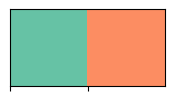

In [21]:
set2 = sns.color_palette('Set2', n_colors=2)
sns.palplot(set2)

In [28]:
    xena_metadata_df, xena_exp_df, vtx_id_to_transcripts = load_xena_tcga_gtex_target()
    transcript_to_vtx_id = {}

    for ix, row in vtx_id_to_transcripts.iterrows():
        for val in row['transcripts_exact']:
            transcript_to_vtx_id[val] = ix
    
    # xena_exp_df = xena_exp_df.T.copy()
    # xena_exp_df = xena_exp_df.loc[xena_exp_df.index.intersection(transcript_to_vtx_id.keys())]
    # xena_exp_df['vtx_id'] = xena_exp_df.apply(lambda x: transcript_to_vtx_id[x.name], axis=1)
    # xena_exp_df = xena_exp_df.groupby('vtx_id').aggregate(np.sum).T

100%|██████████| 794/794 [00:00<00:00, 133051.43it/s]


In [32]:
df = pd.read_parquet('../cache/xena.parq')
df

,detailed_category,primary disease or tissue,_primary_site,_sample_type,_gender,_study,ENST00000603548,ENST00000525546,ENST00000470968,ENST00000462950,ENST00000334919,ENST00000313695,ENST00000371069,ENST00000544211,ENST00000566797,ENST00000513453,ENST00000378858,ENST00000524131,ENST00000597725,ENST00000539417,ENST00000601249,ENST00000375682,ENST00000304800,ENST00000379561,ENST00000368751,ENST00000606895,ENST00000265195,ENST00000420316,ENST00000433197,ENST00000395118,ENST00000558492,ENST00000603524,ENST00000535174,ENST00000531972,ENST00000530617,ENST00000265560,ENST00000486975,ENST00000371344,ENST00000530781,ENST00000564907,ENST00000541395,ENST00000477442,ENST00000316292,ENST00000581080,ENST00000293880,ENST00000269187,ENST00000623306,ENST00000482378,ENST00000381395,ENST00000581851,...,ENST00000371341,ENST00000246020,ENST00000622441,ENST00000378090,ENST00000549415,ENST00000430232,ENST00000556419,ENST00000323061,ENST00000589481,ENST00000445184,ENST00000542996,ENST00000333039,ENST00000492509,ENST00000354866,ENST00000333145,ENST00000294868,ENST00000532795,ENST00000470769,ENST00000628547,ENST00000430801,ENST00000346128,ENST00000590884,ENST00000604872,ENST00000324106,ENST00000620737,ENST00000564488,ENST00000565013,ENST00000422183,ENST00000629823,ENST00000267260,ENST00000371113,ENST00000496809,ENST00000492700,ENST00000621943,ENST00000177694,ENST00000584948,ENST00000625766,ENST00000536534,ENST00000476241,ENST00000315776,ENST00000564912,ENST00000537305,ENST00000435868,ENST00000560136,ENST00000316163,ENST00000414678,ENST00000256078,ENST00000444134,ENST00000507187,ENST00000435079
GTEX-S4Q7-0003-SM-3NM8M,Cells - Ebv-Transformed Lymphocytes,Cells - Ebv-Transformed Lymphocytes,Blood,Cell Line,Male,GTEX,5.450921,0.160996,0.001000,0.001000,0.001000,1.730993,0.110998,0.001000,0.001000,0.001,0.021000,0.001000,0.001,0.841013,0.041001,1.111032,24.571261,5.040965,0.001,5.290852,1.661055,0.001000,3.801055,0.130996,0.001000,0.001000,2.150989,6.681166,14.921286,21.761408,0.041001,1.781015,1.100989,0.001000,0.001000,38.110061,8.190775,0.160996,1.551001,16.170585,0.001,1.021012,0.050999,0.001000,...,89.660460,0.001,0.950989,3.621030,0.001,0.001,0.001,1.200970,0.001000,3.091056,0.650987,0.141003,0.001000,11.830999,2.490957,0.231006,0.001000,1.030968,0.001000,0.371002,0.021000,0.421002,5.360992,3.200950,0.001000,1.281026,0.001,6.630878,0.001,0.011000,0.691020,10.070755,0.001000,0.001000,20.791184,0.001,1.191022,0.001000,9.611090,0.001000,0.001000,0.311003,0.001000,1.410982,0.081002,10.960943,0.590988,0.491002,0.531006,0.001000
TCGA-19-1787-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Male,TCGA,0.050999,0.171004,0.001000,0.001000,0.001000,8.730716,7.091054,0.001000,0.001000,0.001,0.141003,0.001000,0.001,1.071031,0.001000,0.210998,94.412109,13.370671,0.001,0.160996,1.811017,0.121002,1.811017,5.641192,0.680987,0.001000,0.330999,43.471561,6.110964,15.311036,0.090999,0.260996,0.610981,0.001000,0.001000,41.770138,2.130955,0.721014,1.091037,35.570270,0.001,15.281349,3.270928,1.330990,...,154.536091,0.001,0.600985,1.890935,0.001,0.001,0.001,18.330827,0.001000,1.471003,3.020945,14.750582,0.001000,10.221252,1.890935,0.441015,0.001000,0.340990,0.001000,0.921017,1.261028,0.050999,0.630995,0.121002,0.001000,0.621015,0.001,3.721025,0.001,0.011000,4.980878,16.630965,0.001000,6.511094,0.181005,0.001,2.141023,0.121002,0.910986,0.001000,0.001000,0.390989,0.001000,4.381121,1.461044,9.021079,0.171004,0.340990,0.160996,0.141003
TCGA-S9-A7J2-01,Brain Lower Grade Glioma,Brain Lower Grade Glioma,Brain,Primary Tumor,Male,TCGA,0.761017,0.001000,0.001000,2.860961,0.511002,15.841093,12.631027,0.001000,0.001000,0.001,0.401007,0.460988,0.001,1.230974,0.130996,0.001000,61.691508,8.051179,0.001,0.770999,1.471003,0.090999,2.371007,0.901001,0.001000,0.001000,1.471003,18.431480,5.110980,16.710697,0.231006,0.171004,0.421002,0.011000,0.001000,18.101031,1.051027,3.170917,1.820961,76.331149,0.001,14.940950,2.740996,0.021000,...,35.951997,0.001,0.271007,1.420994,0.001,

In [18]:
    xena_metadata_df, xena_exp_df, vtx_id_to_transcripts = load_xena_tcga_gtex_target()
    
    transcript_to_vtx_id = {}

    for ix, row in vtx_id_to_transcripts.iterrows():
        for val in row['transcripts_exact']:
            transcript_to_vtx_id[val] = ix
    
    xena_exp_df = xena_exp_df.T.copy()
    xena_exp_df = xena_exp_df.loc[xena_exp_df.index.intersection(transcript_to_vtx_id.keys())]
    xena_exp_df['vtx_id'] = xena_exp_df.apply(lambda x: transcript_to_vtx_id[x.name], axis=1)
    xena_exp_df = xena_exp_df.groupby('vtx_id').aggregate(np.sum).T

100%|██████████| 794/794 [00:00<00:00, 128265.19it/s]


In [19]:
xena_exp_df

vtx_id,VTX-0007082,VTX-0009335,VTX-0009670,VTX-0011570,VTX-0014206,VTX-0015094,VTX-0022943,VTX-0062325,VTX-0076639,VTX-0079935,VTX-0084101,VTX-0085275,VTX-0085575,VTX-0085734,VTX-0085991,VTX-0087707,VTX-0088126,VTX-0094405,VTX-0101354,VTX-0296454,VTX-0302164,VTX-0315807,VTX-0316937,VTX-0316938,VTX-0316976,VTX-0327813,VTX-0331005,VTX-0331059,VTX-0333182,VTX-0337413,VTX-0355814,VTX-0355819,VTX-0355824,VTX-0361728,VTX-0369900,VTX-0380537,VTX-0398369,VTX-0402680,VTX-0405049,VTX-0405050,VTX-0414654,VTX-0422271,VTX-0422275,VTX-0439900,VTX-0439932,VTX-0448853,VTX-0454924,VTX-0457097,VTX-0458254,VTX-0458347,...,VTX-0850342,VTX-0850343,VTX-0850344,VTX-0850345,VTX-0850346,VTX-0850353,VTX-0850354,VTX-0850411,VTX-0850418,VTX-0850419,VTX-0850430,VTX-0850436,VTX-0850457,VTX-0850463,VTX-0850472,VTX-0850478,VTX-0850495,VTX-0850496,VTX-0850497,VTX-0850514,VTX-0850518,VTX-0850570,VTX-0850571,VTX-0850598,VTX-0850600,VTX-0850601,VTX-0850612,VTX-0850624,VTX-0850625,VTX-0850693,VTX-0850698,VTX-0850815,VTX-0850820,VTX-0850841,VTX-0850845,VTX-0850891,VTX-0851314,VTX-0851377,VTX-0851439,VTX-0851502,VTX-0851523,VTX-0851538,VTX-0851570,VTX-0851572,VTX-0851604,VTX-0851627,VTX-0851668,VTX-0851950,VTX-0851993,VTX-0852287
GTEX-S4Q7-0003-SM-3NM8M,0.762017,0.130996,1.241997,2.781993,25.031598,17.401020,0.001000,0.001000,0.002000,2.091010,24.030587,0.042001,5.731052,0.001000,2.353041,0.340990,1.563033,0.177001,2.120934,7.601764,0.110998,0.001,0.001,6.141967,0.210998,10.858033,4.820892,0.141003,4.742028,8.450871,1.781981,0.145000,0.723013,0.001000,14.921286,0.001000,2.912991,6.861910,3.363942,1.142001,0.002000,15.916242,2.853073,1.801002,16.721942,12.346969,8.140966,0.562011,0.972994,0.330999,...,1.052027,8.192103,27.283710,8.302948,6.284010,0.061002,4.043030,0.001000,0.171004,0.001000,0.663002,0.280992,0.012,2.032965,12.091321,4.101069,0.031000,0.662002,0.001,6.301084,1.041022,0.613996,3.222949,2.820987,0.001,69.221834,11.412859,12.612244,15.431432,0.020000,2.530987,1.701020,1.091037,0.001000,38.143178,0.481997,0.001,0.001,0.630995,16.221584,0.401007,0.752008,0.002000,0.032000,22.644140,0.001,14.707991,0.001,0.021000,0.021000
TCGA-19-1787-01,3.832055,0.001000,0.002000,2.632056,0.002000,10.320922,0.001000,0.001000,0.002000,0.401007,16.721125,0.881989,3.190981,0.001000,17.712571,0.001000,3.063063,7.066974,0.970971,6.751931,0.001000,0.001,0.001,20.551803,0.240999,34.287427,3.170917,14.750582,1.282026,40.670195,0.692020,3.364929,108.082996,0.001000,6.110964,0.001000,10.672705,0.022000,0.664014,0.481997,0.022000,8.315915,4.923007,4.960894,23.222039,6.196907,0.830988,0.322003,0.433012,0.291002,...,1.201970,18.682003,28.323821,2.982963,42.383110,20.710637,4.852866,0.150998,0.001000,0.001000,0.162996,2.171061,0.002,0.762989,19.020721,0.891002,0.041001,5.732191,0.001,4.810877,2.240934,0.213994,0.123002,12.501246,0.001,64.333388,19.953194,15.212050,72.559872,9.009845,0.550991,9.370980,0.001000,0.150998,122.114133,0.002000,0.001,0.001,1.330990,35.711273,9.131172,0.002000,0.002000,0.002000,39.154243,0.001,15.067831,0.001,2.351041,0.150998
TCGA-S9-A7J2-01,94.824418,0.001000,0.372002,21.401431,0.131996,17.020482,0.001000,0.130996,0.002000,17.701504,32.769914,2.561980,1.401042,0.001000,12.682841,0.001000,13.132759,6.307031,0.231006,12.562062,0.001000,0.001,0.001,6.661914,1.710953,68.577809,1.710953,53.050704,3.632083,67.743001,0.162003,3.294996,7.253158,0.001000,5.110980,0.110998,2.173044,0.102001,18.574401,0.961994,0.002000,14.775737,19.502961,3.060994,11.401943,3.337008,3.240912,1.842013,0.922987,1.071031,...,3.502080,25.001679,52.654973,2.103024,12.463899,46.401515,7.533159,0.130996,0.001000,0.041001,1.032968,0.001000,0.002,0.473000,17.141245,3.070982,0.011000,0.902001,0.001,8.181129,7.601057,0.064002,0.073002,51.172613,0.001,66.911860,355.264163,21.952250,26.960961,68.109476,2.211001,5.071104,0.001000,0.061002,62.733722,0.002000,0.001,0.001,1.751025,76.382147,12.110613,0.172004,0.881991,0.002000,38.243635,0.001,29.288431,0.001,6.730903,0.071002
GTEX-QV31-1626-SM-2S1QC,0.

In [6]:
def load_xena_tcga_gtex_target():
    xena_metadata = pd.read_table('./data/TcgaTargetGTEX_phenotype.txt', encoding='latin-1', index_col=0)
    xena_expression = pd.read_feather('./data/xena_ucsc_phase1to6.feather')
    xena_expression.index = xena_expression.pop('index')
    xena_metadata = xena_metadata.loc[xena_expression.index]
    vtx_id_to_transcripts = json.load(open('./data/vtx_to_ensembl_ids.json', 'r'))
    return xena_metadata, xena_expression, vtx_id_to_transcripts
xena_metadata, xena_expression, vtx_id_to_transcripts = load_xena_tcga_gtex_target()

In [104]:
def load_tcga_tumor_vs_nat(xena_metadata, xena_expression):
    cancers = pd.read_csv('./data/cancer_types.txt', header=None, names = ['Disease', 'Code'])
    cancers.index = [i.lower() for i in cancers['Disease']]
    tcga_paired_normal = {}
    tcga_paired_normal_index = []
    pairs = pd.read_excel('./data/tissue_pairs.xlsx')
    for ix, row in pairs.iterrows():
        if isinstance(row['NAT (Solid Tissue Normal)'], str):
            tcga_groups = xena_metadata[(xena_metadata['_primary_site'] == row['Tissue (Disease)']) & (xena_metadata['_study'] == 'TCGA')].copy()
            for cancer in tcga_groups['primary disease or tissue'].unique():
                primary_tumor_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                                   (tcga_groups['_sample_type']=='Primary Tumor')].index
                normal_adjacent_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                                   (tcga_groups['_sample_type']=='Solid Tissue Normal')].index
                if len(primary_tumor_samples)>=8 and (len(normal_adjacent_samples)>=8):
                    tcga_paired_normal[cancer] = {'Tumor': primary_tumor_samples, 'NAT': normal_adjacent_samples}
                    tcga_paired_normal_index += list(primary_tumor_samples)+list(normal_adjacent_samples)
        else:
            continue
    tcga_nat_table = xena_expression.loc[tcga_paired_normal_index].copy()
    tcga_nat_table.insert(0, 'Cancer', '')
    tcga_nat_table.insert(1, 'Condition', '')
    for c, s in tcga_paired_normal.items():
        tcga_nat_table.loc[s['Tumor'], 'Cancer'] = c
        tcga_nat_table.loc[s['NAT'], 'Cancer'] = c
        tcga_nat_table.loc[s['Tumor'], 'Condition'] = 'Cancer'
        tcga_nat_table.loc[s['NAT'], 'Condition'] = 'Normal Adjacent'
    ave_per_transcript_per_cancer = tcga_nat_table.groupby(['Cancer', 'Condition']).mean()
    ave_per_transcript_per_cancer = ave_per_transcript_per_cancer.reset_index()
    stats_per_tumor = {}
    for c, s in tcga_paired_normal.items():
        tumor = tcga_nat_table.loc[s['Tumor'], tcga_nat_table.columns[2:]]
        normal = tcga_nat_table.loc[s['NAT'], tcga_nat_table.columns[2:]]
        logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
        test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')

        stats = pd.DataFrame({'ranksum': test_statistic, 'p_value': p_value, 'logFC': logfcs.values, 
                 'FDR': multipletests(p_value, method='fdr_bh')[1]}, index=tumor.columns)
        stats_per_tumor[c] = stats.copy()
    logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
    return ave_per_transcript_per_cancer, logfcs, stats_per_tumor
ave_per_transcript_per_cancer, logfcs, stats_per_tumor = load_tcga_tumor_vs_nat(xena_metadata, xena_expression)

In [111]:
transcript_ids = tids

In [114]:
logfcs

-2.8838033326607477

In [118]:
logfcs

-2.8838033326607477

In [119]:
test_statistic

-3.024028244192858

In [ ]:
tumor

In [139]:
normal = tcga_nat_table[tcga_nat_table.Condition=='Normal Adjacent']8
tumor = tcga_nat_table[tcga_nat_table.Condition=='Cancer'].groupby('Cancer')[overlap].mean().sum(axis=1)
logfcs = tumor - normal
test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')
p_value

0.2086852353761599

In [132]:
    overlap = list(set(transcript_ids).intersection(set(tcga_nat_table.columns[2:])))
    tumor = tcga_nat_table.loc[s['Tumor'], overlap].sum(axis=1)
    normal = tcga_nat_table.loc[s['NAT'], overlap].sum(axis=1)
    logfcs = tumor - normal
    test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')
    
    # stats = pd.DataFrame({'ranksum': test_statistic, 'p_value': p_value, 'logFC': logfcs.values, 
             # 'FDR': multipletests(p_value, method='fdr_bh')[1]}, index=tumor.columns)

In [ ]:
def estimate_ranksums_per_sorf(tcga_nat_table, transcript_ids):
    overlap = set(transcript_ids).intersection(set(tcga_nat_table.columns[2:]))
    tumor = tcga_nat_table.loc[s['Tumor'], overlap].sum(axis=1)
    normal = tcga_nat_table.loc[s['NAT'], overlap].sum(axis=1)
    logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
    test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')
    stats = pd.DataFrame({'ranksum': test_statistic, 'p_value': p_value, 'logFC': logfcs.values, 
             'FDR': multipletests(p_value, method='fdr_bh')[1]}, index=tumor.columns)
    

In [109]:
for vtx_id, tids in vtx_id_to_transcripts.items():
    
    break
tids

['ENST00000263741',
 'ENST00000360001',
 'ENST00000459994',
 'ENST00000465727',
 'ENST00000660930']

In [15]:
import jsonlines
def load_esmfold():
    esmfold = {}
    with jsonlines.open('./data/phase1to6_secreted_esmfold.json') as fopen:
        for l in fopen.iter():
            esmfold[l['sequence']] = l
    return esmfold
e = load_esmfold()
# e = {v['id']: v['mean_plddt'] for k, v in e.items()}


784

In [73]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def plot_plddt_legend(dpi=100):
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt


def show_pdb(pdb, rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(pdb ,'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

In [ ]:
py3Dmol.view(

In [30]:
import pandas as pd
from st_aggrid import AgGrid
import json
import numpy as np

df = pd.read_excel('./data/interim_phase1to6_secreted_hits_20230330.xlsx')

In [71]:
import plotly.express as px
px.plotly

In [69]:
import jsonlines
esmfold = {}
with jsonlines.open('./data/phase1to6_secreted_esmfold.json') as fopen:
    for l in fopen.iter():
        esmfold[l['sequence']] = l


In [36]:
np.percentile(e['IAFTVFFRLLRTWHLQMAPVHVLCCVSVLLATFYLTPTESAGSLVSYTPNSCCYGFQQHPPPVQILKEWYPTSPACPKPGVILLTKRGRQICADPSKNWVRQLMQRLPAIA']['plddt'], 90)

83.3119888305664

In [18]:
    xena_metadata = pd.read_table('./data/TcgaTargetGTEX_phenotype.txt', encoding='latin-1', index_col=0)
    xena_expression = pd.read_feather('./data/xena_ucsc_phase1to6.feather')
    xena_expression.index = xena_expression.pop('index')
    xena_metadata = xena_metadata.loc[xena_expression.index]
    vtx_id_to_transcripts = json.load(open('./data/vtx_to_ensembl_ids.json', 'r'))

In [31]:
xena_metadata.columns

Index(['detailed_category', 'primary disease or tissue', '_primary_site',
       '_sample_type', '_gender', '_study'],
      dtype='object')

In [22]:
sorf_excel_table = pd.read_excel('./data/interim_phase1to6_secreted_hits_20230330.xlsx')

In [20]:
st.session_state['id_type_selected'] = 'primary_id'

2023-04-07 19:33:13.526 Session state does not function when running a script without `streamlit run`


In [ ]:
sorf_excel_table[st.session_state['id_type_selected']]

In [24]:
sorf_excel_table.head(3)

,vtx_id,primary_id,genscript_id,phase,orf_xref,protein_xrefs,gene_xref,transcript_xref,source,sec_trans_ratio,...,chromosome,strand,start,end,chrom_starts,block_sizes,phases,nucl,aa,isoform_of
0,VTX-0850284,smORF32119,U8990HF130-8,Phase 1,smORF32119;U8990HF130-8,smORF32119;6xhis-HSA-HRV3C-smORF32119_02;VTXRP011,ENSG00000078808.20;HGNC:24188;SDF4;24188;51150...,CHS.68.20;CHS.68.7;CHS.68.8;ENST00000360001.12...,velia_phase1_secreted_smORFs,1.459455,...,chr1,-,1228464,1228739,1228464,275,0,GCTCCGTGCTGCCTCTGGCTCCTGGGGGCAGTCCTTCTGATGGACG...,APCCLWLLGAVLLMDASARPANHSSTRERVANREENEILPPDHLNG...,"['ENSP00000435962.1', 'ENSP00000263741.8', 'EN..."
1,VTX-0850613,smORF85917,U6813HF130-147,Phase 1,smORF85917;U6813HF130-147,smORF85917,220323;28752;ENSG00000184232.9;gene-OAF;HGNC:2...,CHS.10211.2;ENST00000328965.9;NM_178507.4;OTTH...,velia_phase1_secreted_smORFs,1.682371,...,chr11,+,120211301,120211552,120211301,251,0,CTGGCGCGCCCTGCGCTGCTGCTGCTGCTGCCGCTGCTCGCGCCGC...,LARPALLLLLPLLAPLLGTGAPAELRVRVRLPDGQVTEESLQADSD...,NaN
2,VTX-0850424,smORF419458,U8990HF130-150,Phase 1,smORF419458;U8990HF130-150,smORF419458;6xhis-HSA-HRV3C-smORF419458_02;VTX...,ENSG00000164106.8;HGNC:17036;SCRG1;11341;17036...,CHS.41825.2;ENST00000296506.8;NM_007281.4;OTTH...,velia_phase1_secreted_smORFs,1.265618,...,chr4,-,173391169,173391408,173391169,239,0,CTGATGGTACTTGTTTTCACCATTGGGCTAACTTTGCTGCTAGGAG...,LMVLVFTIGLTLLLGVQAMPANRLSCYRKILKDHNCHNLPEGVADL...,"['ENSP00000425404.1', 'ENSP00000296506.2']"


In [5]:
vtx_id = 'VTX-0850284'

In [6]:
selected_transcripts = vtx_id_to_transcripts[vtx_id]

KeyError: 'VTX-0850284'

In [ ]:
selected_expression = xena_expression[xena_expression.columns.intersection(selected_transcripts)]

In [ ]:
groups = list(map(lambda x: '-'.join(map(str, x)), xena_metadata[['_primary_site', '_study']].values))
selected_expression.groupby(groups).mean()

In [29]:
vtx_id = sorf_excel_table[sorf_excel_table['primary_id'] == 'smORF32119']
vtx_id.iloc[0]['vtx_id']

'VTX-0850284'

In [37]:
ag_df.columns

NameError: name 'ag_df' is not defined

In [42]:

xena_metadata = pd.read_table('./data/TcgaTargetGTEX_phenotype.txt', encoding='latin-1', index_col=0)

In [45]:
xena_expression = pd.read_feather('./data/xena_ucsc_phase1to6.feather')
xena_expression.index = xena_expression.pop('index')

In [ ]:
def load_tcga_tumor_vs_nat(xena_metadata, xena_expression):
    cancers = pd.read_csv('./data/cancer_types.txt', header=None, names = ['Disease', 'Code'])
    cancers.index = [i.lower() for i in cancers['Disease']]
    tcga_paired_normal = {}
    tcga_paired_normal_index = []
    pairs = pd.read_excel('./data/tissue_pairs.xlsx')
    for ix, row in pairs.iterrows():
        if isinstance(row['NAT (Solid Tissue Normal)'], str):
            tcga_groups = xena_metadata[(xena_metadata['_primary_site'] == row['Tissue (Disease)']) & (xena_metadata['_study'] == 'TCGA')].copy()
            for cancer in tcga_groups['primary disease or tissue'].unique():
                primary_tumor_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                                   (tcga_groups['_sample_type']=='Primary Tumor')].index
                normal_adjacent_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                                   (tcga_groups['_sample_type']=='Solid Tissue Normal')].index
                if len(primary_tumor_samples)>=8 and (len(normal_adjacent_samples)>=8):
                    tcga_paired_normal[cancer] = {'Tumor': primary_tumor_samples, 'NAT': normal_adjacent_samples}
                    tcga_paired_normal_index += list(primary_tumor_samples)+list(normal_adjacent_samples)
        else:
            continue
    tcga_nat_table = xena_expression.loc[tcga_paired_normal_index].copy()
    tcga_nat_table.insert(0, 'Cancer', '')
    tcga_nat_table.insert(1, 'Condition', '')
    for c, s in tcga_paired_normal.items():
        tcga_nat_table.loc[s['Tumor'], 'Cancer'] = c
        tcga_nat_table.loc[s['NAT'], 'Cancer'] = c
        tcga_nat_table.loc[s['Tumor'], 'Condition'] = 'Cancer'
        tcga_nat_table.loc[s['NAT'], 'Condition'] = 'Normal Adjacent'
    ave_per_transcript_per_cancer = tcga_nat_table.groupby(['Cancer', 'Condition']).mean()
    ave_per_transcript_per_cancer = ave_per_transcript_per_cancer.reset_index()
    stats_per_tumor = {}
    for c, s in tqdm(tcga_paired_normal.items()):
        tumor = tcga_nat_table.loc[s['Tumor'], tcga_nat_table.columns[2:]]
        normal = tcga_nat_table.loc[s['NAT'], tcga_nat_table.columns[2:]]
        logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
        test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')

        stats = pd.DataFrame({'ranksum': test_statistic, 'p_value': p_value, 'logFC': logfcs.values, 
                 'FDR': multipletests(p_value, method='fdr_bh')[1]}, index=tumor.columns)
        stats_per_tumor[c] = stats.copy()
    logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
    return ave_per_transcript_per_cancer

In [48]:
tcga_paired_normal = {}
tcga_paired_normal_index = []
pairs = pd.read_excel('./data/tissue_pairs.xlsx')
for ix, row in pairs.iterrows():
    if isinstance(row['NAT (Solid Tissue Normal)'], str):
        tcga_groups = xena_metadata[(xena_metadata['_primary_site'] == row['Tissue (Disease)']) & (xena_metadata['_study'] == 'TCGA')].copy()
        for cancer in tcga_groups['primary disease or tissue'].unique():
            primary_tumor_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                               (tcga_groups['_sample_type']=='Primary Tumor')].index
            normal_adjacent_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                               (tcga_groups['_sample_type']=='Solid Tissue Normal')].index
            if len(primary_tumor_samples)>=8 and (len(normal_adjacent_samples)>=8):
                tcga_paired_normal[cancer] = {'Tumor': primary_tumor_samples, 'NAT': normal_adjacent_samples}
                tcga_paired_normal_index += list(primary_tumor_samples)+list(normal_adjacent_samples)
    else:
        continue
tcga_nat_table = xena_expression.loc[tcga_paired_normal_index].copy()
tcga_nat_table.insert(0, 'Cancer', '')
tcga_nat_table.insert(1, 'Condition', '')
for c, s in tcga_paired_normal.items():
    tcga_nat_table.loc[s['Tumor'], 'Cancer'] = c
    tcga_nat_table.loc[s['NAT'], 'Cancer'] = c
    tcga_nat_table.loc[s['Tumor'], 'Condition'] = 'Cancer'
    tcga_nat_table.loc[s['NAT'], 'Condition'] = 'Normal Adjacent'
ave_per_transcript_per_cancer = tcga_nat_table.groupby(['Cancer', 'Condition']).mean()
ave_per_transcript_per_cancer = ave_per_transcript_per_cancer.reset_index()

In [55]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


In [102]:
base_link = "http://genome.ucsc.edu/cgi-bin/hgTracks?"
genome = "db=hg38"
chrom = 'chr15'
start = 64162657
end = 64162944
position = f"{chrom}:{start}-{end}"
ucsc_link = f"{base_link}{genome}&position={position}"
ucsc_link

'http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr15:64162657-64162944'

In [60]:
ave_per_transcript_per_cancer.head(2)

,Cancer,Condition,ENST00000046640,ENST00000064724,ENST00000075322,ENST00000084795,ENST00000175756,ENST00000181796,ENST00000217121,ENST00000217428,...,ENST00000630242,ENST00000630243,ENST00000630417,ENST00000630482,ENST00000630717,ENST00000630863,ENST00000630874,ENST00000631105,ENST00000631189,ENST00000631366
0,Bladder Urothelial Carcinoma,Cancer,2.292933,-0.673245,-6.154497,10.058762,3.934293,-9.747943,-7.480388,-8.799299,...,-5.787936,-7.865831,-6.052789,-9.111968,-9.69137,-9.588936,-8.823113,-9.623387,-9.411501,-7.611047
1,Bladder Urothelial Carcinoma,Normal Adjacent,1.988821,2.076905,-2.803753,9.745568,3.644284,-9.965800,-9.253105,-7.373000,...,-4.918753,-6.807900,-7.600558,-9.965800,-9.96580,-8.616100,-8.508921,-8.703642,-9.579963,-8.699458


In [64]:
import altair as alt

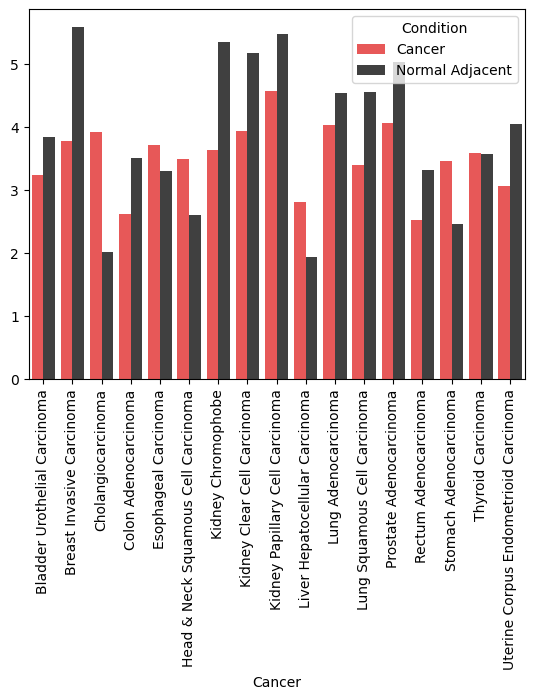

In [98]:
selected_transcripts = ['ENST00000046640', 'ENST00000064724']
exp_bplot = sns.barplot(data = ave_per_transcript_per_cancer, x='Cancer',
            y=ave_per_transcript_per_cancer[selected_transcripts].apply(lambda x: np.log2(np.sum(np.exp(x)-1)+1), axis=1),
            hue='Condition', alpha=0.75, palette=["r", "k"])
exp_bplot.set_xticks(exp_bplot.get_xticks(), exp_bplot.get_xticklabels(), rotation=90)

In [162]:
selected_expression

,ENST00000263741,ENST00000360001,ENST00000459994,ENST00000465727
index,,,,
GTEX-S4Q7-0003-SM-3NM8M,0.7146,5.3924,0.1903,-1.2142
TCGA-19-1787-01,2.3620,6.9667,-1.1172,-0.4921
TCGA-S9-A7J2-01,0.0990,5.3948,1.7489,-9.9658
GTEX-QV31-1626-SM-2S1QC,1.7446,6.4748,2.6278,-0.9971
TCGA-G3-A3CH-11,0.8726,5.8836,-1.8836,-9.9658
...,...,...,...,...
GTEX-11ZTS-3326-SM-5LU9Y,2.6019,6.2493,-9.9658,-0.6643
TCGA-DD-A115-01,1.9527,7.0944,2.8280,-9.9658
GTEX-ZA64-2126-SM-5Q5A8,2.5756,6.3036,-0.0725,-9.9658


In [173]:
selected_expression.min()

ENST00000263741   -9.9658
ENST00000360001   -9.9658
ENST00000459994   -9.9658
ENST00000465727   -9.9658
dtype: float64

In [183]:
        xena_expression.apply(lambda x: np.exp2(x).round(3)-0.001).min()

ENST00000046640    0.0
ENST00000064724    0.0
ENST00000075322    0.0
ENST00000084795    0.0
ENST00000175756    0.0
                  ... 
ENST00000630863    0.0
ENST00000630874    0.0
ENST00000631105    0.0
ENST00000631189    0.0
ENST00000631366    0.0
Length: 2020, dtype: float64

In [198]:
expression_table = {}
xena_metadata = xena_metadata.loc[xena_metadata._primary_site.dropna().index].copy()
for vtx_id in tqdm(df['vtx_id']):
    # Plot transcript expression levels
    selected_transcripts = vtx_id_to_transcripts[vtx_id]
    xena_overlap = xena_expression.columns.intersection(selected_transcripts)
    if len(xena_overlap)>=1:
        selected_expression = xena_expression[xena_overlap].copy()
        selected_expression = selected_expression.apply(lambda x: np.exp2(x).round(3)-0.001)
        groups = list(map(lambda x: '-'.join(map(str, x)), xena_metadata[['_study', '_primary_site', '_sample_type']].values))
        e = selected_expression.loc[xena_metadata.index].groupby(groups).mean().sum(axis=1)
        expression_table[vtx_id] = e
    else:
        expression_table[vtx_id] = [np.nan]*len(set(groups))
        # break

100%|██████████| 805/805 [00:43<00:00, 18.69it/s]


In [203]:
pd.DataFrame(expression_table).T.to_excel('sorf_expression_tcga_gtex_target.xlsx')

In [156]:
xena_metadata.loc[~(xena_metadata[['_study', '_primary_site', '_sample_type']].isna())]

ValueError: Cannot index with multidimensional key

In [143]:
groups

['Blood-GTEX',
 'Brain-TCGA',
 'Brain-TCGA',
 'Blood Vessel-GTEX',
 'Liver-TCGA',
 'Uterus-GTEX',
 'Thyroid-GTEX',
 'Blood Vessel-GTEX',
 'Cervix-TCGA',
 'Colon-TCGA',
 'Brain-TCGA',
 'Blood Vessel-GTEX',
 'Lining of body cavities-TCGA',
 'Skin-TCGA',
 'Muscle-GTEX',
 'Lung-GTEX',
 'Skin-GTEX',
 'Lung-TCGA',
 'Muscle-GTEX',
 'Colon-GTEX',
 'Testis-TCGA',
 'Nerve-GTEX',
 'Soft tissue,Bone-TCGA',
 'Kidney-TCGA',
 'Breast-TCGA',
 'Skin-GTEX',
 'Nerve-GTEX',
 'Prostate-TCGA',
 'Stomach-TCGA',
 'Esophagus-TCGA',
 'Skin-TCGA',
 'Kidney-TCGA',
 'White blood cell-TARGET',
 'Brain-GTEX',
 'Blood-GTEX',
 'Kidney-TCGA',
 'Thyroid-GTEX',
 'Brain-TCGA',
 'Soft tissue,Bone-TCGA',
 'Stomach-TCGA',
 'Prostate-TCGA',
 'Breast-TCGA',
 'Lung-GTEX',
 'Head and Neck region-TCGA',
 'Prostate-TCGA',
 'Muscle-GTEX',
 'Cervix-TCGA',
 'Brain-TCGA',
 'Thyroid-GTEX',
 'Kidney-TCGA',
 'Ovary-TCGA',
 'Kidney-TCGA',
 'Prostate-TCGA',
 'Skin-TCGA',
 'Blood Vessel-GTEX',
 'Lung-GTEX',
 'Colon-TCGA',
 'Breast-TCGA',
 '